# Model error covariance estimation in weak-constraint 4DVar

We import several python libraries:

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import linalg as LA
from numpy import random as rd
from sklearn.metrics import mean_squared_error

#set a random seed 
rd.seed(11)

import math 

from tqdm.notebook import tnrange, tqdm_notebook #progress bars
import time

%matplotlib notebook
%matplotlib inline

np.set_printoptions(threshold=np.inf) #plot full matrices


We import several classes written in seperate python files (see the documentation within these files for further information):

In [2]:
from model import Model
from model import Lorenz96
from observations import Obs
from dataassimilation import DA_methods
from dataassimilation import WC4DVar
from qestimation import q_estimate
from qestimation import q_estimate_analysis
from qestimation import evolution_over_windows
from qestimation import confidence_interval

## Contents

1. [Twin experiments with the Lorenz96 model](#1.-Twin-experiments-with-the-Lorenz-96-model)<br>
     1.1 [Setup](#1.1-Setup)<br> 
     1.2 [Validation experiments](#1.2-Validation-experiments)<br> 
     1.3 [Data assimilation](#1.3-Data-assimilation)<br>      
2. [Model error covariance estimation](#2.-Model-error-covariance-estimation)<br>
     2.1 [Experiment 1: observe everything](#2.1-Experiment-1:-observe-everything)<br>
     2.2 [Experiment 2: partial observations in space](#2.2-Experiment-2:-partial-observations-in-space)<br>
     2.3 [Experiment 3: partial observations in time](#2.3-Experiment-3:-partial-observations-in-time)<br>
     2.4 [Experiment 4: partial observations in time and space](#2.4-Experiment-4:-partial-observations-in-time-and-space)




## 1. Twin experiments with the Lorenz 96 model 

### 1.1 Setup

#### Initial condition

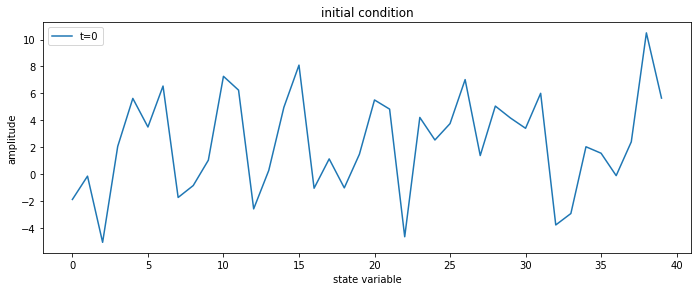

In [3]:
nr        = 40
nt        = 10
F         = 8
dt        = 0.01
my_Lorenz = Lorenz96(nr,F,dt)


u0     = F*np.ones(nr)
u0[0] += 0.01

for n in range(1000):
    u0 = my_Lorenz.step_rk4(u0) 
    
my_Lorenz.spatial_plot('initial condition',[0],u0)



#### Background

The initial background error covariance matrix is given by 
$$C_{b}(i,j)=\sigma_b^2 \exp\left(-\frac{(i-j)^2}{l_0^2}\right)$$
with variance $\sigma_b^2$ and correlation length $l_0$. 

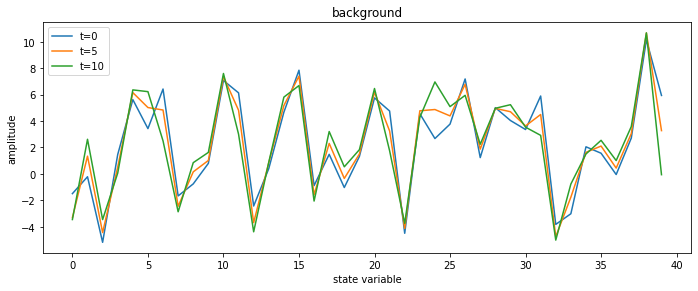

In [4]:
b_var     = 0.05
l0        = 0
Cb        = my_Lorenz.error_covariance('white',b_var,l0)
u_back    = np.zeros((nt+1,nr))
u_back[0] = u0.copy()+rd.multivariate_normal(np.zeros(nr), Cb)

for n in range(1,nt+1):
    u_back[n] = my_Lorenz.step_rk4(u_back[n-1]) 

my_Lorenz.spatial_plot('background',[0,5,10],u_back)

#### Truth

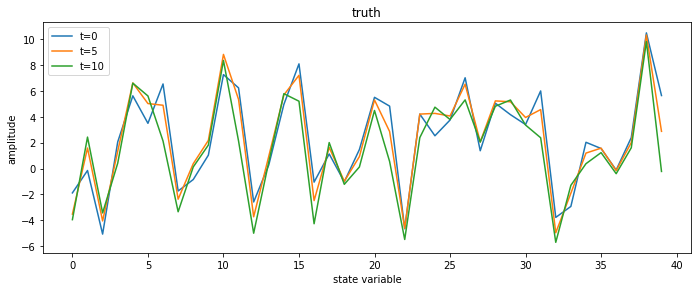

In [5]:
u_truth    = np.zeros((nt+1,nr))


q_var_truth = 0.1
Cq_truth    = my_Lorenz.error_covariance('spatial',q_var_truth,3)
u_truth[0]  = u0.copy()

for n in range(1,nt+1):
    u_truth[n] = my_Lorenz.step_rk4(u_truth[n-1])+rd.multivariate_normal(np.zeros(nr), Cq_truth)
    
# plots
my_Lorenz.spatial_plot('truth',[0,5,10],u_truth)

#### Observations

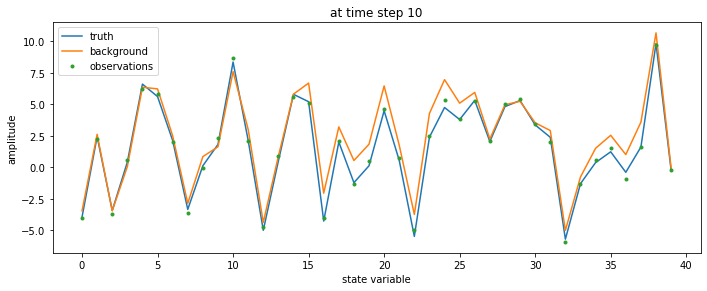

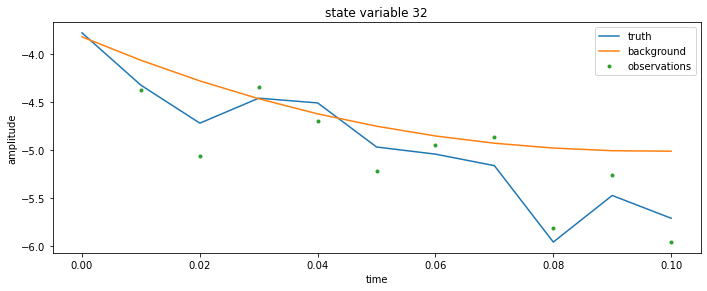

In [6]:
mr    = 40  # numbers of observations in space
mt    = 10  # numer of observations in time
dmr   = 1   # number of spatial gridpoints between  observations
dmt   = 1   # number of temporal gridpoints between observations

d_var = 0.05 # variance in observation error 


my_Obs = Obs(mr,mt,dmr,dmt,d_var,u_truth,0)

my_Lorenz.spatial_plot_observations(10,my_Obs,u_truth,u_back,nt)
my_Lorenz.temporal_plot_observations(32,my_Obs,u_truth,u_back,nt)

### 1.2 Validation experiments
Experiments to validate the implementation of the tangent linear model and adjoint model. 

The realtive error 
$$E_R=\frac{\|M(u+\gamma \delta u)-M(u)-\gamma \mathbf M[u] \delta u\|}{\|\gamma \mathbf M[u] \delta u\|}$$
converges to zero as $\gamma \to 0$. More precisely, if we consider the Taylor series of $M$ around $u$ we have 
$$M(u+\gamma \delta u)=M(u)+\mathbf M[u] (\gamma \delta u)+\mathcal O(\gamma^2)$$ and thus for $\gamma$ small enough we should observe a linear relationship between $E_R$ and $\gamma$ as $\gamma \to 0$. 

The slope in the linear regression is estimated as 1.0000280728574602, i.e. there is a linear relationship between gamma and E_R for gamma going to zero.


Text(0, 0.5, '$E_R$')

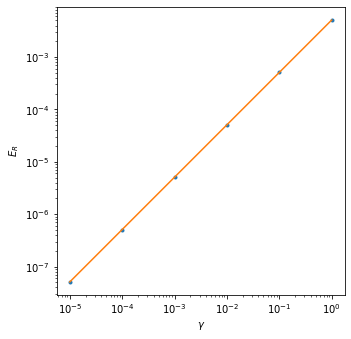

In [7]:
gamma   = np.array([1,10**(-1),10**(-2),10**(-3),10**(-4),10**(-5)])
num     = gamma.size
E_R     = np.zeros(num)
u_test  = u0
du_test = u0*0.1

for i in range(num):
    E_R[i] = LA.norm(my_Lorenz.step_rk4(u_test+gamma[i]*du_test)-my_Lorenz.step_rk4(u_test)-gamma[i]*my_Lorenz.TLM_step(u_test,du_test))/LA.norm(gamma[i]*my_Lorenz.TLM_step(u_test,du_test))


    
# simple linear regression
slope, intercept, r, p, std_err = stats.linregress(np.log(gamma), np.log(E_R))
mymodel = slope * np.log(gamma) + intercept
print(f'The slope in the linear regression is estimated as {slope}, i.e. there is a linear relationship between gamma and E_R for gamma going to zero.')


# plot 
fig  = plt.figure(figsize=(4, 4))
axes = fig.add_axes([1,1,1,1])
axes.plot(gamma,E_R,'.')
axes.plot(gamma,np.exp(mymodel))
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('$\gamma$')
axes.set_ylabel('$E_R$')

To validate the implementation of the adjoint model, we check whether the identity $$\langle Mx,Mx\rangle=\langle M^TMx,x\rangle$$ holds. 

In [8]:
mx  = my_Lorenz.TLM_step(u0,u0)
mmx = my_Lorenz.AM_step(u0, my_Lorenz.TLM_step(u0,u0))

lhs = np.inner(mx,mx)
rhs = np.inner(mmx,u0)

print(lhs==rhs)


True


### 1.3 Data assimilation

In [9]:
#Prescribed model error covariance for the DA 
q_var      = q_var_truth 
Cq_spatial = my_Lorenz.error_covariance('spatial',q_var,3)


Cq    = np.zeros((nr,nr,nt,nt))
for n in range(nt):
    Cq[:,:,n,n]=Cq_spatial


my_WC4DVar = WC4DVar('SD') # using steepest descent

#generate the analysis
u_analysis = my_WC4DVar.assimilate(my_Lorenz,nt,5,u_back[0],Cb,my_Obs,Cq)

Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 1000
Number of inner iterations in outer iteration number 3: 771
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [10.5774135  10.56260305 10.56332119 10.56322024 10.56325186]
Observation contribution to cost function [157.05817491 155.21283662 155.20762167 155.20809928 155.20791377]
Model contribution to cost function  [36.06469444 35.66856342 35.67251575 35.6721476  35.6722982 ]
The values of the cost function total [203.70028285 201.44400308 201.44345862 201.44346712 201.44346382]


In [10]:
my_WC4DVar.rms_compare(u_back,u_truth,u_analysis)

(0.6240184752705543, 0.11710940477305583)

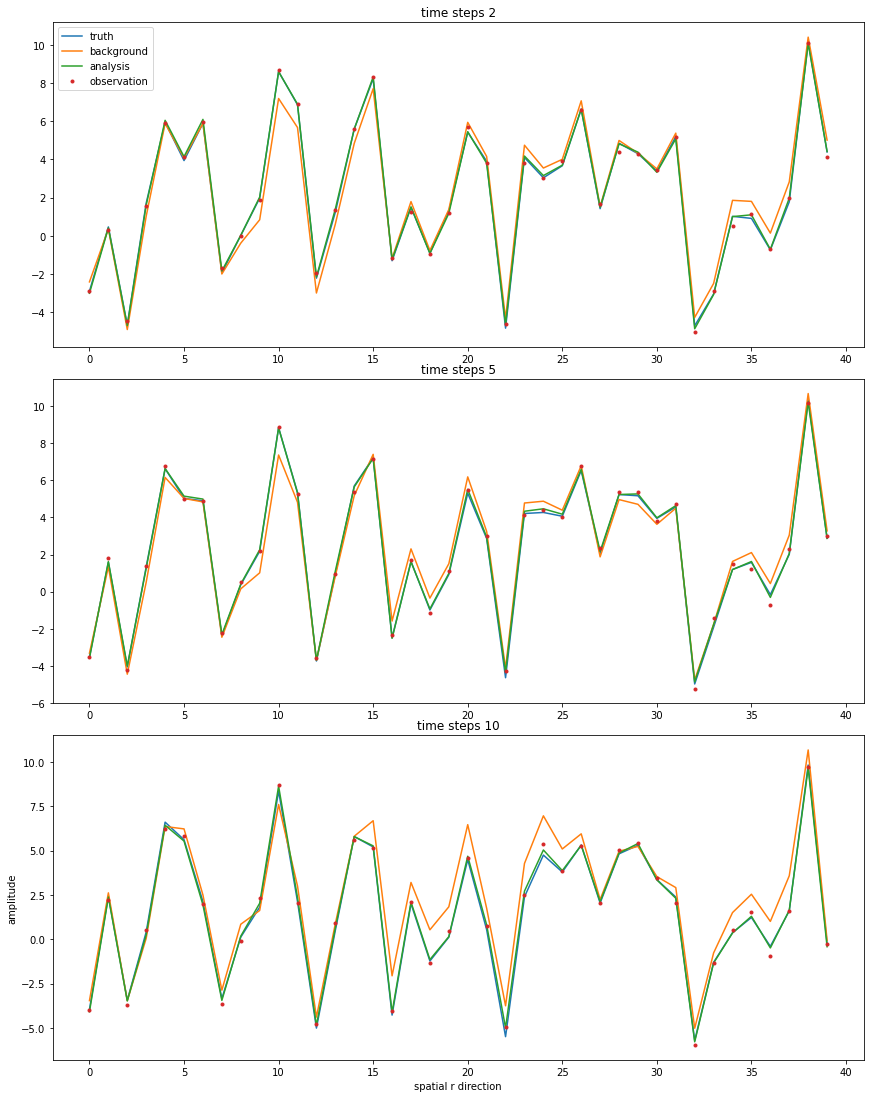

In [11]:
my_WC4DVar.plots_spatial(nt,u_truth,my_Obs,my_Lorenz,u_analysis,u_back,[2,5,10])

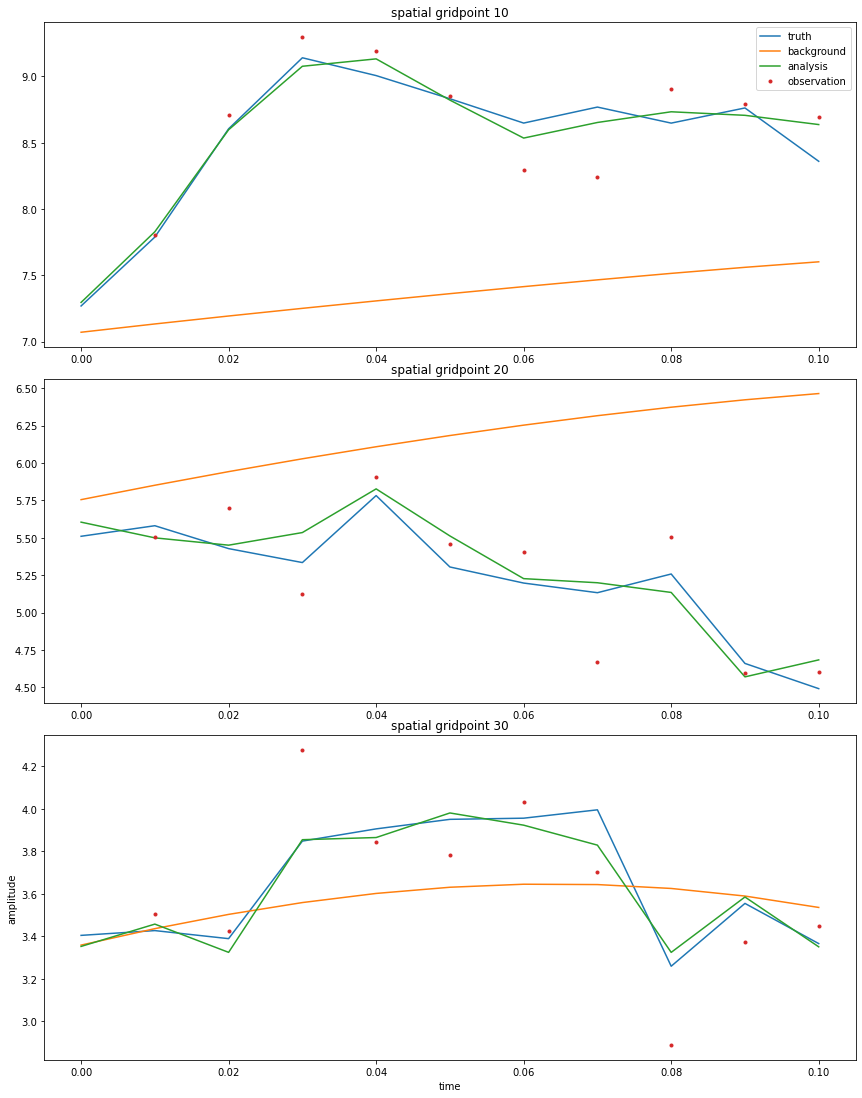

In [12]:
my_WC4DVar.plots_temporal(nt,u_truth,my_Obs,my_Lorenz,u_analysis,u_back,[10,20,30])

## 2. Model error covariance estimation
This section is independent of section 1. 

### 2.1 Experiment 1: observe everything

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 71
Number of inner iterations in outer iteration number 2: 23
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [135.32861288 135.37366735 135.37206542 135.37570553 135.37321783]
Observation contribution to cost function [684.7930375  684.71778111 684.71954005 684.71180807 684.71475092]
Model contribution to cost function  [794.13110986 794.01671038 794.01655488 794.02064735 794.02018281]
The values of the cost function total [1614.25276024 1614.10815883 1614.10816034 1614.10816094 1614.10815156]
RMS between background/truth and analysis/truth [0.35479109 0.11174042]
New estimate for variance coming from assimilation window 0: 0.04131958089910665
New estimate for correlation length coming from assimilation window 0: 3.121621999683416


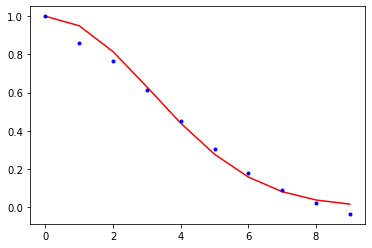

ASSIMILATION WINDOW NUMBER 1


In [ ]:
rd.seed(11)

win     = 15     # number of assimilation windows 
nt      = 5      # size of assimilation window
nr      = 200    # size spatial grid
dt      = 0.01   # temporal step size
mt      = 5      # number of observations in time
mr      = 200    # number of observations in space
dmt     = 1      # number of temporal gridpoints between observations
dmr     = 1      # number of spatial gridpoints between  observations
p       = 10 



b_var       = 0.01
b_len       = 0
d_var       = 0.01
q_var_truth = 0.05
l_truth     = 3



# Lorenz96 model set up
F         = 8.0
my_Lorenz = Lorenz96(nr,F,dt)


# initial condition 
u0     = F*np.ones(nr)
u0[0] += 0.01
for n in range(10000):    
    u0 = my_Lorenz.step_rk4(u0) 

    
    
    
u_analysis, u_back, u_truth, var, length,  meanvar, meanlen, H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)



In [ ]:
#repetitions for confidence interval 
rep     = 1
var     = np.zeros((rep,win))
length  = np.zeros((rep,win))
meanvar = np.zeros((rep,win))
meanlen = np.zeros((rep,win))

for i in range(rep): 
    u0     = F*np.ones(nr)
    u0[0] += 0.01
    for n in range((i+1)*1000):    
        u0 = my_Lorenz.step_rk4(u0) 
        
    u_analysis, u_back, u_truth, var[i], length[i],  meanvar[i], meanlen[i], H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)




estimated variances [[0.04125855 0.05686662 0.05561615 0.04742275 0.04509719 0.04303773
  0.05212991 0.05711758 0.04434212 0.04660522]]
estimated correlation length [[3.1289538  3.9206891  3.79677228 3.01161801 2.44196403 3.04657657
  3.48828146 2.93486063 2.5925801  2.83034579]]


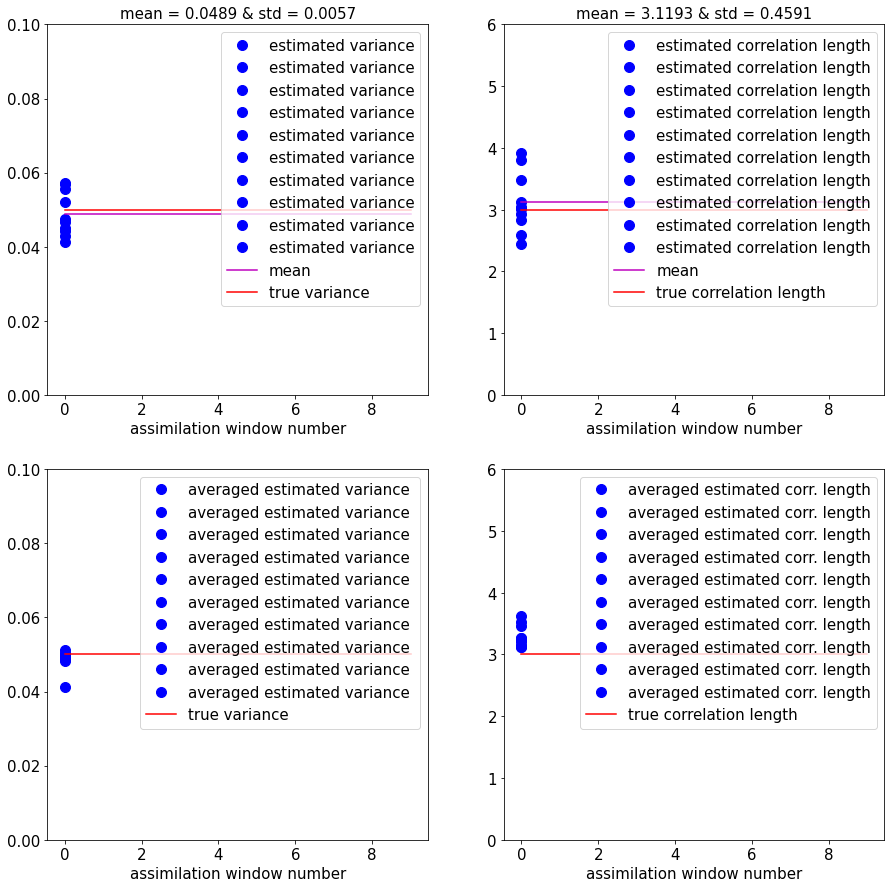

In [10]:
q_estimate_analysis(win,var,length,meanvar,meanlen,q_var_truth, l_truth)

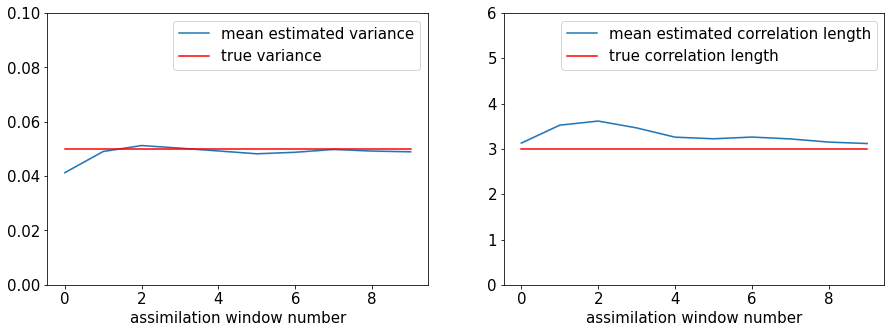

In [7]:
confidence_interval(win,rep,meanvar,meanlen,q_var_truth,l_truth)

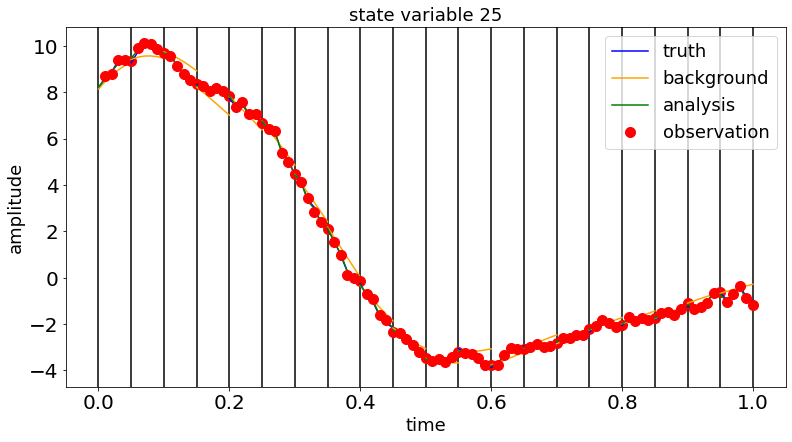

In [9]:
evolution_over_windows(25,win,mt,dmt,nt,dt,u_truth,u_back,u_analysis,H,d)

### 2.2 Experiment 2: partial observations in space

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 61
Number of inner iterations in outer iteration number 2: 11
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [64.70752571 64.7606977  64.76287025 64.76556479 64.7636057 ]
Observation contribution to cost function [315.48084573 315.39907606 315.39774951 315.38819372 315.39312186]
Model contribution to cost function  [402.25394621 402.22924042 402.22822457 402.23510461 402.23210525]
The values of the cost function total [782.44231766 782.38901418 782.38884433 782.38886312 782.38883282]
RMS between background/truth and analysis/truth [0.35479109 0.22000402]
New estimate for variance coming from assimilation window 0: 0.04179035510236334
New estimate for correlation length coming from assimilation window 0: 3.0306302935385068


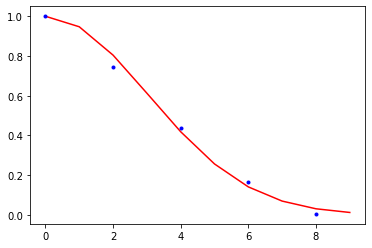

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 727
Number of inner iterations in outer iteration number 2: 287
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [30.17923829 30.32533006 30.32726305 30.32710562 30.32708935]
Observation contribution to cost function [144.83934645 145.05630628 145.05034285 145.05085004 145.04994911]
Model contribution to cost function  [146.0497031  144.79356113 144.7975515  144.79719654 144.79812117]
The values of the cost function total [321.06828784 320.17519747 320.1751574  320.1751522  320.17515963]
RMS between background/truth and analysis/truth [0.46925438 0.21384641]
New estimate for variance coming from assimilation window 1: 0.0588555850952994
New estimate for correlation length coming from assimilation window 1: 3.210452969561724


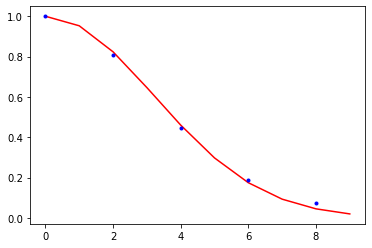

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 896
Number of inner iterations in outer iteration number 2: 375
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [22.2442345  22.27024839 22.27115134 22.27110201 22.27109321]
Observation contribution to cost function [114.38148212 114.0681717  114.06463724 114.06488383 114.06516911]
Model contribution to cost function  [105.86079977 105.76974459 105.77239248 105.77219787 105.77192876]
The values of the cost function total [242.4865164  242.10816468 242.10818106 242.10818371 242.10819109]
RMS between background/truth and analysis/truth [0.39211595 0.17651034]
New estimate for variance coming from assimilation window 2: 0.04365063193038513
New estimate for correlation length coming from assimilation window 2: 2.6951474550129


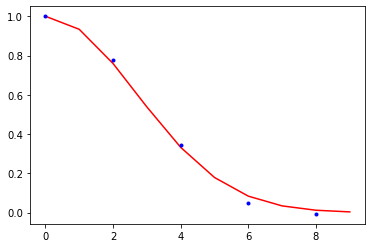

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 801
Number of inner iterations in outer iteration number 2: 285
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [24.05203691 24.16493721 24.16555884 24.16555095 24.16552744]
Observation contribution to cost function [111.42136391 111.36578293 111.36485504 111.3648896  111.36493041]
Model contribution to cost function  [120.6509463  119.91039099 119.91069575 119.91066829 119.91065046]
The values of the cost function total [256.12434712 255.44111113 255.44110963 255.44110884 255.44110832]
RMS between background/truth and analysis/truth [0.37254193 0.16367383]
New estimate for variance coming from assimilation window 3: 0.051103025138237876
New estimate for correlation length coming from assimilation window 3: 3.502612275684076


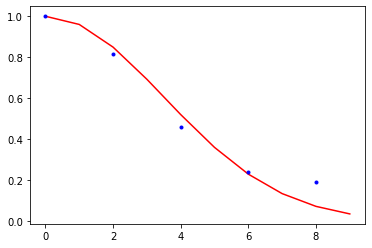

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 874
Number of inner iterations in outer iteration number 2: 351
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [30.50330271 30.47681598 30.47775311 30.47759574 30.47745071]
Observation contribution to cost function [131.52969727 131.25319067 131.24970155 131.25004189 131.25036659]
Model contribution to cost function  [119.85945038 119.99279389 119.99532181 119.99513691 119.99495714]
The values of the cost function total [281.89245036 281.72280054 281.72277647 281.72277454 281.72277444]
RMS between background/truth and analysis/truth [0.3748263  0.16649294]
New estimate for variance coming from assimilation window 4: 0.05043875389157363
New estimate for correlation length coming from assimilation window 4: 2.701647492542545


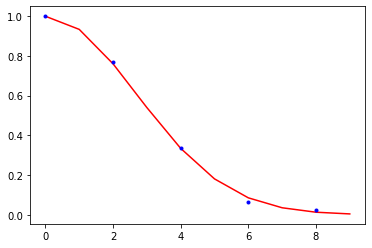

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 838
Number of inner iterations in outer iteration number 2: 289
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [26.64309473 26.65276831 26.65219529 26.65212168 26.65210496]
Observation contribution to cost function [114.2576065  114.06482139 114.06302026 114.0631556  114.06302443]
Model contribution to cost function  [105.76500306 105.90733363 105.90968017 105.90961243 105.90976621]
The values of the cost function total [246.66570429 246.62492333 246.62489572 246.62488971 246.6248956 ]
RMS between background/truth and analysis/truth [0.32976748 0.1693551 ]
New estimate for variance coming from assimilation window 5: 0.03886143217047362
New estimate for correlation length coming from assimilation window 5: 2.3640955651002824


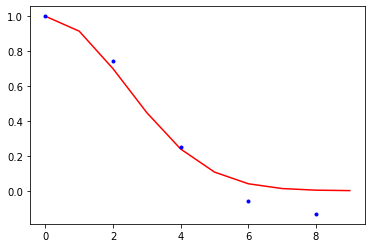

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 792
Number of inner iterations in outer iteration number 2: 265
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [35.28185839 35.18009548 35.18028334 35.18023943 35.18017227]
Observation contribution to cost function [131.40441328 131.15158458 131.15001653 131.15015256 131.15032866]
Model contribution to cost function  [109.54193016 109.66496865 109.66638195 109.66628444 109.66617319]
The values of the cost function total [276.22820183 275.99664871 275.99668183 275.99667643 275.99667412]
RMS between background/truth and analysis/truth [0.37108232 0.17741792]
New estimate for variance coming from assimilation window 6: 0.04232859565470219
New estimate for correlation length coming from assimilation window 6: 2.353363417329936


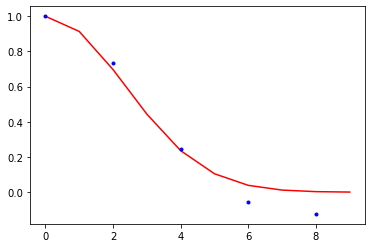

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 751
Number of inner iterations in outer iteration number 2: 339
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [38.69670663 38.29632013 38.30189202 38.30190216 38.30182965]
Observation contribution to cost function [120.75052181 120.08526611 120.08086676 120.08066965 120.07934135]
Model contribution to cost function  [110.06235636 110.83189505 110.83088042 110.83106491 110.83247057]
The values of the cost function total [269.5095848  269.21348129 269.21363921 269.21363671 269.21364158]
RMS between background/truth and analysis/truth [0.37741297 0.18786376]
New estimate for variance coming from assimilation window 7: 0.05084559438531074
New estimate for correlation length coming from assimilation window 7: 2.7856909960801834


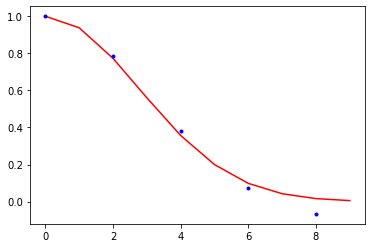

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 755
Number of inner iterations in outer iteration number 2: 281
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [42.15392676 42.3528616  42.35323316 42.35279757 42.35267646]
Observation contribution to cost function [120.07033998 119.98240897 119.97736792 119.97835539 119.97807487]
Model contribution to cost function  [115.4211058  115.3695604  115.37422058 115.37367173 115.3740739 ]
The values of the cost function total [277.64537253 277.70483096 277.70482167 277.7048247  277.70482523]
RMS between background/truth and analysis/truth [0.38359113 0.19316055]
New estimate for variance coming from assimilation window 8: 0.04748280915827376
New estimate for correlation length coming from assimilation window 8: 3.050221996587706


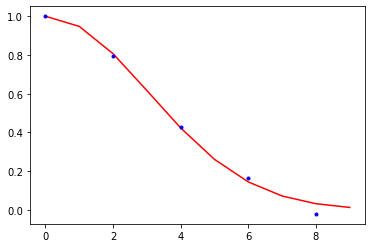

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 780
Number of inner iterations in outer iteration number 2: 265
Number of inner iterations in outer iteration number 3: 16
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [55.06731738 55.32999469 55.33028849 55.32995424 55.32987866]
Observation contribution to cost function [140.2402094  140.50826575 140.50419826 140.50627184 140.50482745]
Model contribution to cost function  [122.58404584 122.48957779 122.49333647 122.49160108 122.49311966]
The values of the cost function total [317.89157262 318.32783824 318.32782322 318.32782715 318.32782577]
RMS between background/truth and analysis/truth [0.37614892 0.21002573]
New estimate for variance coming from assimilation window 9: 0.04634283149801241
New estimate for correlation length coming from assimilation window 9: 2.9256914484903933


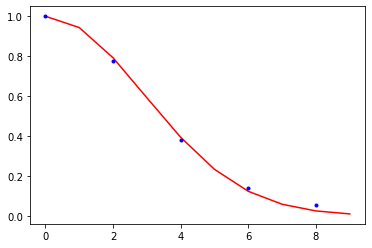

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 786
Number of inner iterations in outer iteration number 2: 339
Number of inner iterations in outer iteration number 3: 20
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [79.61096121 79.80785223 79.80275322 79.80251974 79.80225756]
Observation contribution to cost function [149.1066084  148.72046449 148.71589186 148.71896457 148.71683222]
Model contribution to cost function  [156.62091213 155.369407   155.37911278 155.37628097 155.37867661]
The values of the cost function total [385.33848175 383.89772372 383.89775785 383.89776528 383.89776639]
RMS between background/truth and analysis/truth [0.43222161 0.22090067]
New estimate for variance coming from assimilation window 10: 0.06014005716070675
New estimate for correlation length coming from assimilation window 10: 2.7950190347783677


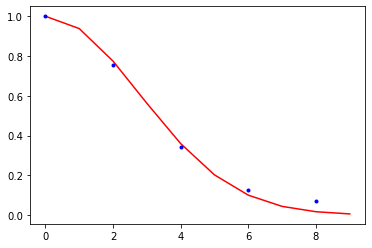

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 792
Number of inner iterations in outer iteration number 2: 305
Number of inner iterations in outer iteration number 3: 20
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [77.77149047 77.75480264 77.7541238  77.75387461 77.75375766]
Observation contribution to cost function [141.89047783 142.23810423 142.23125784 142.23296986 142.23202223]
Model contribution to cost function  [125.22060096 124.94243709 124.95000344 124.94854003 124.94960015]
The values of the cost function total [344.88256927 344.93534396 344.93538508 344.9353845  344.93538003]
RMS between background/truth and analysis/truth [0.40987153 0.23946146]
New estimate for variance coming from assimilation window 11: 0.04149792998396428
New estimate for correlation length coming from assimilation window 11: 2.689560109615788


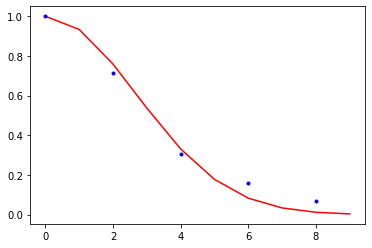

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 754
Number of inner iterations in outer iteration number 2: 291
Number of inner iterations in outer iteration number 3: 29
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [82.3962247  82.75961297 82.75611383 82.75506367 82.75484848]
Observation contribution to cost function [167.33878919 168.1448985  168.13558934 168.1371593  168.13817298]
Model contribution to cost function  [127.03899952 126.3418551  126.35498766 126.35447654 126.35367197]
The values of the cost function total [376.77401341 377.24636658 377.24669083 377.2466995  377.24669343]
RMS between background/truth and analysis/truth [0.41779166 0.261456  ]
New estimate for variance coming from assimilation window 12: 0.041258798222994886
New estimate for correlation length coming from assimilation window 12: 2.7747585388217324


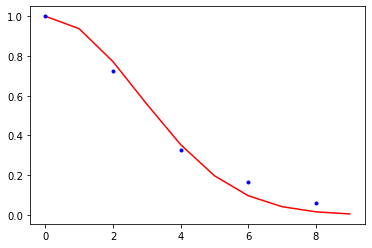

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 766
Number of inner iterations in outer iteration number 2: 333
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [100.26642435 100.50541689 100.50631248 100.50471999 100.50437006]
Observation contribution to cost function [147.17191725 147.6148934  147.59768429 147.60072662 147.59921861]
Model contribution to cost function  [156.99622664 155.16327387 155.17970932 155.17826775 155.18012517]
The values of the cost function total [404.43456824 403.28358415 403.28370609 403.28371435 403.28371385]
RMS between background/truth and analysis/truth [0.50549393 0.28041692]
New estimate for variance coming from assimilation window 13: 0.07125462267790757
New estimate for correlation length coming from assimilation window 13: 3.270260339587262


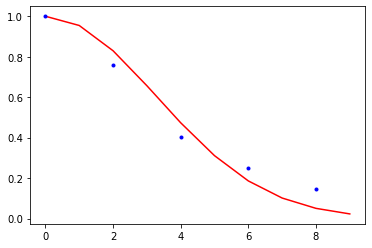

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 792
Number of inner iterations in outer iteration number 2: 323
Number of inner iterations in outer iteration number 3: 31
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [112.26605979 112.31544122 112.28304663 112.27963765 112.27880266]
Observation contribution to cost function [164.59012657 163.84780599 163.84389392 163.84711274 163.84791206]
Model contribution to cost function  [144.14395284 143.77913245 143.81424168 143.81443181 143.81446175]
The values of the cost function total [421.00013921 419.94237966 419.94118223 419.9411822  419.94117647]
RMS between background/truth and analysis/truth [0.48879828 0.30603807]
New estimate for variance coming from assimilation window 14: 0.0545244091999191
New estimate for correlation length coming from assimilation window 14: 2.3183661682644088


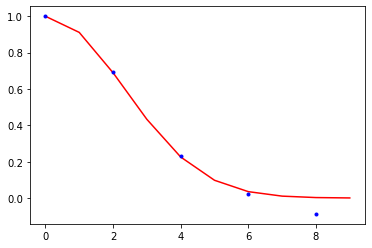

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 800
Number of inner iterations in outer iteration number 2: 345
Number of inner iterations in outer iteration number 3: 54
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [120.03247356 120.57096394 120.51020677 120.50817818 120.50839018]
Observation contribution to cost function [163.80554038 164.39192567 164.41329975 164.41728147 164.41629477]
Model contribution to cost function  [141.59699192 140.68942004 140.73038828 140.72847255 140.72923566]
The values of the cost function total [425.43500585 425.65230965 425.65389479 425.6539322  425.6539206 ]
RMS between background/truth and analysis/truth [0.55738013 0.33597858]
New estimate for variance coming from assimilation window 15: 0.05785089761456397
New estimate for correlation length coming from assimilation window 15: 2.9260510656601078


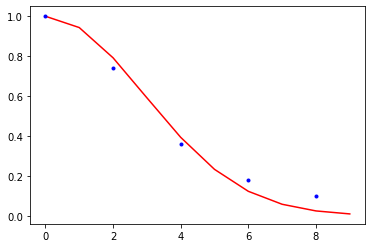

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 810
Number of inner iterations in outer iteration number 2: 373
Number of inner iterations in outer iteration number 3: 64
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [144.43506292 145.04708499 144.98441608 144.98229055 144.98290452]
Observation contribution to cost function [195.07406398 195.11792891 195.12491287 195.13062735 195.12918406]
Model contribution to cost function  [176.97848287 175.65462786 175.71109361 175.707557   175.7083735 ]
The values of the cost function total [516.48760977 515.81964176 515.82042257 515.8204749  515.82046208]
RMS between background/truth and analysis/truth [0.56624658 0.36094617]
New estimate for variance coming from assimilation window 16: 0.061468578369867764
New estimate for correlation length coming from assimilation window 16: 2.4748361668512913


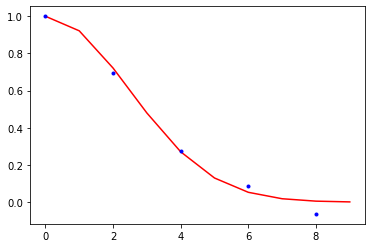

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 821
Number of inner iterations in outer iteration number 2: 373
Number of inner iterations in outer iteration number 3: 75
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [163.65083954 164.74364471 164.66930613 164.66861709 164.66933259]
Observation contribution to cost function [181.56199102 181.24393575 181.2653503  181.27077883 181.26987884]
Model contribution to cost function  [180.2894728  176.68270774 176.73734799 176.73273125 176.73289218]
The values of the cost function total [525.50230335 522.67028819 522.67200441 522.67212718 522.67210361]
RMS between background/truth and analysis/truth [0.62110267 0.3875472 ]
New estimate for variance coming from assimilation window 17: 0.0753880596210224
New estimate for correlation length coming from assimilation window 17: 3.0829615012428877


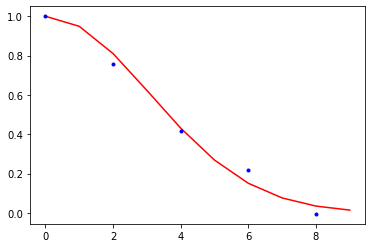

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 856
Number of inner iterations in outer iteration number 2: 397
Number of inner iterations in outer iteration number 3: 50
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [176.86145632 177.35994567 177.322337   177.31812027 177.31861317]
Observation contribution to cost function [191.30663164 190.29245482 190.2890801  190.29864058 190.29808965]
Model contribution to cost function  [166.44759879 165.07370034 165.11522976 165.10998759 165.11003339]
The values of the cost function total [534.61568674 532.72610083 532.72664685 532.72674844 532.7267362 ]
RMS between background/truth and analysis/truth [0.62387062 0.43083921]
New estimate for variance coming from assimilation window 18: 0.05616448006353704
New estimate for correlation length coming from assimilation window 18: 2.1122845329367923


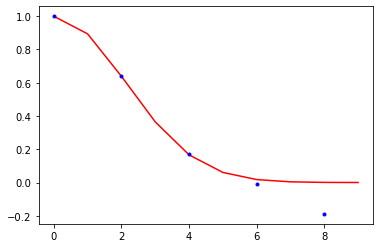

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 846
Number of inner iterations in outer iteration number 2: 453
Number of inner iterations in outer iteration number 3: 61
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [169.11769535 168.24469341 168.21589421 168.21314609 168.21338831]
Observation contribution to cost function [175.22306456 173.00696141 172.99076104 172.99462671 172.99319864]
Model contribution to cost function  [175.87455824 171.93530941 171.98057323 171.97947356 171.98065957]
The values of the cost function total [520.21531815 513.18696423 513.18722848 513.18724635 513.18724652]
RMS between background/truth and analysis/truth [0.65354675 0.47426966]
New estimate for variance coming from assimilation window 19: 0.0697688246800472
New estimate for correlation length coming from assimilation window 19: 2.3374427354424947


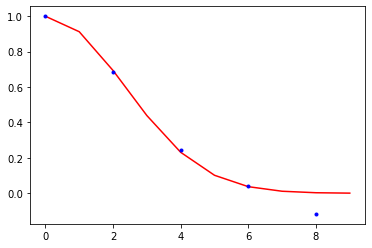

In [10]:
rd.seed(11)

win     = 20     # number of assimilation windows 
nt      = 5      # size of assimilation window
nr      = 200    # size spatial grid
dt      = 0.01   # temporal step size
mt      = 5      # number of observations in time
mr      = 100    # number of observations in space
dmt     = 1      # number of temporal gridpoints between observations
dmr     = 2      # number of spatial gridpoints between  observations
p       = 10 



b_var       = 0.01
b_len       = 0
d_var       = 0.01
q_var_truth = 0.05
l_truth     = 3



# Lorenz96 model set up
F         = 8.0
my_Lorenz = Lorenz96(nr,F,dt)


# initial condition 
u0     = F*np.ones(nr)
u0[0] += 0.01
for n in range(10000):
    u0 = my_Lorenz.step_rk4(u0) 



u_analysis, u_back, u_truth, var, length,  meanvar, meanlen, H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)


estimated variances [0.04179036 0.05885559 0.04365063 0.05110303 0.05043875 0.03886143
 0.0423286  0.05084559 0.04748281 0.04634283 0.06014006 0.04149793
 0.0412588  0.07125462 0.05452441 0.0578509  0.06146858 0.07538806
 0.05616448 0.06976882]
estimated correlation length [3.03063029 3.21045297 2.69514746 3.50261228 2.70164749 2.36409557
 2.35336342 2.785691   3.050222   2.92569145 2.79501903 2.68956011
 2.77475854 3.27026034 2.31836617 2.92605107 2.47483617 3.0829615
 2.11228453 2.33744274]


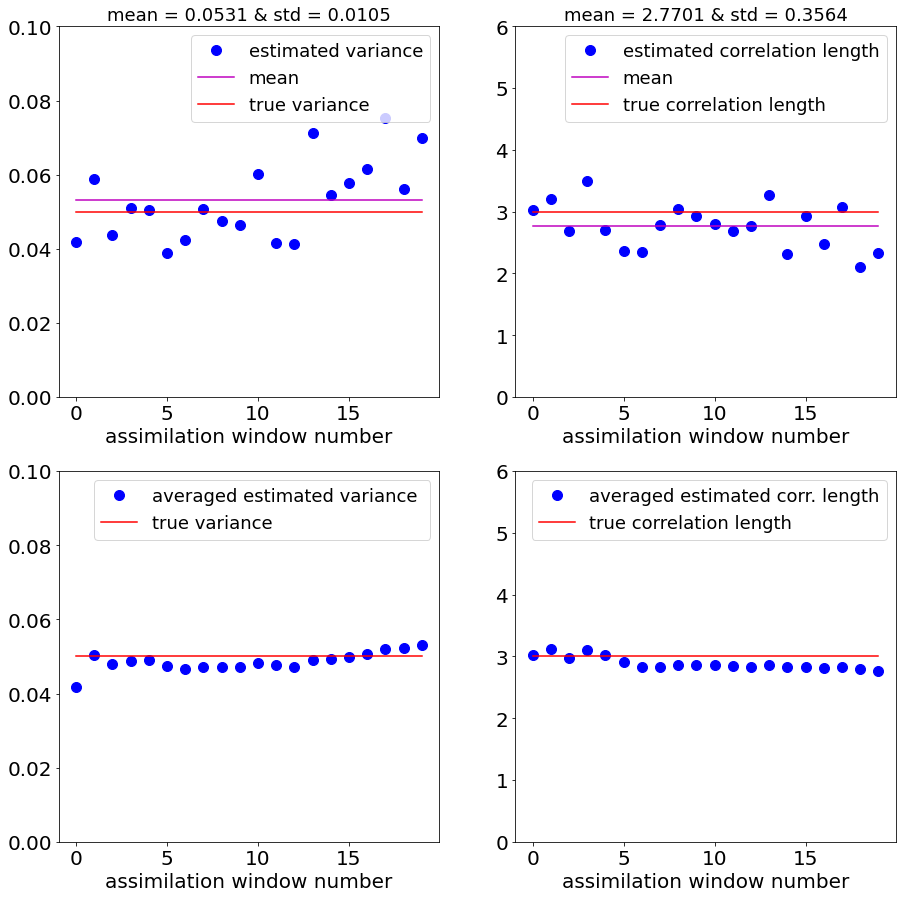

In [11]:
q_estimate_analysis(win,var,length,meanvar,meanlen,q_var_truth, l_truth)

### 2.3 Experiment 3: partial observations in time

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 37
Number of inner iterations in outer iteration number 2: 13
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [123.17427651 123.21253291 123.21028768 123.21446346 123.21114552]
Observation contribution to cost function [364.74787841 364.71756651 364.72150836 364.71125058 364.71710224]
Model contribution to cost function  [592.82678214 592.61962542 592.61792728 592.62400912 592.62146572]
The values of the cost function total [1080.74893706 1080.54972484 1080.54972332 1080.54972316 1080.54971348]
RMS between background/truth and analysis/truth [0.35479109 0.13880216]
New estimate for variance coming from assimilation window 0: 0.041426181694493996
New estimate for correlation length coming from assimilation window 0: 3.2268787027692007


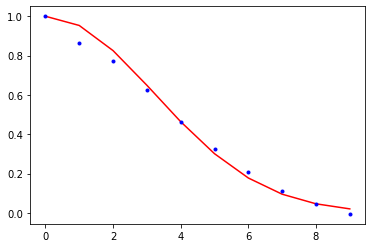

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 925
Number of inner iterations in outer iteration number 2: 419
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [41.22117644 41.18388285 41.18574276 41.18556701 41.18543182]
Observation contribution to cost function [174.36488763 174.6487599  174.64730606 174.6479726  174.64837412]
Model contribution to cost function  [95.88996773 95.73452284 95.73411849 95.73362274 95.73335232]
The values of the cost function total [311.4760318  311.56716559 311.56716731 311.56716236 311.56715826]
RMS between background/truth and analysis/truth [0.34231605 0.10286895]
New estimate for variance coming from assimilation window 1: 0.056111360041258385
New estimate for correlation length coming from assimilation window 1: 3.7150789686873775


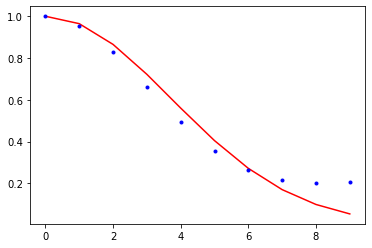

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 539
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [30.13625822 30.13329658 30.13435187 30.13430851 30.13430157]
Observation contribution to cost function [167.3477977  166.82952712 166.82719585 166.82748336 166.82693228]
Model contribution to cost function  [85.75069025 86.06658976 86.0678772  86.06763125 86.06819301]
The values of the cost function total [283.23474618 283.02941346 283.02942491 283.02942312 283.02942686]
RMS between background/truth and analysis/truth [0.30453765 0.09705028]
New estimate for variance coming from assimilation window 2: 0.046776192615153867
New estimate for correlation length coming from assimilation window 2: 2.9226929193162032


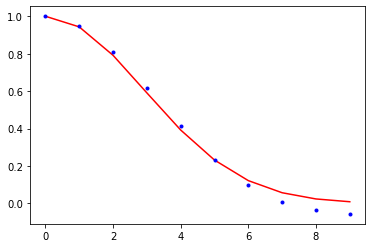

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 423
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [26.6322112  26.49065643 26.4916368  26.49158138 26.49153542]
Observation contribution to cost function [159.00099837 158.93205316 158.93081225 158.93107583 158.93123596]
Model contribution to cost function  [80.91865814 80.64440416 80.64468305 80.64447853 80.64436716]
The values of the cost function total [266.5518677  266.06711374 266.06713211 266.06713574 266.06713854]
RMS between background/truth and analysis/truth [0.30527332 0.10448766]
New estimate for variance coming from assimilation window 3: 0.04641913429394799
New estimate for correlation length coming from assimilation window 3: 3.388583820397612


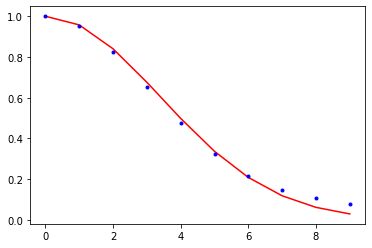

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 497
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [26.69253256 26.73152119 26.73273399 26.73264242 26.73257418]
Observation contribution to cost function [149.01061686 148.50857142 148.50615359 148.50654759 148.50684034]
Model contribution to cost function  [91.7974083  91.86641412 91.86761284 91.86730959 91.8670853 ]
The values of the cost function total [267.50055771 267.10650673 267.10650042 267.10649959 267.10649981]
RMS between background/truth and analysis/truth [0.32065632 0.09567549]
New estimate for variance coming from assimilation window 4: 0.055438437686574506
New estimate for correlation length coming from assimilation window 4: 3.086360225448965


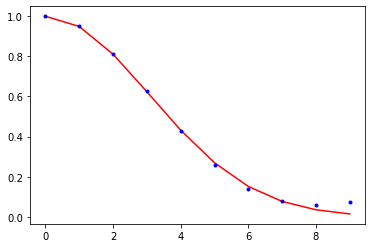

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 465
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [30.02753827 30.06411205 30.06522083 30.06514104 30.06507571]
Observation contribution to cost function [143.88643005 144.16863738 144.16574803 144.16604257 144.16623619]
Model contribution to cost function  [77.25676736 76.76397287 76.76574277 76.76552171 76.76538829]
The values of the cost function total [251.17073568 250.99672229 250.99671163 250.99670533 250.99670019]
RMS between background/truth and analysis/truth [0.28582395 0.09645402]
New estimate for variance coming from assimilation window 5: 0.045597895833692684
New estimate for correlation length coming from assimilation window 5: 3.027971633944266


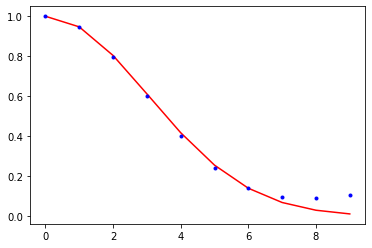

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 460
Number of inner iterations in outer iteration number 3: 6
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [27.84871193 27.89101405 27.89203871 27.89194749 27.89191023]
Observation contribution to cost function [166.2474026  166.2457538  166.24234006 166.2427788  166.24401111]
Model contribution to cost function  [79.46154264 79.71782689 79.72022164 79.71987242 79.7186818 ]
The values of the cost function total [273.55765718 273.85459474 273.85460041 273.8545987  273.85460313]
RMS between background/truth and analysis/truth [0.29493624 0.10390968]
New estimate for variance coming from assimilation window 6: 0.047969896551310925
New estimate for correlation length coming from assimilation window 6: 2.934699432693799


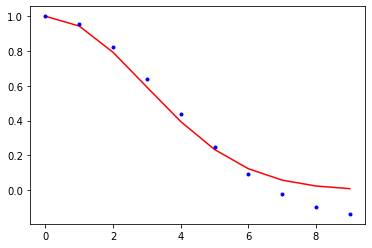

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 440
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.68341552 27.75146286 27.75205094 27.75197836 27.75193164]
Observation contribution to cost function [135.04407984 135.2435211  135.2418554  135.24231335 135.24255203]
Model contribution to cost function  [78.89539554 78.23868648 78.23974433 78.23935297 78.23915575]
The values of the cost function total [241.6228909  241.23367043 241.23365066 241.23364468 241.23363942]
RMS between background/truth and analysis/truth [0.28760821 0.09679295]
New estimate for variance coming from assimilation window 7: 0.0428694152618891
New estimate for correlation length coming from assimilation window 7: 2.8954472628832013


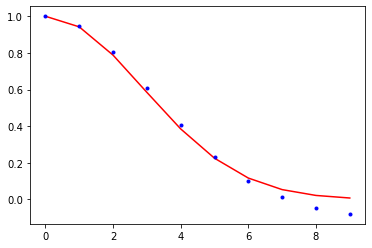

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 415
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.30445066 27.26007034 27.26086843 27.26080183 27.26073383]
Observation contribution to cost function [137.19860906 136.96453925 136.96292304 136.96327833 136.96348875]
Model contribution to cost function  [79.07308331 78.89269073 78.89349762 78.89320557 78.89306172]
The values of the cost function total [243.57614303 243.11730032 243.11728909 243.11728573 243.1172843 ]
RMS between background/truth and analysis/truth [0.31894668 0.10490086]
New estimate for variance coming from assimilation window 8: 0.04980533806170097
New estimate for correlation length coming from assimilation window 8: 3.3552550596593336


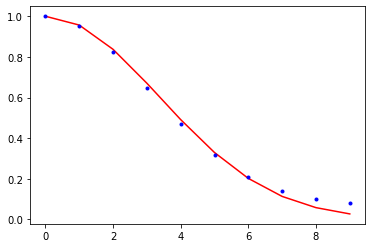

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 427
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [30.85851249 30.88124841 30.88258568 30.88248572 30.88239348]
Observation contribution to cost function [154.91356807 154.62190576 154.61968233 154.61995562 154.62018171]
Model contribution to cost function  [83.10960728 83.00712441 83.00800885 83.00783456 83.00770098]
The values of the cost function total [268.88168784 268.51027859 268.51027685 268.5102759  268.51027617]
RMS between background/truth and analysis/truth [0.32404912 0.1137084 ]
New estimate for variance coming from assimilation window 9: 0.04929708514260128
New estimate for correlation length coming from assimilation window 9: 3.352974788403713


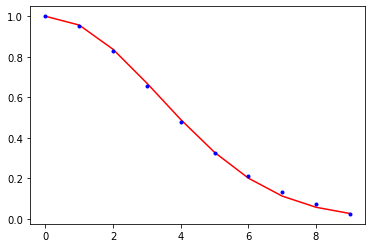

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 501
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [34.38250802 34.43885249 34.44021557 34.44009976 34.44001275]
Observation contribution to cost function [144.69592491 144.90946668 144.90658866 144.90709913 144.90735437]
Model contribution to cost function  [101.80186856 100.64932649 100.65085054 100.65045415 100.65028474]
The values of the cost function total [280.88030149 279.99764565 279.99765477 279.99765303 279.99765186]
RMS between background/truth and analysis/truth [0.34144424 0.09727469]
New estimate for variance coming from assimilation window 10: 0.06339776120985013
New estimate for correlation length coming from assimilation window 10: 3.220451350545762


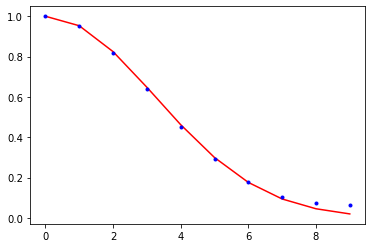

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 511
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [33.42863999 33.18766816 33.1894667  33.1893541  33.18925066]
Observation contribution to cost function [157.94462123 158.48244094 158.47890775 158.47968321 158.48019421]
Model contribution to cost function  [85.75037048 85.61448153 85.61620721 85.61553774 85.61512502]
The values of the cost function total [277.12363169 277.28459062 277.28458165 277.28457506 277.28456989]
RMS between background/truth and analysis/truth [0.29676103 0.09889709]
New estimate for variance coming from assimilation window 11: 0.042265353729613965
New estimate for correlation length coming from assimilation window 11: 2.6449644383072397


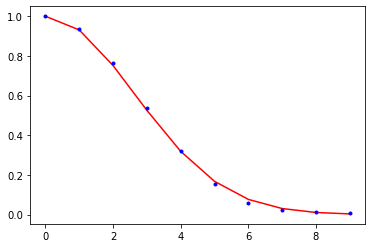

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 465
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.57588372 27.6380753  27.63964782 27.63958305 27.63949723]
Observation contribution to cost function [161.68609012 161.57999142 161.57792012 161.5781714  161.57841099]
Model contribution to cost function  [100.82487114 100.64513466 100.64561832 100.64542843 100.64527253]
The values of the cost function total [290.08684497 289.86320137 289.86318627 289.86318289 289.86318075]
RMS between background/truth and analysis/truth [0.35429189 0.09465624]
New estimate for variance coming from assimilation window 12: 0.06027015466762723
New estimate for correlation length coming from assimilation window 12: 3.2711131162143063


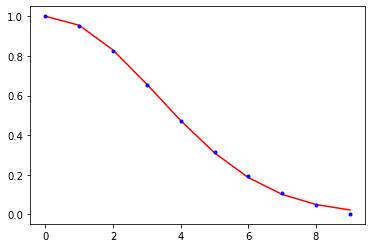

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 401
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [26.33781901 26.35223809 26.3533833  26.35328899 26.35320456]
Observation contribution to cost function [162.23578177 162.4049974  162.40349955 162.40370144 162.4038465 ]
Model contribution to cost function  [69.60659802 69.34419789 69.3445444  69.34443596 69.34437484]
The values of the cost function total [258.1801988  258.10143338 258.10142725 258.10142639 258.1014259 ]
RMS between background/truth and analysis/truth [0.28516837 0.09887405]
New estimate for variance coming from assimilation window 13: 0.03914455525554626
New estimate for correlation length coming from assimilation window 13: 2.888035668965946


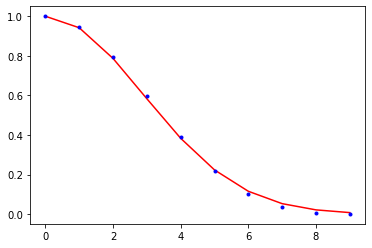

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 447
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [23.79379516 23.7537739  23.75529757 23.75520332 23.75512794]
Observation contribution to cost function [157.70508118 157.57475696 157.57151201 157.57193787 157.57227901]
Model contribution to cost function  [77.3384488  77.44127522 77.44301034 77.44267873 77.44241456]
The values of the cost function total [258.83732513 258.76980608 258.76981992 258.76981992 258.7698215 ]
RMS between background/truth and analysis/truth [0.29386747 0.09683595]
New estimate for variance coming from assimilation window 14: 0.04414334424740923
New estimate for correlation length coming from assimilation window 14: 3.2918075772058204


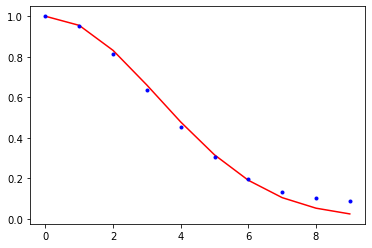

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 455
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [26.45742635 26.47767761 26.47958802 26.47947022 26.47935847]
Observation contribution to cost function [164.20536409 164.11320089 164.10986892 164.11019365 164.1104698 ]
Model contribution to cost function  [79.70255675 79.66837736 79.66977999 79.66957168 79.6694078 ]
The values of the cost function total [270.36534719 270.25925586 270.25923694 270.25923556 270.25923607]
RMS between background/truth and analysis/truth [0.30892805 0.10402592]
New estimate for variance coming from assimilation window 15: 0.044520513558705496
New estimate for correlation length coming from assimilation window 15: 2.8615625979512362


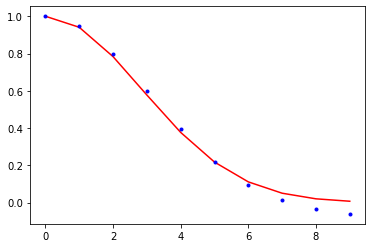

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 459
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.46031411 27.5066813  27.50735064 27.50729001 27.5072474 ]
Observation contribution to cost function [143.20239448 142.95458487 142.95259745 142.95293298 142.95319307]
Model contribution to cost function  [88.5390486  88.22332091 88.22463484 88.22435966 88.22414188]
The values of the cost function total [259.20175719 258.68458708 258.68458293 258.68458265 258.68458235]
RMS between background/truth and analysis/truth [0.31812651 0.09483566]
New estimate for variance coming from assimilation window 16: 0.04527895745686387
New estimate for correlation length coming from assimilation window 16: 2.447672600015884


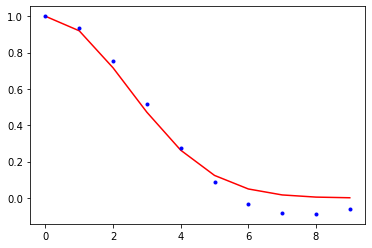

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 461
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [28.3245752  28.36976499 28.37086573 28.37074594 28.37065706]
Observation contribution to cost function [153.41534381 153.07894805 153.07562265 153.07623506 153.07663861]
Model contribution to cost function  [85.54576223 85.68162734 85.68384954 85.68335156 85.68303252]
The values of the cost function total [267.28568124 267.13034038 267.13033792 267.13033256 267.13032818]
RMS between background/truth and analysis/truth [0.29015505 0.09777873]
New estimate for variance coming from assimilation window 17: 0.045182718894769755
New estimate for correlation length coming from assimilation window 17: 2.3109186801939177


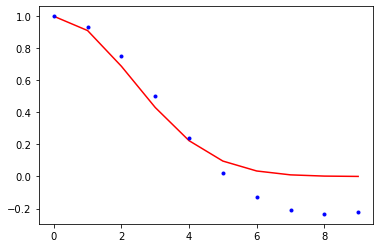

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 427
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [29.24076226 29.23921521 29.24040496 29.24029029 29.24020836]
Observation contribution to cost function [180.44086191 180.72348786 180.72077364 180.72123497 180.72154521]
Model contribution to cost function  [80.31172237 80.32662866 80.32814903 80.32779867 80.32756865]
The values of the cost function total [289.99334654 290.28933173 290.28932763 290.28932392 290.28932223]
RMS between background/truth and analysis/truth [0.31737479 0.10767789]
New estimate for variance coming from assimilation window 18: 0.04744906042875028
New estimate for correlation length coming from assimilation window 18: 2.7858082176480163


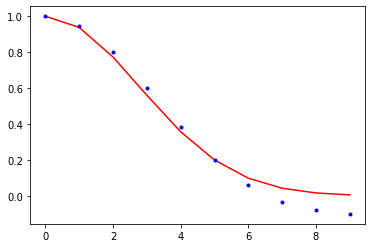

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 1000
Number of inner iterations in outer iteration number 2: 435
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [28.24030403 28.28529312 28.28709128 28.28692858 28.28681015]
Observation contribution to cost function [146.33701428 146.01370622 146.01110507 146.01156891 146.01186393]
Model contribution to cost function  [93.72945532 93.68438072 93.68517967 93.68487714 93.68469965]
The values of the cost function total [268.30677363 267.98338006 267.98337602 267.98337463 267.98337374]
RMS between background/truth and analysis/truth [0.30676395 0.09944846]
New estimate for variance coming from assimilation window 19: 0.05214096743231028
New estimate for correlation length coming from assimilation window 19: 2.807707897970711


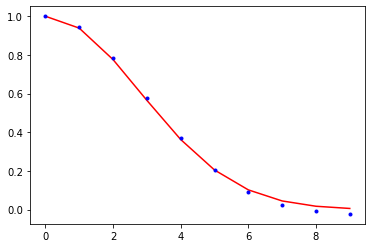

In [3]:
rd.seed(11)

win     = 20     # number of assimilation windows 
nt      = 5      # size of assimilation window
nr      = 200    # size spatial grid
dt      = 0.01   # temporal step size
mt      = 3      # number of observations in time
mr      = 200    # number of observations in space
dmt     = 2      # number of temporal gridpoints between observations
dmr     = 1      # number of spatial gridpoints between  observations
p       = 10 



b_var       = 0.01
b_len       = 0
d_var       = 0.01
q_var_truth = 0.05
l_truth     = 3



# Lorenz96 model set up
F         = 8.0
my_Lorenz = Lorenz96(nr,F,dt)


# initial condition 
u0     = F*np.ones(nr)
u0[0] += 0.01
for n in range(10000):
    u0 = my_Lorenz.step_rk4(u0) 



u_analysis, u_back, u_truth, var, length,  meanvar, meanlen, H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)

estimated variances [0.04142618 0.05611136 0.04677619 0.04641913 0.05543844 0.0455979
 0.0479699  0.04286942 0.04980534 0.04929709 0.06339776 0.04226535
 0.06027015 0.03914456 0.04414334 0.04452051 0.04527896 0.04518272
 0.04744906 0.05214097]
estimated correlation length [3.2268787  3.71507897 2.92269292 3.38858382 3.08636023 3.02797163
 2.93469943 2.89544726 3.35525506 3.35297479 3.22045135 2.64496444
 3.27111312 2.88803567 3.29180758 2.8615626  2.4476726  2.31091868
 2.78580822 2.8077079 ]


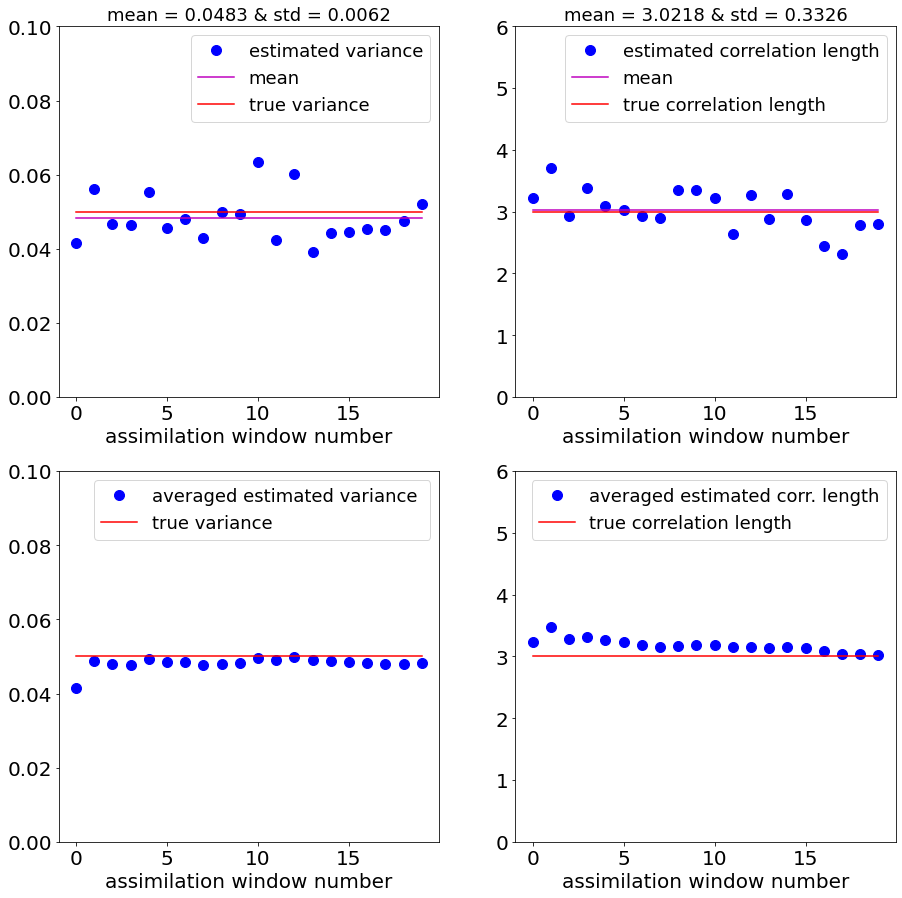

In [4]:
q_estimate_analysis(win,var,length,meanvar,meanlen,q_var_truth, l_truth)

### 2.4 Experiment 4: partial observations in time and space 

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 9
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [58.54628227 58.60947802 58.6125496  58.61348805 58.61287458]
Observation contribution to cost function [173.82112013 173.71465095 173.71180939 173.7084759  173.70970064]
Model contribution to cost function  [304.69234423 304.7156228  304.71524498 304.71764141 304.71702353]
The values of the cost function total [537.05974662 537.03975176 537.03960398 537.03960536 537.03959875]
RMS between background/truth and analysis/truth [0.35479109 0.23674072]
New estimate for variance coming from assimilation window 0: 0.04251768425329842
New estimate for correlation length coming from assimilation window 0: 3.308090624662874


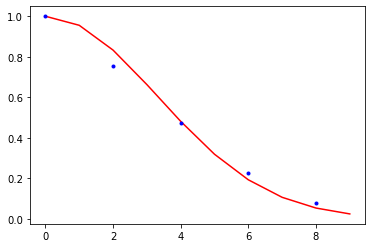

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 467
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [33.33663986 33.46606922 33.47054637 33.47046025 33.47032705]
Observation contribution to cost function [85.61324731 85.44143863 85.43218648 85.43140532 85.43283204]
Model contribution to cost function  [88.51143834 88.11247734 88.11738352 88.11824972 88.11696336]
The values of the cost function total [207.46132551 207.01998519 207.02011637 207.02011529 207.02012244]
RMS between background/truth and analysis/truth [0.44014839 0.23822073]
New estimate for variance coming from assimilation window 1: 0.05213429364960219
New estimate for correlation length coming from assimilation window 1: 3.046890753324869


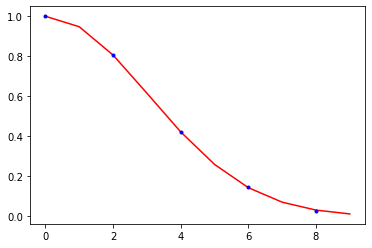

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 489
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [21.00621994 21.04040462 21.04035047 21.04028766 21.04024258]
Observation contribution to cost function [59.86205198 59.59828196 59.59568811 59.59630815 59.59662331]
Model contribution to cost function  [73.57111787 73.4043258  73.40699711 73.40643661 73.40616377]
The values of the cost function total [154.43938979 154.04301238 154.04303569 154.04303242 154.04302966]
RMS between background/truth and analysis/truth [0.3714511  0.19594769]
New estimate for variance coming from assimilation window 2: 0.047508357104506724
New estimate for correlation length coming from assimilation window 2: 3.0447826901104604


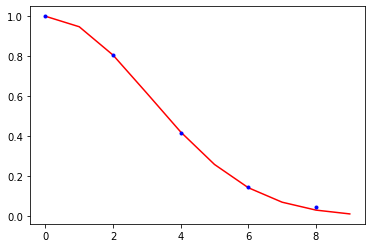

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 485
Number of inner iterations in outer iteration number 2: 193
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [31.74506135 31.76379411 31.76369652 31.76365425 31.76343952]
Observation contribution to cost function [71.4675226  71.27082675 71.26562893 71.26368793 71.26662177]
Model contribution to cost function  [82.64775795 82.39623237 82.40150058 82.4034915  82.40076482]
The values of the cost function total [185.8603419  185.43085323 185.43082603 185.43083368 185.43082611]
RMS between background/truth and analysis/truth [0.40306164 0.19029856]
New estimate for variance coming from assimilation window 3: 0.05231597379660203
New estimate for correlation length coming from assimilation window 3: 2.9462310821310638


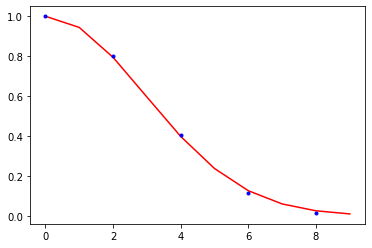

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 490
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [37.84508441 37.84645266 37.84877137 37.84868684 37.84837391]
Observation contribution to cost function [73.3011227  73.29865624 73.29471496 73.2922508  73.29547481]
Model contribution to cost function  [78.90196447 78.79490816 78.7965323  78.79908248 78.79617095]
The values of the cost function total [190.04817158 189.94001705 189.94001863 189.94002012 189.94001967]
RMS between background/truth and analysis/truth [0.35022326 0.18836643]
New estimate for variance coming from assimilation window 4: 0.043032156639565305
New estimate for correlation length coming from assimilation window 4: 2.567364922282975


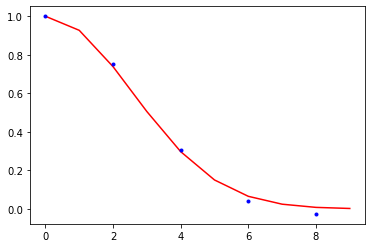

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 169
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [23.75604868 23.74079918 23.74074983 23.74049079 23.74038806]
Observation contribution to cost function [67.24625087 66.96578683 66.96287266 66.96344315 66.96301099]
Model contribution to cost function  [74.74883062 74.65396177 74.65691728 74.65660477 74.65714796]
The values of the cost function total [165.75113016 165.36054778 165.36053977 165.36053871 165.36054701]
RMS between background/truth and analysis/truth [0.35484016 0.19441077]
New estimate for variance coming from assimilation window 5: 0.0517823741219371
New estimate for correlation length coming from assimilation window 5: 2.6983163523158438


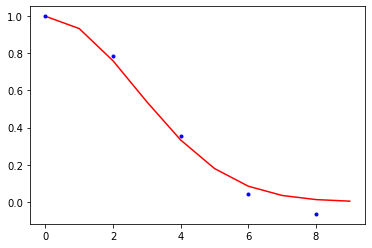

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 469
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 8
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.95873765 29.00294578 29.00389905 29.00375105 29.00372908]
Observation contribution to cost function [58.82898434 58.97469063 58.97186882 58.97321532 58.97218562]
Model contribution to cost function  [66.49843918 66.19279542 66.19467154 66.1934728  66.1945227 ]
The values of the cost function total [154.28616117 154.17043183 154.17043941 154.17043917 154.17043739]
RMS between background/truth and analysis/truth [0.33015679 0.19335164]
New estimate for variance coming from assimilation window 6: 0.0435326259498347
New estimate for correlation length coming from assimilation window 6: 2.835448021247274


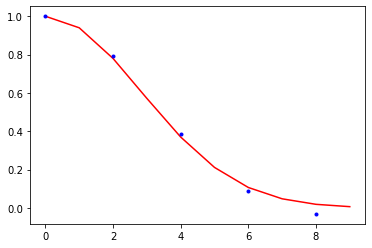

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 445
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [27.80213657 27.82522469 27.82463148 27.82465666 27.82459432]
Observation contribution to cost function [64.15571726 64.28675339 64.28789575 64.28535538 64.28803416]
Model contribution to cost function  [71.87999357 71.35747435 71.35699622 71.35951525 71.35689161]
The values of the cost function total [163.8378474  163.46945243 163.46952345 163.4695273  163.4695201 ]
RMS between background/truth and analysis/truth [0.37821979 0.19305363]
New estimate for variance coming from assimilation window 7: 0.04965219212829523
New estimate for correlation length coming from assimilation window 7: 3.1163349075481537


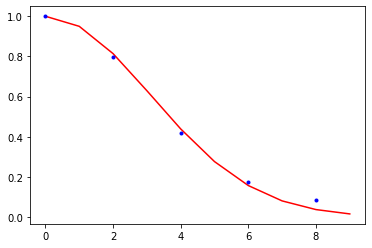

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 463
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [43.76988223 43.7432898  43.74526891 43.74517952 43.74499468]
Observation contribution to cost function [68.41355814 68.49113096 68.48651336 68.48553613 68.48710204]
Model contribution to cost function  [88.56526071 88.29602811 88.29867451 88.29974546 88.29835697]
The values of the cost function total [200.74870108 200.53044887 200.53045679 200.53046111 200.53045369]
RMS between background/truth and analysis/truth [0.4120927  0.20537051]
New estimate for variance coming from assimilation window 8: 0.059688511060845724
New estimate for correlation length coming from assimilation window 8: 3.304750791308011


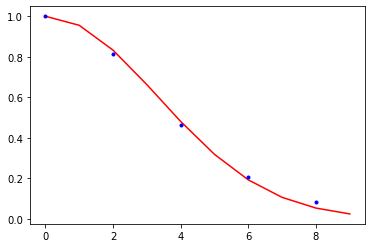

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 482
Number of inner iterations in outer iteration number 2: 177
Number of inner iterations in outer iteration number 3: 12
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [46.81521896 46.87455161 46.87682029 46.87676621 46.87665726]
Observation contribution to cost function [74.86647821 74.76066741 74.75517264 74.75462047 74.75552558]
Model contribution to cost function  [69.3385856  69.05872713 69.06198227 69.06258928 69.06179203]
The values of the cost function total [191.02028277 190.69394616 190.6939752  190.69397596 190.69397487]
RMS between background/truth and analysis/truth [0.34747129 0.20411335]
New estimate for variance coming from assimilation window 9: 0.03821202942654828
New estimate for correlation length coming from assimilation window 9: 2.4162893876860467


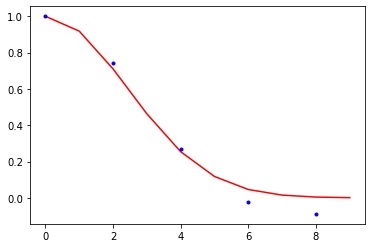

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 459
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [64.56594439 64.6311235  64.63540038 64.63496668 64.63487649]
Observation contribution to cost function [74.42218338 74.33698371 74.32746599 74.32780115 74.32873016]
Model contribution to cost function  [77.47802517 77.51573865 77.52117419 77.52127579 77.52044478]
The values of the cost function total [216.46615293 216.48384586 216.48404056 216.48404362 216.48405144]
RMS between background/truth and analysis/truth [0.43314087 0.22438024]
New estimate for variance coming from assimilation window 10: 0.06121361835412144
New estimate for correlation length coming from assimilation window 10: 3.1826002634326285


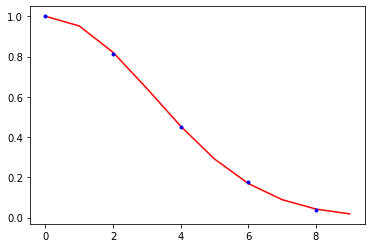

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 485
Number of inner iterations in outer iteration number 2: 227
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [71.73287561 71.71875862 71.72454071 71.72334667 71.72305186]
Observation contribution to cost function [95.45768423 93.94251113 93.92232192 93.92288958 93.92454039]
Model contribution to cost function  [80.21001937 79.10140936 79.11549247 79.11614637 79.11480111]
The values of the cost function total [247.40057921 244.76267912 244.7623551  244.76238262 244.76239336]
RMS between background/truth and analysis/truth [0.38969242 0.22224268]
New estimate for variance coming from assimilation window 11: 0.049727663250936874
New estimate for correlation length coming from assimilation window 11: 2.6827511924908145


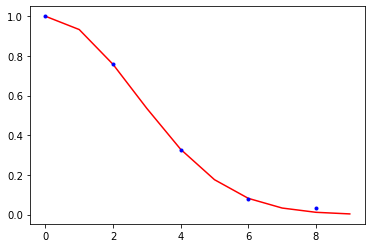

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 464
Number of inner iterations in outer iteration number 2: 203
Number of inner iterations in outer iteration number 3: 27
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [108.21153019 108.63502409 108.65693887 108.65445238 108.6541581 ]
Observation contribution to cost function [98.44766153 98.64006459 98.60960778 98.61231473 98.61029852]
Model contribution to cost function  [94.83346917 94.20433546 94.21356765 94.21342047 94.21571908]
The values of the cost function total [301.49266089 301.47942414 301.48011429 301.48018758 301.48017571]
RMS between background/truth and analysis/truth [0.44517134 0.24899071]
New estimate for variance coming from assimilation window 12: 0.05344648155880217
New estimate for correlation length coming from assimilation window 12: 2.6444116072721457


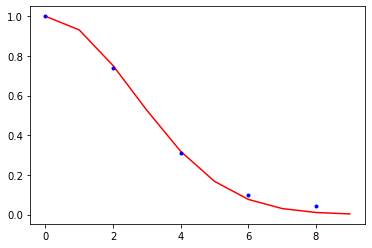

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 464
Number of inner iterations in outer iteration number 2: 199
Number of inner iterations in outer iteration number 3: 28
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [144.06453627 144.09514574 144.12449427 144.12387128 144.12320802]
Observation contribution to cost function [149.70861616 148.06078366 148.00725046 148.00880735 148.00800998]
Model contribution to cost function  [98.93005425 97.06269293 97.08537392 97.08447516 97.08595089]
The values of the cost function total [392.70320668 389.21862233 389.21711865 389.21715379 389.2171689 ]
RMS between background/truth and analysis/truth [0.45203125 0.26139473]
New estimate for variance coming from assimilation window 13: 0.05612054154871247
New estimate for correlation length coming from assimilation window 13: 2.8899192246732426


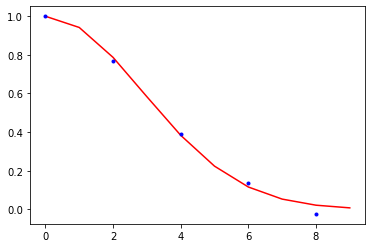

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 462
Number of inner iterations in outer iteration number 2: 191
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [126.00419276 126.00949773 126.02349687 126.02271742 126.02177311]
Observation contribution to cost function [133.23062963 133.07843952 133.04813101 133.04758207 133.05101977]
Model contribution to cost function  [98.52127981 95.5901161  95.60620958 95.60752379 95.60503817]
The values of the cost function total [357.7561022  354.67805335 354.67783746 354.67782327 354.67783105]
RMS between background/truth and analysis/truth [0.43696676 0.28128546]
New estimate for variance coming from assimilation window 14: 0.05366749887465298
New estimate for correlation length coming from assimilation window 14: 2.829081314384066


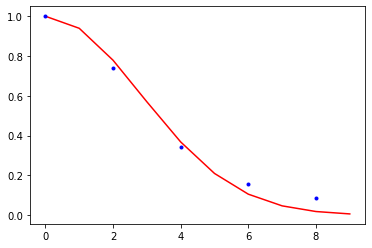

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [104.20406566 104.18557412 104.19830352 104.19679308 104.19620887]
Observation contribution to cost function [93.54469336 93.63046283 93.60757506 93.60950975 93.60989866]
Model contribution to cost function  [115.93296664 114.47835347 114.48812104 114.48769967 114.48789594]
The values of the cost function total [313.68172566 312.29439043 312.29399962 312.2940025  312.29400347]
RMS between background/truth and analysis/truth [0.48736258 0.28784529]
New estimate for variance coming from assimilation window 15: 0.08042751230219099
New estimate for correlation length coming from assimilation window 15: 2.989266120184887


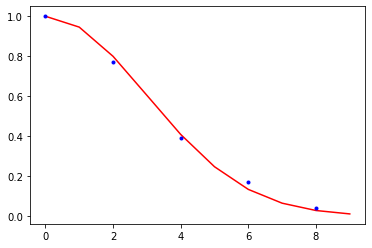

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [91.32366996 91.17088424 91.18027544 91.17766398 91.17583805]
Observation contribution to cost function [105.62651902 105.87082341 105.84462884 105.84789735 105.85033854]
Model contribution to cost function  [96.89440793 95.01728309 95.03362936 95.03295997 95.03233976]
The values of the cost function total [293.84459691 292.05899074 292.05853365 292.0585213  292.05851636]
RMS between background/truth and analysis/truth [0.46232828 0.31654457]
New estimate for variance coming from assimilation window 16: 0.04616556830542916
New estimate for correlation length coming from assimilation window 16: 2.51751918726393


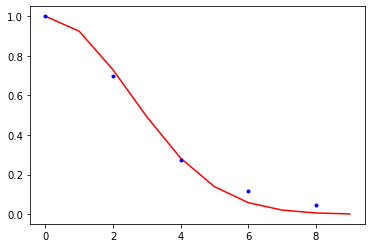

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 488
Number of inner iterations in outer iteration number 2: 251
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [137.37356529 137.54867902 137.5702002  137.56833233 137.5675226 ]
Observation contribution to cost function [146.45493711 147.91733654 147.86288527 147.86457425 147.86257816]
Model contribution to cost function  [118.31502656 115.65149204 115.68315359 115.68333782 115.68614013]
The values of the cost function total [402.14352896 401.11750759 401.11623905 401.1162444  401.11624089]
RMS between background/truth and analysis/truth [0.52783221 0.3418568 ]
New estimate for variance coming from assimilation window 17: 0.06385041986627794
New estimate for correlation length coming from assimilation window 17: 3.3082574621759746


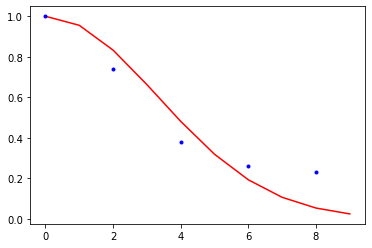

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 478
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 26
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [171.9779566  171.18033579 171.20181948 171.19700359 171.19539869]
Observation contribution to cost function [163.6647129  162.91229574 162.85490184 162.8590226  162.86106167]
Model contribution to cost function  [105.33708992 105.72742551 105.7616896  105.76240589 105.7619704 ]
The values of the cost function total [440.97975942 439.82005704 439.81841091 439.81843208 439.81843077]
RMS between background/truth and analysis/truth [0.54501628 0.37911275]
New estimate for variance coming from assimilation window 18: 0.05946231055214313
New estimate for correlation length coming from assimilation window 18: 2.496593970246349


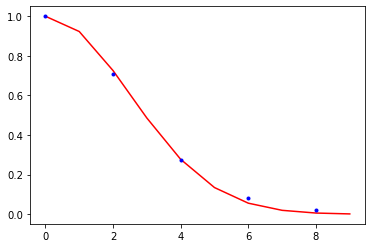

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 486
Number of inner iterations in outer iteration number 2: 235
Number of inner iterations in outer iteration number 3: 37
Number of inner iterations in outer iteration number 4: 11
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [243.57203842 242.3015546  242.30598725 242.29630224 242.29486841]
Observation contribution to cost function [186.75428661 186.7491392  186.68557622 186.69196678 186.69283683]
Model contribution to cost function  [122.72533479 119.71861176 119.76967376 119.77291636 119.77347332]
The values of the cost function total [553.05165982 548.76930556 548.76123724 548.76118539 548.76117856]
RMS between background/truth and analysis/truth [0.56613381 0.38604621]
New estimate for variance coming from assimilation window 19: 0.0679726975378383
New estimate for correlation length coming from assimilation window 19: 2.8340759360161485


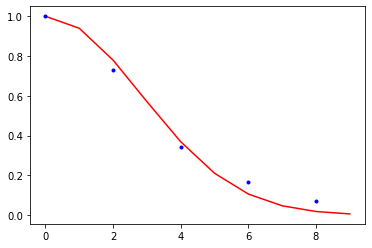

In [5]:
rd.seed(11)

win     = 20     # number of assimilation windows 
nt      = 5      # size of assimilation window
nr      = 200    # size spatial grid
dt      = 0.01   # temporal step size
mt      = 3      # number of observations in time
mr      = 100    # number of observations in space
dmt     = 2      # number of temporal gridpoints between observations
dmr     = 2      # number of spatial gridpoints between  observations
p       = 10 



b_var       = 0.01
b_len       = 0
d_var       = 0.01
q_var_truth = 0.05
l_truth     = 3



# Lorenz96 model set up
F         = 8.0
my_Lorenz = Lorenz96(nr,F,dt)


# initial condition 
u0     = F*np.ones(nr)
u0[0] += 0.01
for n in range(10000):
    u0 = my_Lorenz.step_rk4(u0) 



u_analysis, u_back, u_truth, var, length,  meanvar, meanlen, H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)


estimated variances [0.04251768 0.05213429 0.04750836 0.05231597 0.04303216 0.05178237
 0.04353263 0.04965219 0.05968851 0.03821203 0.06121362 0.04972766
 0.05344648 0.05612054 0.0536675  0.08042751 0.04616557 0.06385042
 0.05946231 0.0679727 ]
estimated correlation length [3.30809062 3.04689075 3.04478269 2.94623108 2.56736492 2.69831635
 2.83544802 3.11633491 3.30475079 2.41628939 3.18260026 2.68275119
 2.64441161 2.88991922 2.82908131 2.98926612 2.51751919 3.30825746
 2.49659397 2.83407594]


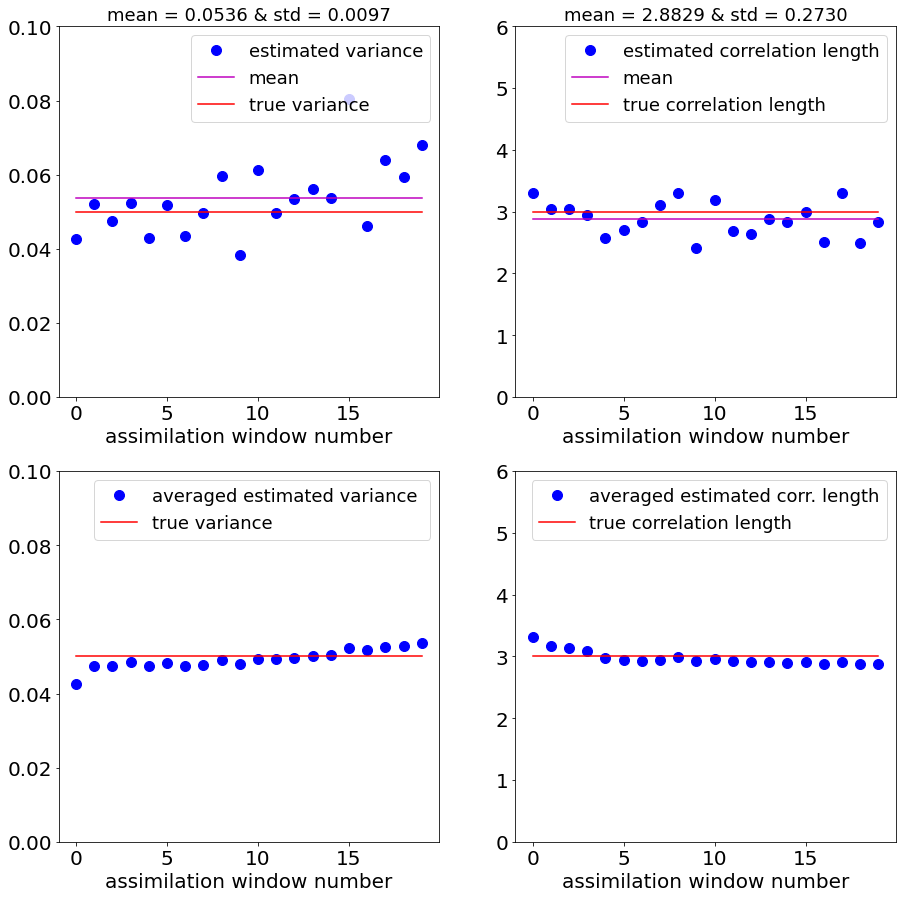

In [6]:
q_estimate_analysis(win,var,length,meanvar,meanlen,q_var_truth, l_truth)

### 2.5 Experiment 5: partial observations in time and space, structured B matrix


ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 9
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [58.54628227 58.60947802 58.6125496  58.61348805 58.61287458]
Observation contribution to cost function [173.82112013 173.71465095 173.71180939 173.7084759  173.70970064]
Model contribution to cost function  [304.69234423 304.7156228  304.71524498 304.71764141 304.71702353]
The values of the cost function total [537.05974662 537.03975176 537.03960398 537.03960536 537.03959875]
RMS between background/truth and analysis/truth [0.35479109 0.23674072]
New estimate for variance coming from assimilation window 0: 0.04251768425329842
New estimate for correlation length coming from assimilation window 0: 3.308090624662874


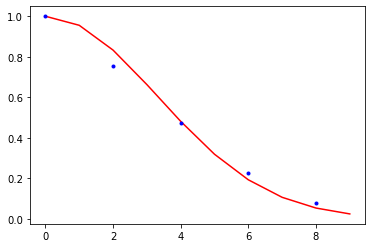

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 467
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [33.33663986 33.46606922 33.47054637 33.47046025 33.47032705]
Observation contribution to cost function [85.61324731 85.44143863 85.43218648 85.43140532 85.43283204]
Model contribution to cost function  [88.51143834 88.11247734 88.11738352 88.11824972 88.11696336]
The values of the cost function total [207.46132551 207.01998519 207.02011637 207.02011529 207.02012244]
RMS between background/truth and analysis/truth [0.44014839 0.23822073]
New estimate for variance coming from assimilation window 1: 0.05213429364960219
New estimate for correlation length coming from assimilation window 1: 3.046890753324869


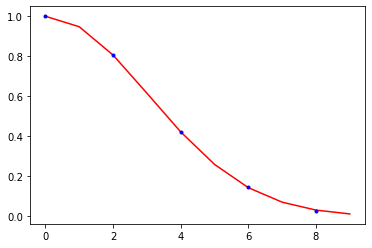

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 489
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [21.00621994 21.04040462 21.04035047 21.04028766 21.04024258]
Observation contribution to cost function [59.86205198 59.59828196 59.59568811 59.59630815 59.59662331]
Model contribution to cost function  [73.57111787 73.4043258  73.40699711 73.40643661 73.40616377]
The values of the cost function total [154.43938979 154.04301238 154.04303569 154.04303242 154.04302966]
RMS between background/truth and analysis/truth [0.3714511  0.19594769]
New estimate for variance coming from assimilation window 2: 0.047508357104506724
New estimate for correlation length coming from assimilation window 2: 3.0447826901104604


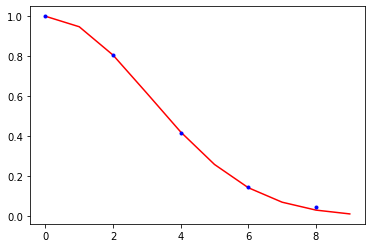

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 485
Number of inner iterations in outer iteration number 2: 193
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [31.74506135 31.76379411 31.76369652 31.76365425 31.76343952]
Observation contribution to cost function [71.4675226  71.27082675 71.26562893 71.26368793 71.26662177]
Model contribution to cost function  [82.64775795 82.39623237 82.40150058 82.4034915  82.40076482]
The values of the cost function total [185.8603419  185.43085323 185.43082603 185.43083368 185.43082611]
RMS between background/truth and analysis/truth [0.40306164 0.19029856]
New estimate for variance coming from assimilation window 3: 0.05231597379660203
New estimate for correlation length coming from assimilation window 3: 2.9462310821310638


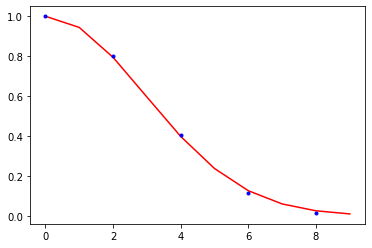

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 490
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [37.84508441 37.84645266 37.84877137 37.84868684 37.84837391]
Observation contribution to cost function [73.3011227  73.29865624 73.29471496 73.2922508  73.29547481]
Model contribution to cost function  [78.90196447 78.79490816 78.7965323  78.79908248 78.79617095]
The values of the cost function total [190.04817158 189.94001705 189.94001863 189.94002012 189.94001967]
RMS between background/truth and analysis/truth [0.35022326 0.18836643]
New estimate for variance coming from assimilation window 4: 0.043032156639565305
New estimate for correlation length coming from assimilation window 4: 2.567364922282975


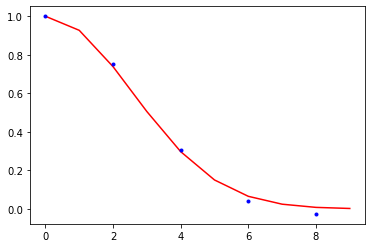

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 169
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [23.75604868 23.74079918 23.74074983 23.74049079 23.74038806]
Observation contribution to cost function [67.24625087 66.96578683 66.96287266 66.96344315 66.96301099]
Model contribution to cost function  [74.74883062 74.65396177 74.65691728 74.65660477 74.65714796]
The values of the cost function total [165.75113016 165.36054778 165.36053977 165.36053871 165.36054701]
RMS between background/truth and analysis/truth [0.35484016 0.19441077]
New estimate for variance coming from assimilation window 5: 0.0517823741219371
New estimate for correlation length coming from assimilation window 5: 2.6983163523158438


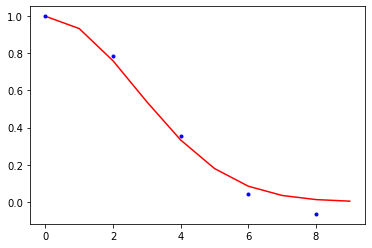

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 469
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 8
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.95873765 29.00294578 29.00389905 29.00375105 29.00372908]
Observation contribution to cost function [58.82898434 58.97469063 58.97186882 58.97321532 58.97218562]
Model contribution to cost function  [66.49843918 66.19279542 66.19467154 66.1934728  66.1945227 ]
The values of the cost function total [154.28616117 154.17043183 154.17043941 154.17043917 154.17043739]
RMS between background/truth and analysis/truth [0.33015679 0.19335164]
New estimate for variance coming from assimilation window 6: 0.0435326259498347
New estimate for correlation length coming from assimilation window 6: 2.835448021247274


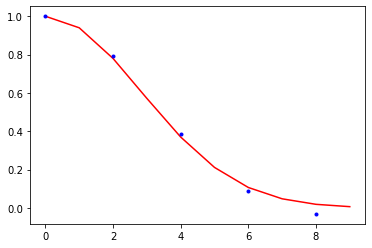

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 445
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [27.80213657 27.82522469 27.82463148 27.82465666 27.82459432]
Observation contribution to cost function [64.15571726 64.28675339 64.28789575 64.28535538 64.28803416]
Model contribution to cost function  [71.87999357 71.35747435 71.35699622 71.35951525 71.35689161]
The values of the cost function total [163.8378474  163.46945243 163.46952345 163.4695273  163.4695201 ]
RMS between background/truth and analysis/truth [0.37821979 0.19305363]
New estimate for variance coming from assimilation window 7: 0.04965219212829523
New estimate for correlation length coming from assimilation window 7: 3.1163349075481537


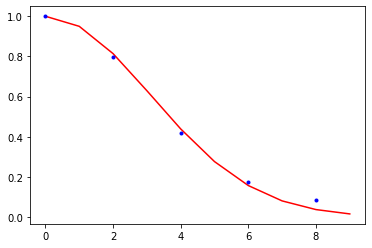

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 463
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [43.76988223 43.7432898  43.74526891 43.74517952 43.74499468]
Observation contribution to cost function [68.41355814 68.49113096 68.48651336 68.48553613 68.48710204]
Model contribution to cost function  [88.56526071 88.29602811 88.29867451 88.29974546 88.29835697]
The values of the cost function total [200.74870108 200.53044887 200.53045679 200.53046111 200.53045369]
RMS between background/truth and analysis/truth [0.4120927  0.20537051]
New estimate for variance coming from assimilation window 8: 0.059688511060845724
New estimate for correlation length coming from assimilation window 8: 3.304750791308011


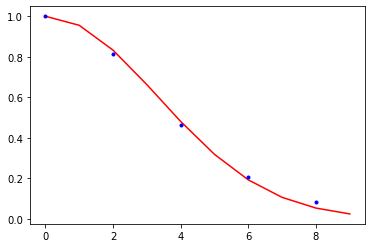

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 482
Number of inner iterations in outer iteration number 2: 177
Number of inner iterations in outer iteration number 3: 12
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [46.81521896 46.87455161 46.87682029 46.87676621 46.87665726]
Observation contribution to cost function [74.86647821 74.76066741 74.75517264 74.75462047 74.75552558]
Model contribution to cost function  [69.3385856  69.05872713 69.06198227 69.06258928 69.06179203]
The values of the cost function total [191.02028277 190.69394616 190.6939752  190.69397596 190.69397487]
RMS between background/truth and analysis/truth [0.34747129 0.20411335]
New estimate for variance coming from assimilation window 9: 0.03821202942654828
New estimate for correlation length coming from assimilation window 9: 2.4162893876860467


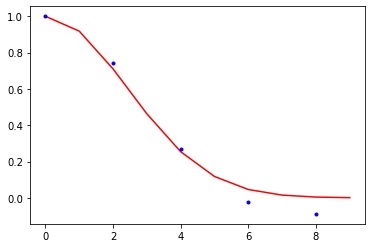

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 459
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [64.56594439 64.6311235  64.63540038 64.63496668 64.63487649]
Observation contribution to cost function [74.42218338 74.33698371 74.32746599 74.32780115 74.32873016]
Model contribution to cost function  [77.47802517 77.51573865 77.52117419 77.52127579 77.52044478]
The values of the cost function total [216.46615293 216.48384586 216.48404056 216.48404362 216.48405144]
RMS between background/truth and analysis/truth [0.43314087 0.22438024]
New estimate for variance coming from assimilation window 10: 0.06121361835412144
New estimate for correlation length coming from assimilation window 10: 3.1826002634326285


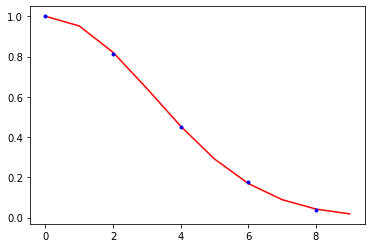

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 485
Number of inner iterations in outer iteration number 2: 227
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [71.73287561 71.71875862 71.72454071 71.72334667 71.72305186]
Observation contribution to cost function [95.45768423 93.94251113 93.92232192 93.92288958 93.92454039]
Model contribution to cost function  [80.21001937 79.10140936 79.11549247 79.11614637 79.11480111]
The values of the cost function total [247.40057921 244.76267912 244.7623551  244.76238262 244.76239336]
RMS between background/truth and analysis/truth [0.38969242 0.22224268]
New estimate for variance coming from assimilation window 11: 0.049727663250936874
New estimate for correlation length coming from assimilation window 11: 2.6827511924908145


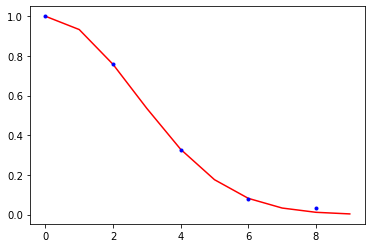

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 464
Number of inner iterations in outer iteration number 2: 203
Number of inner iterations in outer iteration number 3: 27
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [108.21153019 108.63502409 108.65693887 108.65445238 108.6541581 ]
Observation contribution to cost function [98.44766153 98.64006459 98.60960778 98.61231473 98.61029852]
Model contribution to cost function  [94.83346917 94.20433546 94.21356765 94.21342047 94.21571908]
The values of the cost function total [301.49266089 301.47942414 301.48011429 301.48018758 301.48017571]
RMS between background/truth and analysis/truth [0.44517134 0.24899071]
New estimate for variance coming from assimilation window 12: 0.05344648155880217
New estimate for correlation length coming from assimilation window 12: 2.6444116072721457


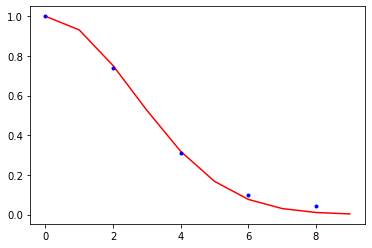

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 464
Number of inner iterations in outer iteration number 2: 199
Number of inner iterations in outer iteration number 3: 28
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [144.06453627 144.09514574 144.12449427 144.12387128 144.12320802]
Observation contribution to cost function [149.70861616 148.06078366 148.00725046 148.00880735 148.00800998]
Model contribution to cost function  [98.93005425 97.06269293 97.08537392 97.08447516 97.08595089]
The values of the cost function total [392.70320668 389.21862233 389.21711865 389.21715379 389.2171689 ]
RMS between background/truth and analysis/truth [0.45203125 0.26139473]
New estimate for variance coming from assimilation window 13: 0.05612054154871247
New estimate for correlation length coming from assimilation window 13: 2.8899192246732426


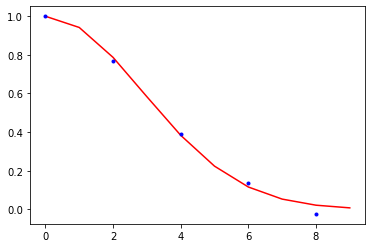

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 462
Number of inner iterations in outer iteration number 2: 191
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [126.00419276 126.00949773 126.02349687 126.02271742 126.02177311]
Observation contribution to cost function [133.23062963 133.07843952 133.04813101 133.04758207 133.05101977]
Model contribution to cost function  [98.52127981 95.5901161  95.60620958 95.60752379 95.60503817]
The values of the cost function total [357.7561022  354.67805335 354.67783746 354.67782327 354.67783105]
RMS between background/truth and analysis/truth [0.43696676 0.28128546]
New estimate for variance coming from assimilation window 14: 0.05366749887465298
New estimate for correlation length coming from assimilation window 14: 2.829081314384066


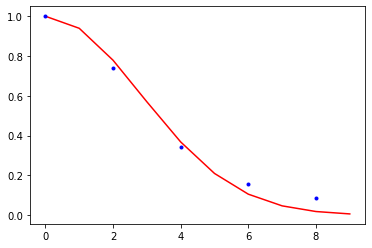

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [104.20406566 104.18557412 104.19830352 104.19679308 104.19620887]
Observation contribution to cost function [93.54469336 93.63046283 93.60757506 93.60950975 93.60989866]
Model contribution to cost function  [115.93296664 114.47835347 114.48812104 114.48769967 114.48789594]
The values of the cost function total [313.68172566 312.29439043 312.29399962 312.2940025  312.29400347]
RMS between background/truth and analysis/truth [0.48736258 0.28784529]
New estimate for variance coming from assimilation window 15: 0.08042751230219099
New estimate for correlation length coming from assimilation window 15: 2.989266120184887


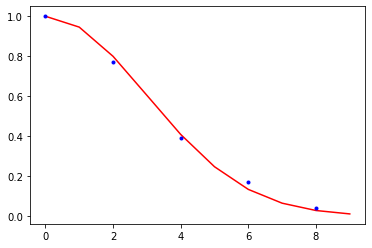

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [91.32366996 91.17088424 91.18027544 91.17766398 91.17583805]
Observation contribution to cost function [105.62651902 105.87082341 105.84462884 105.84789735 105.85033854]
Model contribution to cost function  [96.89440793 95.01728309 95.03362936 95.03295997 95.03233976]
The values of the cost function total [293.84459691 292.05899074 292.05853365 292.0585213  292.05851636]
RMS between background/truth and analysis/truth [0.46232828 0.31654457]
New estimate for variance coming from assimilation window 16: 0.04616556830542916
New estimate for correlation length coming from assimilation window 16: 2.51751918726393


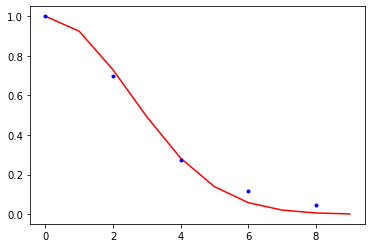

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 488
Number of inner iterations in outer iteration number 2: 251
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [137.37356529 137.54867902 137.5702002  137.56833233 137.5675226 ]
Observation contribution to cost function [146.45493711 147.91733654 147.86288527 147.86457425 147.86257816]
Model contribution to cost function  [118.31502656 115.65149204 115.68315359 115.68333782 115.68614013]
The values of the cost function total [402.14352896 401.11750759 401.11623905 401.1162444  401.11624089]
RMS between background/truth and analysis/truth [0.52783221 0.3418568 ]
New estimate for variance coming from assimilation window 17: 0.06385041986627794
New estimate for correlation length coming from assimilation window 17: 3.3082574621759746


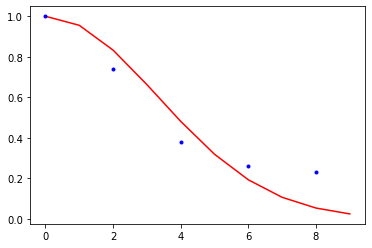

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 478
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 26
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [171.9779566  171.18033579 171.20181948 171.19700359 171.19539869]
Observation contribution to cost function [163.6647129  162.91229574 162.85490184 162.8590226  162.86106167]
Model contribution to cost function  [105.33708992 105.72742551 105.7616896  105.76240589 105.7619704 ]
The values of the cost function total [440.97975942 439.82005704 439.81841091 439.81843208 439.81843077]
RMS between background/truth and analysis/truth [0.54501628 0.37911275]
New estimate for variance coming from assimilation window 18: 0.05946231055214313
New estimate for correlation length coming from assimilation window 18: 2.496593970246349


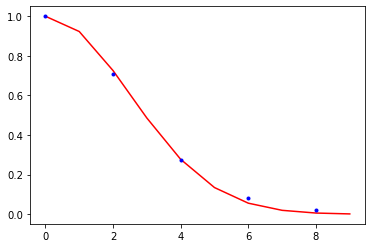

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 486
Number of inner iterations in outer iteration number 2: 235
Number of inner iterations in outer iteration number 3: 37
Number of inner iterations in outer iteration number 4: 11
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [243.57203842 242.3015546  242.30598725 242.29630224 242.29486841]
Observation contribution to cost function [186.75428661 186.7491392  186.68557622 186.69196678 186.69283683]
Model contribution to cost function  [122.72533479 119.71861176 119.76967376 119.77291636 119.77347332]
The values of the cost function total [553.05165982 548.76930556 548.76123724 548.76118539 548.76117856]
RMS between background/truth and analysis/truth [0.56613381 0.38604621]
New estimate for variance coming from assimilation window 19: 0.0679726975378383
New estimate for correlation length coming from assimilation window 19: 2.8340759360161485


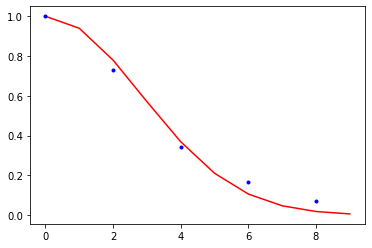

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 5
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [38.80206705 38.80807697 38.80741744 38.81038578 38.80827739]
Observation contribution to cost function [157.78433526 157.74851437 157.7530787  157.73975124 157.74644369]
Model contribution to cost function  [241.63610433 241.57571949 241.57180978 241.58216316 241.57757213]
The values of the cost function total [438.22250664 438.13231083 438.13230592 438.13230018 438.13229321]
RMS between background/truth and analysis/truth [0.3019616  0.19722722]
New estimate for variance coming from assimilation window 0: 0.03214465089053393
New estimate for correlation length coming from assimilation window 0: 2.489654478983168


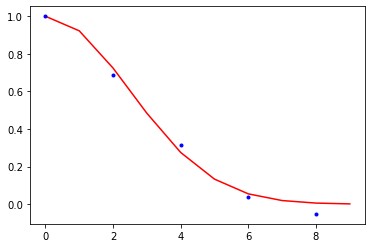

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 251
Number of inner iterations in outer iteration number 2: 105
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [20.06386282 19.98297724 19.98303612 19.98295093 19.98300974]
Observation contribution to cost function [57.98182307 57.61364953 57.61234132 57.61253637 57.60982667]
Model contribution to cost function  [89.04685092 89.02745766 89.02871319 89.02860876 89.03127422]
The values of the cost function total [167.09253681 166.62408444 166.62409063 166.62409606 166.62411063]
RMS between background/truth and analysis/truth [0.40924916 0.2183431 ]
New estimate for variance coming from assimilation window 1: 0.04285612947832987
New estimate for correlation length coming from assimilation window 1: 3.02614400378474


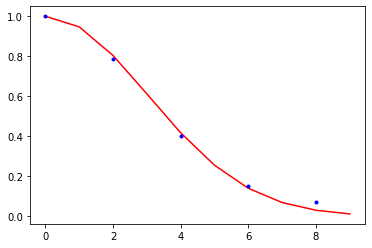

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 339
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [29.12120117 29.1815919  29.18254823 29.18225509 29.18203586]
Observation contribution to cost function [75.33241645 75.38632571 75.38207273 75.38270187 75.38306702]
Model contribution to cost function  [91.80272571 91.39163248 91.39492331 91.39457973 91.39442815]
The values of the cost function total [196.25634333 195.95955009 195.95954427 195.95953669 195.95953103]
RMS between background/truth and analysis/truth [0.36965806 0.19843113]
New estimate for variance coming from assimilation window 2: 0.049114933668050934
New estimate for correlation length coming from assimilation window 2: 2.640460258445756


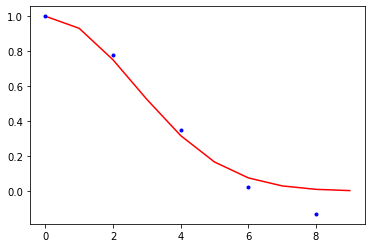

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 353
Number of inner iterations in outer iteration number 2: 137
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [24.33835135 24.36590996 24.36715122 24.36674747 24.36648949]
Observation contribution to cost function [56.28226567 56.04525675 56.04173476 56.04243856 56.04276909]
Model contribution to cost function  [89.05050495 89.21798499 89.22025388 89.21994899 89.21987285]
The values of the cost function total [169.67112198 169.6291517  169.62913985 169.62913502 169.62913143]
RMS between background/truth and analysis/truth [0.33229776 0.18324659]
New estimate for variance coming from assimilation window 3: 0.04876418430451393
New estimate for correlation length coming from assimilation window 3: 2.7810306856416047


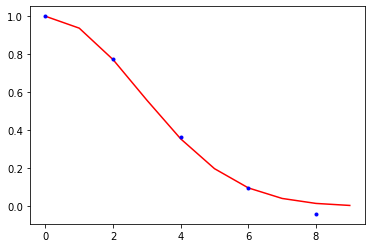

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 363
Number of inner iterations in outer iteration number 2: 137
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [14.43332024 14.41739135 14.41744383 14.41744339 14.41750722]
Observation contribution to cost function [55.95911706 56.06108903 56.06093654 56.0609223  56.0592244 ]
Model contribution to cost function  [75.76892937 75.23622641 75.23631035 75.23632215 75.23797006]
The values of the cost function total [146.16136667 145.71470679 145.71469072 145.71468784 145.71470168]
RMS between background/truth and analysis/truth [0.32803007 0.17670629]
New estimate for variance coming from assimilation window 4: 0.04570191154288159
New estimate for correlation length coming from assimilation window 4: 2.9254985597886716


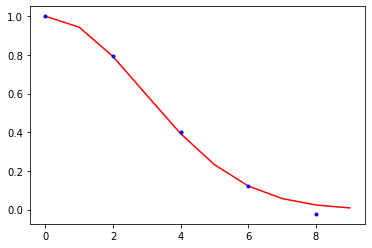

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 387
Number of inner iterations in outer iteration number 2: 143
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [19.31300219 19.31225015 19.31315304 19.31293242 19.31278458]
Observation contribution to cost function [60.08890782 59.9675774  59.96330739 59.96427203 59.96483452]
Model contribution to cost function  [78.88903274 78.6140849  78.61743466 78.61668697 78.61627078]
The values of the cost function total [158.29094275 157.89391245 157.89389509 157.89389142 157.89388988]
RMS between background/truth and analysis/truth [0.33648582 0.18141206]
New estimate for variance coming from assimilation window 5: 0.04659763770334387
New estimate for correlation length coming from assimilation window 5: 2.844908850249098


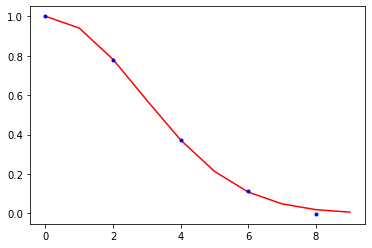

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 381
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [18.13913371 18.07174286 18.07248474 18.07233847 18.0722412 ]
Observation contribution to cost function [54.63589763 54.43177043 54.42977416 54.43017039 54.43041271]
Model contribution to cost function  [81.95223818 81.2968971  81.29814578 81.29789488 81.29774996]
The values of the cost function total [154.72726952 153.80041038 153.80040468 153.80040374 153.80040387]
RMS between background/truth and analysis/truth [0.37838827 0.19627525]
New estimate for variance coming from assimilation window 6: 0.04996169875204477
New estimate for correlation length coming from assimilation window 6: 2.944301177559863


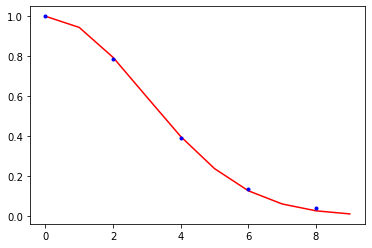

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 408
Number of inner iterations in outer iteration number 2: 157
Number of inner iterations in outer iteration number 3: 6
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [25.62838497 25.66109613 25.66197145 25.66177534 25.66173538]
Observation contribution to cost function [63.76434243 63.67983233 63.67425951 63.67511658 63.67503414]
Model contribution to cost function  [79.55707077 79.33048906 79.33520251 79.33454251 79.33466044]
The values of the cost function total [168.94979817 168.67141752 168.67143347 168.67143443 168.67142996]
RMS between background/truth and analysis/truth [0.34882319 0.20436245]
New estimate for variance coming from assimilation window 7: 0.04474663534182767
New estimate for correlation length coming from assimilation window 7: 2.463770539156241


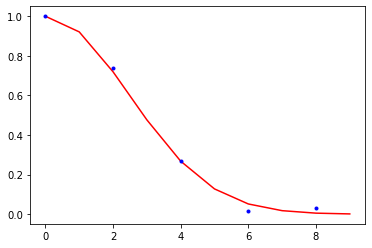

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 403
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [30.61530257 30.70921081 30.7101318  30.71001194 30.70977044]
Observation contribution to cost function [66.68027828 66.65479792 66.65069786 66.64878471 66.65145147]
Model contribution to cost function  [76.94549943 76.12305714 76.12623646 76.12827328 76.12584004]
The values of the cost function total [174.24108028 173.48706586 173.48706612 173.48706992 173.48706195]
RMS between background/truth and analysis/truth [0.38672635 0.2130035 ]
New estimate for variance coming from assimilation window 8: 0.046333192409728864
New estimate for correlation length coming from assimilation window 8: 2.8009137166671265


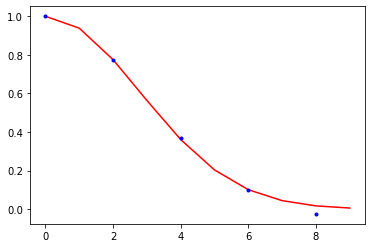

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 399
Number of inner iterations in outer iteration number 2: 147
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.00307432 27.03227635 27.03303948 27.03263489 27.03234883]
Observation contribution to cost function [64.95749696 64.8888194  64.88597597 64.88667001 64.88708901]
Model contribution to cost function  [94.66597085 94.00497543 94.00704374 94.00675083 94.00661567]
The values of the cost function total [186.62654213 185.92607118 185.92605919 185.92605573 185.9260535 ]
RMS between background/truth and analysis/truth [0.43452634 0.2277394 ]
New estimate for variance coming from assimilation window 9: 0.06097915363108988
New estimate for correlation length coming from assimilation window 9: 3.180351350966452


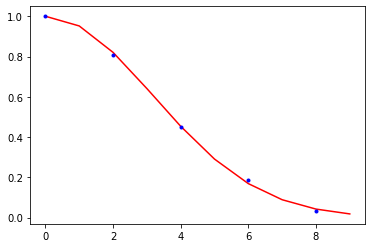

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 430
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 6
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [51.79761967 51.86868025 51.86949371 51.86895596 51.86877613]
Observation contribution to cost function [70.44397736 70.4367142  70.42923358 70.43082556 70.43229252]
Model contribution to cost function  [96.76998724 96.67515439 96.68176516 96.68070668 96.67942363]
The values of the cost function total [219.01158427 218.98054884 218.98049245 218.9804882  218.98049228]
RMS between background/truth and analysis/truth [0.4294236  0.25568593]
New estimate for variance coming from assimilation window 10: 0.05594397037289224
New estimate for correlation length coming from assimilation window 10: 2.6017279476248816


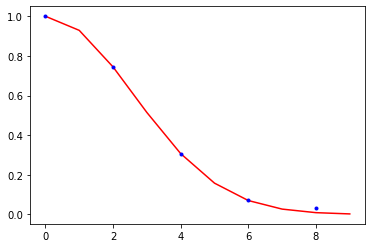

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 448
Number of inner iterations in outer iteration number 2: 173
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [51.98480812 52.04941693 52.04524272 52.04496192 52.04457975]
Observation contribution to cost function [92.38642778 92.29831854 92.29171134 92.29367658 92.29354436]
Model contribution to cost function  [86.50748652 86.07745236 86.08824623 86.08655922 86.08707658]
The values of the cost function total [230.87872242 230.42518783 230.42520029 230.42519772 230.42520069]
RMS between background/truth and analysis/truth [0.41043548 0.26796174]
New estimate for variance coming from assimilation window 11: 0.04448077872937142
New estimate for correlation length coming from assimilation window 11: 2.370197415128746


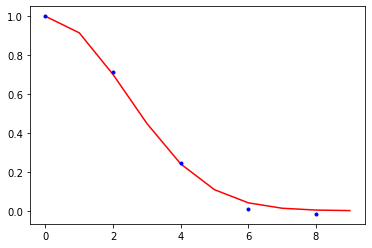

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 427
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.95677675 62.07349596 62.07768057 62.07706532 62.07645717]
Observation contribution to cost function [87.94302292 88.28289468 88.27652937 88.27748044 88.27823537]
Model contribution to cost function  [88.98827213 87.9538822  87.95578378 87.95543813 87.95528528]
The values of the cost function total [238.88807181 238.31027284 238.30999373 238.30998388 238.30997781]
RMS between background/truth and analysis/truth [0.45774268 0.29198903]
New estimate for variance coming from assimilation window 12: 0.058578275783162895
New estimate for correlation length coming from assimilation window 12: 3.3144926491149516


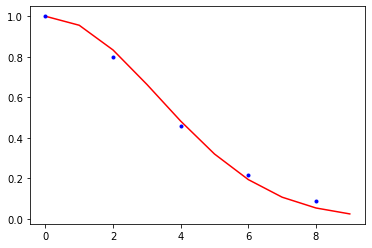

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 445
Number of inner iterations in outer iteration number 2: 211
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [73.32725479 73.57561077 73.58623954 73.58516639 73.58388867]
Observation contribution to cost function [99.03815297 98.3283257  98.30186327 98.30317992 98.30509949]
Model contribution to cost function  [103.18032308 100.96990266 100.98536064 100.98513243 100.98451073]
The values of the cost function total [275.54573084 272.87383912 272.87346345 272.87347875 272.87349888]
RMS between background/truth and analysis/truth [0.49916116 0.31614956]
New estimate for variance coming from assimilation window 13: 0.06418932098560451
New estimate for correlation length coming from assimilation window 13: 3.151842784665174


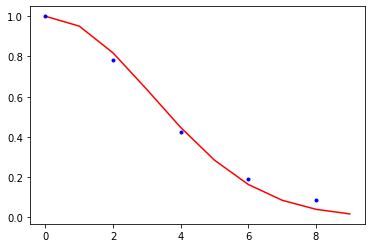

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [69.41970361 69.22575503 69.23423725 69.23324731 69.23250211]
Observation contribution to cost function [93.73802928 92.86353641 92.84935617 92.85090247 92.85207289]
Model contribution to cost function  [101.1242241  102.40523769 102.4108821  102.41033471 102.40991635]
The values of the cost function total [264.28195699 264.49452913 264.49447551 264.49448449 264.49449135]
RMS between background/truth and analysis/truth [0.5312263  0.35594957]
New estimate for variance coming from assimilation window 14: 0.060497282812688596
New estimate for correlation length coming from assimilation window 14: 2.6665556805291355


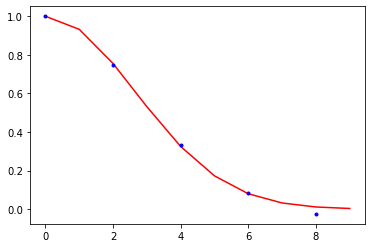

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 438
Number of inner iterations in outer iteration number 2: 213
Number of inner iterations in outer iteration number 3: 16
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [109.29470234 109.58075358 109.58857548 109.58831939 109.58764676]
Observation contribution to cost function [112.13235199 112.46094944 112.43584756 112.43714238 112.43763085]
Model contribution to cost function  [110.17027298 108.81478683 108.83218503 108.8311358  108.83133334]
The values of the cost function total [331.59732731 330.85648985 330.85660807 330.85659757 330.85661096]
RMS between background/truth and analysis/truth [0.52014988 0.38023289]
New estimate for variance coming from assimilation window 15: 0.047708875906334325
New estimate for correlation length coming from assimilation window 15: 2.1616377015700414


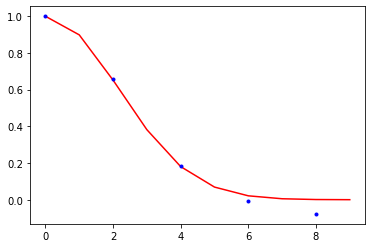

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 446
Number of inner iterations in outer iteration number 2: 185
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [117.26535708 116.91049374 116.92619491 116.92572009 116.92538998]
Observation contribution to cost function [112.01701733 110.92531171 110.90396525 110.90434647 110.9030986 ]
Model contribution to cost function  [100.54776287 100.1896781  100.19521365 100.19531705 100.19691464]
The values of the cost function total [329.83013728 328.02548354 328.02537381 328.02538362 328.02540321]
RMS between background/truth and analysis/truth [0.56827268 0.41515467]
New estimate for variance coming from assimilation window 16: 0.053287543755362744
New estimate for correlation length coming from assimilation window 16: 3.0841852053122287


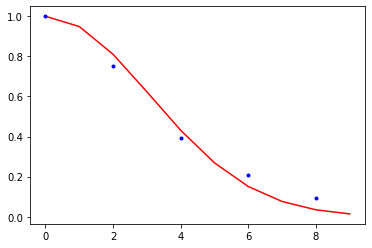

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 478
Number of inner iterations in outer iteration number 2: 215
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [125.2039003  125.5120919  125.52345051 125.5219002  125.5206962 ]
Observation contribution to cost function [126.88878215 127.9345902  127.90805567 127.91118776 127.91158604]
Model contribution to cost function  [108.74012247 107.0904487  107.1050766  107.10352333 107.10433256]
The values of the cost function total [360.83280493 360.53713081 360.53658278 360.53661129 360.5366148 ]
RMS between background/truth and analysis/truth [0.59288242 0.43785275]
New estimate for variance coming from assimilation window 17: 0.0529150520340993
New estimate for correlation length coming from assimilation window 17: 2.462223667460524


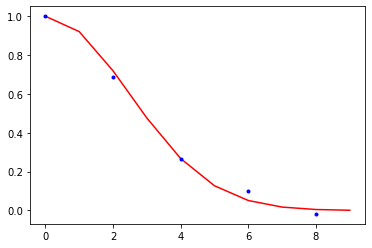

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 490
Number of inner iterations in outer iteration number 2: 245
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [174.65730199 174.76792937 174.80473165 174.80128407 174.80098708]
Observation contribution to cost function [148.62449097 148.1511564  148.09330384 148.10052537 148.09802007]
Model contribution to cost function  [126.58303746 129.41187419 129.43209442 129.42835103 129.43115655]
The values of the cost function total [449.86483043 452.33095996 452.3301299  452.33016048 452.3301637 ]
RMS between background/truth and analysis/truth [0.66083501 0.46729342]
New estimate for variance coming from assimilation window 18: 0.06925526168201496
New estimate for correlation length coming from assimilation window 18: 2.333045059800003


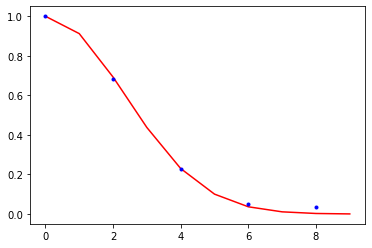

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 456
Number of inner iterations in outer iteration number 2: 215
Number of inner iterations in outer iteration number 3: 51
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [247.92076216 249.95491528 249.95710485 249.95987581 249.96017406]
Observation contribution to cost function [210.09181715 211.01786009 210.98951182 210.98825913 210.98742906]
Model contribution to cost function  [140.71503365 138.42926671 138.45655028 138.45509937 138.45561559]
The values of the cost function total [598.72761296 599.40204209 599.40316695 599.40323431 599.40321871]
RMS between background/truth and analysis/truth [0.68050421 0.49266626]
New estimate for variance coming from assimilation window 19: 0.06338808467901336
New estimate for correlation length coming from assimilation window 19: 2.2251665421905


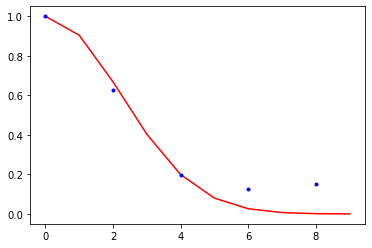

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [35.83397298 35.82739618 35.82780458 35.82961314 35.82883997]
Observation contribution to cost function [147.5747426  147.59925197 147.60117625 147.59255381 147.59508771]
Model contribution to cost function  [226.73377082 226.55660327 226.55426201 226.56107387 226.55930825]
The values of the cost function total [410.1424864  409.98325142 409.98324284 409.98324082 409.98323593]
RMS between background/truth and analysis/truth [0.28354172 0.19529539]
New estimate for variance coming from assimilation window 0: 0.030052882105015943
New estimate for correlation length coming from assimilation window 0: 2.268511970842982


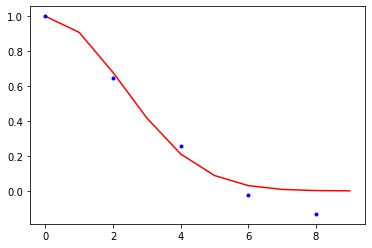

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 205
Number of inner iterations in outer iteration number 2: 77
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [20.38566866 20.40511696 20.40562927 20.40580501 20.40549981]
Observation contribution to cost function [58.28440247 58.2644611  58.26257819 58.25780945 58.26264166]
Model contribution to cost function  [118.67864991 117.83585385 117.83722669 117.84182319 117.83729047]
The values of the cost function total [197.34872103 196.50543192 196.50543415 196.50543765 196.50543194]
RMS between background/truth and analysis/truth [0.4079069  0.22032404]
New estimate for variance coming from assimilation window 1: 0.05086979156400666
New estimate for correlation length coming from assimilation window 1: 3.0926518681260506


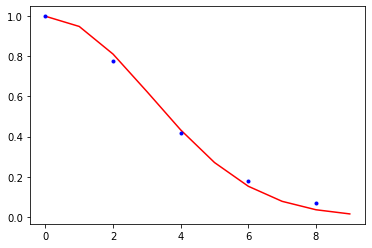

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 343
Number of inner iterations in outer iteration number 2: 121
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [18.97139432 18.90534087 18.90550315 18.90553231 18.90555455]
Observation contribution to cost function [51.82311851 51.74940915 51.74891652 51.74870959 51.74853955]
Model contribution to cost function  [76.58754306 76.24111    76.24144454 76.2416209  76.24176848]
The values of the cost function total [147.38205589 146.89586002 146.89586421 146.8958628  146.89586258]
RMS between background/truth and analysis/truth [0.3454571 0.1957412]
New estimate for variance coming from assimilation window 2: 0.04536710280244344
New estimate for correlation length coming from assimilation window 2: 2.9176535044413723


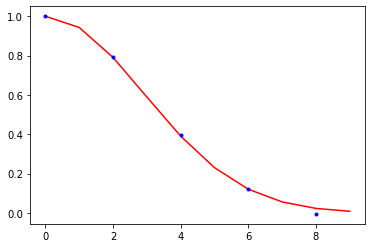

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 371
Number of inner iterations in outer iteration number 2: 143
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [22.11916103 22.03867708 22.03932504 22.03919206 22.03926196]
Observation contribution to cost function [52.00953486 52.10413981 52.10311204 52.10359588 52.10080115]
Model contribution to cost function  [78.31100936 77.74947937 77.74985367 77.74949574 77.75222709]
The values of the cost function total [152.43970525 151.89229625 151.89229075 151.89228368 151.89229019]
RMS between background/truth and analysis/truth [0.35978995 0.20997231]
New estimate for variance coming from assimilation window 3: 0.049841660177125754
New estimate for correlation length coming from assimilation window 3: 3.3235319472116234


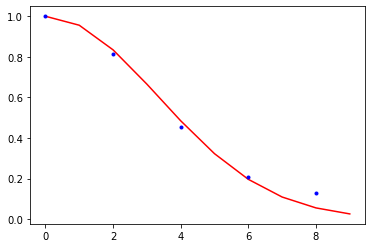

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 409
Number of inner iterations in outer iteration number 2: 161
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [30.88227344 30.92695406 30.92810368 30.92777992 30.92771054]
Observation contribution to cost function [66.30060046 66.33915072 66.3363188  66.3369644  66.33464952]
Model contribution to cost function  [91.72545954 90.96207811 90.96378363 90.96346083 90.96585091]
The values of the cost function total [188.90833344 188.22818289 188.22820611 188.22820514 188.22821097]
RMS between background/truth and analysis/truth [0.37578301 0.21680073]
New estimate for variance coming from assimilation window 4: 0.05903552988398644
New estimate for correlation length coming from assimilation window 4: 3.746836346825249


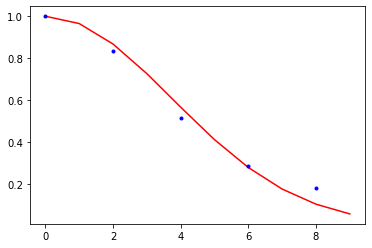

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 437
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [45.89614547 45.90861247 45.90832354 45.90789902 45.9076138 ]
Observation contribution to cost function [66.92544776 67.01305189 67.00940019 67.01001775 67.01049617]
Model contribution to cost function  [85.28086125 85.12983301 85.13361739 85.13342121 85.13322376]
The values of the cost function total [198.10245448 198.05149737 198.05134112 198.05133798 198.05133372]
RMS between background/truth and analysis/truth [0.44120536 0.21993278]
New estimate for variance coming from assimilation window 5: 0.061708149712317785
New estimate for correlation length coming from assimilation window 5: 3.335740313579271


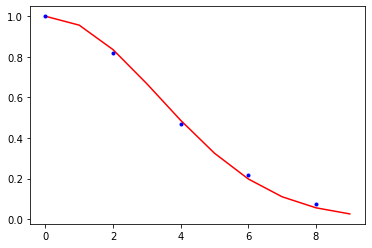

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 484
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.71748138 64.66355962 64.66737423 64.66689974 64.66646391]
Observation contribution to cost function [88.69468173 88.09854608 88.08728269 88.08819829 88.08887381]
Model contribution to cost function  [92.61897816 91.40821696 91.41554841 91.41511035 91.41487594]
The values of the cost function total [246.03114127 244.17032266 244.17020532 244.17020838 244.17021366]
RMS between background/truth and analysis/truth [0.38092875 0.22625176]
New estimate for variance coming from assimilation window 6: 0.057113941371297196
New estimate for correlation length coming from assimilation window 6: 2.9275349597797238


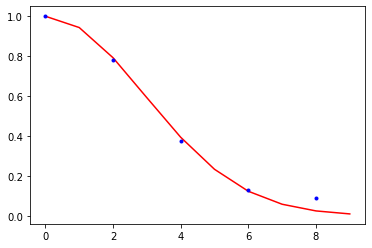

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 500
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [69.92201566 69.95994334 69.96945426 69.96860766 69.96774704]
Observation contribution to cost function [84.04567892 84.52618996 84.51246405 84.51342707 84.51445181]
Model contribution to cost function  [73.70933787 72.65467358 72.65874081 72.65862413 72.65846079]
The values of the cost function total [227.67703244 227.14080688 227.14065911 227.14065886 227.14065964]
RMS between background/truth and analysis/truth [0.39602282 0.23788813]
New estimate for variance coming from assimilation window 7: 0.04206824011696016
New estimate for correlation length coming from assimilation window 7: 2.5909360689092713


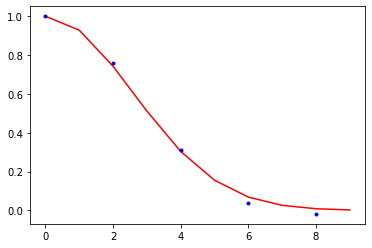

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 491
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [80.91870827 80.85388592 80.86925712 80.86770921 80.86647777]
Observation contribution to cost function [104.14554463 103.97514817 103.95008294 103.95195524 103.95361249]
Model contribution to cost function  [88.36499589 88.286928   88.29594655 88.29562731 88.29520811]
The values of the cost function total [273.42924878 273.11596209 273.11528661 273.11529175 273.11529837]
RMS between background/truth and analysis/truth [0.43015108 0.24749771]
New estimate for variance coming from assimilation window 8: 0.05857964701847736
New estimate for correlation length coming from assimilation window 8: 3.615526274326898


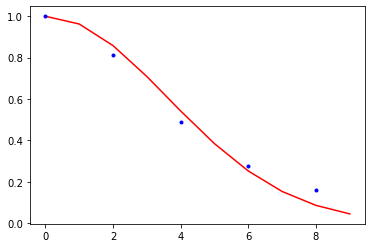

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 525
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 29
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [97.59124025 97.41140131 97.42287155 97.42101138 97.42037025]
Observation contribution to cost function [117.34352967 117.21809087 117.17544137 117.17718669 117.17595543]
Model contribution to cost function  [85.2215422  84.42659364 84.45513379 84.45520675 84.45707995]
The values of the cost function total [300.15631213 299.05608581 299.0534467  299.05340482 299.05340563]
RMS between background/truth and analysis/truth [0.46429239 0.27343037]
New estimate for variance coming from assimilation window 9: 0.052566647220635046
New estimate for correlation length coming from assimilation window 9: 2.9282989242897166


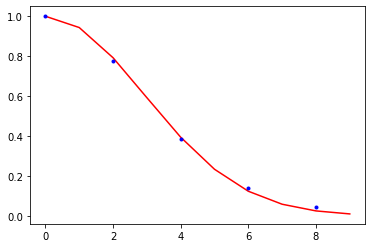

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 518
Number of inner iterations in outer iteration number 2: 217
Number of inner iterations in outer iteration number 3: 28
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [139.93356372 139.78045353 139.82110617 139.81722459 139.81663529]
Observation contribution to cost function [139.06630107 139.08116896 139.01456467 139.0206943  139.02041928]
Model contribution to cost function  [109.68509788 109.24374757 109.26862559 109.26639328 109.26726424]
The values of the cost function total [388.68496267 388.10537006 388.10429642 388.10431218 388.10431881]
RMS between background/truth and analysis/truth [0.49498019 0.29199574]
New estimate for variance coming from assimilation window 10: 0.060663408294272914
New estimate for correlation length coming from assimilation window 10: 2.2832578049069796


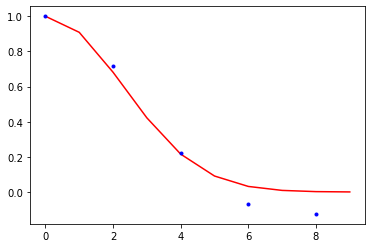

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 512
Number of inner iterations in outer iteration number 2: 223
Number of inner iterations in outer iteration number 3: 37
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [140.23058447 139.27328013 139.27799029 139.27250556 139.27223464]
Observation contribution to cost function [122.34003079 121.4293888  121.35871401 121.359943   121.36010586]
Model contribution to cost function  [110.00179534 110.19252017 110.25144569 110.25564535 110.25575689]
The values of the cost function total [372.5724106  370.8951891  370.88815    370.88809392 370.8880974 ]
RMS between background/truth and analysis/truth [0.50285365 0.31420151]
New estimate for variance coming from assimilation window 11: 0.0658468063464952
New estimate for correlation length coming from assimilation window 11: 2.5970182988087256


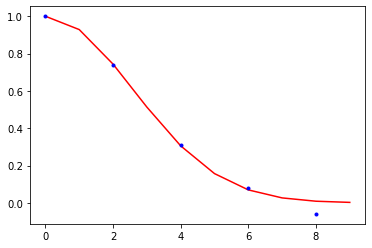

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 520
Number of inner iterations in outer iteration number 2: 249
Number of inner iterations in outer iteration number 3: 45
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [159.40494821 157.91759501 157.93242448 157.93131539 157.93099691]
Observation contribution to cost function [154.06806403 151.91635009 151.8134384  151.81149193 151.81054208]
Model contribution to cost function  [113.95967028 113.54972086 113.63120225 113.63418947 113.63546324]
The values of the cost function total [427.43268252 423.38366595 423.37706512 423.37699679 423.37700223]
RMS between background/truth and analysis/truth [0.49677963 0.32943013]
New estimate for variance coming from assimilation window 12: 0.048734157878099274
New estimate for correlation length coming from assimilation window 12: 2.1796923023631125


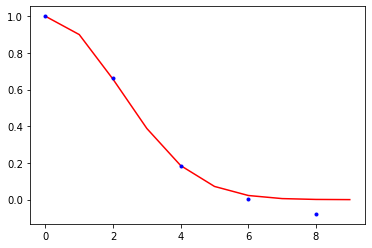

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 482
Number of inner iterations in outer iteration number 2: 213
Number of inner iterations in outer iteration number 3: 29
Number of inner iterations in outer iteration number 4: 4
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [144.79018266 143.94990505 143.96910512 143.96612442 143.96491704]
Observation contribution to cost function [132.31244658 131.67249469 131.61945173 131.62098882 131.62235474]
Model contribution to cost function  [112.84853593 111.89014566 111.92141965 111.92287534 111.9227204 ]
The values of the cost function total [389.95116517 387.5125454  387.5099765  387.50998858 387.50999218]
RMS between background/truth and analysis/truth [0.52650664 0.37120474]
New estimate for variance coming from assimilation window 13: 0.054867264410222064
New estimate for correlation length coming from assimilation window 13: 2.3022940884047784


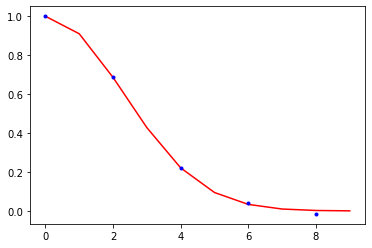

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 490
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [155.96297839 155.95199115 155.97637237 155.97349367 155.97207591]
Observation contribution to cost function [132.97123873 133.61925362 133.56421739 133.56492622 133.56960267]
Model contribution to cost function  [122.351091   120.13032877 120.16086632 120.16304237 120.15979811]
The values of the cost function total [411.28530813 409.70157354 409.70145608 409.70146227 409.70147669]
RMS between background/truth and analysis/truth [0.58286795 0.38622985]
New estimate for variance coming from assimilation window 14: 0.0723129278128929
New estimate for correlation length coming from assimilation window 14: 4.31453295223549


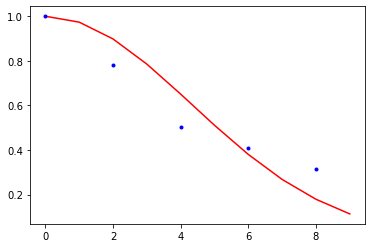

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 510
Number of inner iterations in outer iteration number 2: 231
Number of inner iterations in outer iteration number 3: 30
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [171.55286605 171.49548119 171.51578752 171.51422778 171.51366173]
Observation contribution to cost function [153.57763964 153.78990972 153.72994061 153.72949785 153.7313544 ]
Model contribution to cost function  [128.42961897 127.51109344 127.54999843 127.55201098 127.5507181 ]
The values of the cost function total [453.56012465 452.79648436 452.79572656 452.79573661 452.79573422]
RMS between background/truth and analysis/truth [0.61121249 0.4202005 ]
New estimate for variance coming from assimilation window 15: 0.07332586559922649
New estimate for correlation length coming from assimilation window 15: 3.3090206320234907


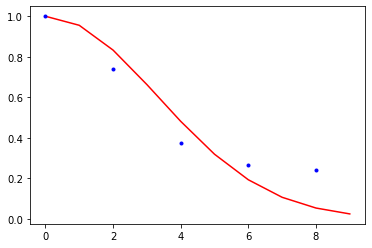

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 540
Number of inner iterations in outer iteration number 2: 247
Number of inner iterations in outer iteration number 3: 31
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [175.39725164 175.82613145 175.86654439 175.8656614  175.8641111 ]
Observation contribution to cost function [166.72488079 167.01787976 166.92550483 166.92644422 166.92933602]
Model contribution to cost function  [135.12227236 129.95494    130.00643106 130.00633452 130.00501603]
The values of the cost function total [477.24440479 472.79895121 472.79848028 472.79844015 472.79846315]
RMS between background/truth and analysis/truth [0.67146945 0.45725545]
New estimate for variance coming from assimilation window 16: 0.07033029244416462
New estimate for correlation length coming from assimilation window 16: 2.908134106228247


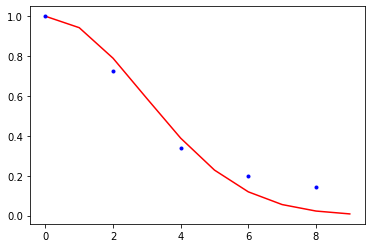

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 530
Number of inner iterations in outer iteration number 2: 249
Number of inner iterations in outer iteration number 3: 47
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [210.12969123 208.64028    208.67002766 208.67186016 208.67194797]
Observation contribution to cost function [182.96785511 180.35536936 180.26277572 180.26151573 180.25989944]
Model contribution to cost function  [141.19384766 140.09775995 140.16322608 140.16258631 140.16412785]
The values of the cost function total [534.291394   529.09340932 529.09602946 529.0959622  529.09597526]
RMS between background/truth and analysis/truth [0.68401999 0.5022361 ]
New estimate for variance coming from assimilation window 17: 0.06509432717404241
New estimate for correlation length coming from assimilation window 17: 2.224835136253989


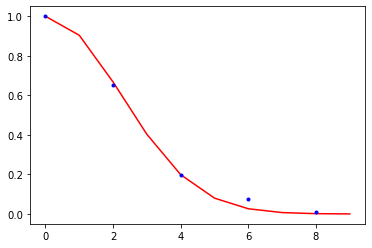

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 540
Number of inner iterations in outer iteration number 2: 241
Number of inner iterations in outer iteration number 3: 64
Number of inner iterations in outer iteration number 4: 8
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [267.46677829 266.48427908 266.5509877  266.55570259 266.55577392]
Observation contribution to cost function [223.65186487 221.76161906 221.63857276 221.63187069 221.63094853]
Model contribution to cost function  [159.97202863 156.67214773 156.74188598 156.74384201 156.74471457]
The values of the cost function total [651.0906718  644.91804586 644.93144644 644.93141529 644.93143701]
RMS between background/truth and analysis/truth [0.74887469 0.55513024]
New estimate for variance coming from assimilation window 18: 0.07701032366895967
New estimate for correlation length coming from assimilation window 18: 2.778519514217116


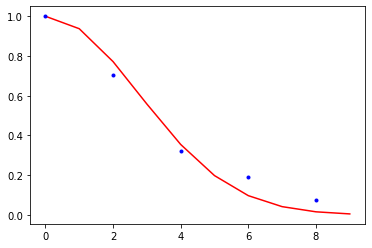

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 548
Number of inner iterations in outer iteration number 2: 299
Number of inner iterations in outer iteration number 3: 67
Number of inner iterations in outer iteration number 4: 12
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [379.71054052 378.43388704 378.6443445  378.63559909 378.63660164]
Observation contribution to cost function [323.10909274 322.61254335 322.3311945  322.33042557 322.32796194]
Model contribution to cost function  [190.29868218 186.91947449 187.00089182 187.0105906  187.0120808 ]
The values of the cost function total [893.11831544 887.96590487 887.97643082 887.97661526 887.97664438]
RMS between background/truth and analysis/truth [0.81175148 0.60055133]
New estimate for variance coming from assimilation window 19: 0.09033145684099167
New estimate for correlation length coming from assimilation window 19: 2.2246223575759925


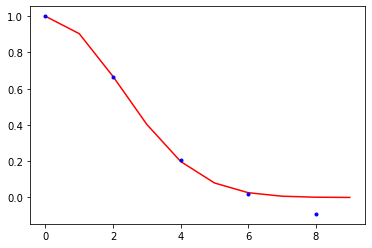

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 29
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [54.89307225 54.81460104 54.81548418 54.81720385 54.81577921]
Observation contribution to cost function [135.93617707 135.98529019 135.98913368 135.97529477 135.97926804]
Model contribution to cost function  [294.21669481 293.88264996 293.87806805 293.89018586 293.88762829]
The values of the cost function total [485.04594414 484.68254119 484.68268591 484.68268449 484.68267554]
RMS between background/truth and analysis/truth [0.3572681  0.22949378]
New estimate for variance coming from assimilation window 0: 0.04180251766810873
New estimate for correlation length coming from assimilation window 0: 2.393196156975306


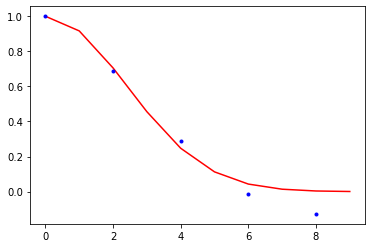

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 295
Number of inner iterations in outer iteration number 2: 111
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [18.31906336 18.30749946 18.30844883 18.30824577 18.30818976]
Observation contribution to cost function [41.9255445  41.72931304 41.72588797 41.7237598  41.72659253]
Model contribution to cost function  [99.03454179 98.99706519 98.99956567 99.00190495 98.99912188]
The values of the cost function total [159.27914964 159.03387769 159.03390246 159.03391052 159.03390417]
RMS between background/truth and analysis/truth [0.41580307 0.23998382]
New estimate for variance coming from assimilation window 1: 0.05970347322938897
New estimate for correlation length coming from assimilation window 1: 3.726339416166433


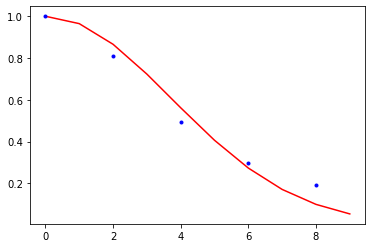

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 505
Number of inner iterations in outer iteration number 2: 207
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.45109314 28.53763242 28.53920353 28.53920982 28.53928695]
Observation contribution to cost function [80.61430217 80.46815978 80.46399186 80.46387467 80.46298911]
Model contribution to cost function  [72.67886477 72.27296567 72.27540847 72.275519   72.27633147]
The values of the cost function total [181.74426008 181.27875787 181.27860386 181.27860348 181.27860753]
RMS between background/truth and analysis/truth [0.37398026 0.20631992]
New estimate for variance coming from assimilation window 2: 0.04685523884111535
New estimate for correlation length coming from assimilation window 2: 3.1620655870986156


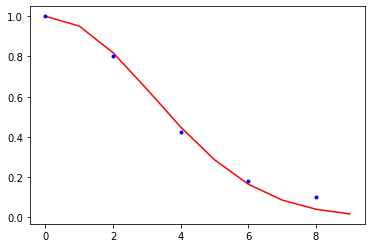

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 488
Number of inner iterations in outer iteration number 2: 198
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.76254248 28.82666118 28.82743021 28.82726146 28.82722138]
Observation contribution to cost function [58.12813197 58.13069354 58.12569984 58.12610499 58.12629141]
Model contribution to cost function  [68.5554462  67.943775   67.94799959 67.94775826 67.94760995]
The values of the cost function total [155.44612066 154.90112972 154.90112963 154.90112471 154.90112274]
RMS between background/truth and analysis/truth [0.36976377 0.19474991]
New estimate for variance coming from assimilation window 3: 0.04547550298037481
New estimate for correlation length coming from assimilation window 3: 2.7466928128827637


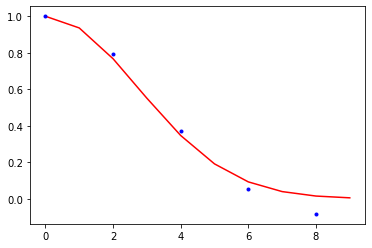

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 486
Number of inner iterations in outer iteration number 2: 193
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.04724902 28.04850852 28.04952696 28.04943046 28.0494405 ]
Observation contribution to cost function [75.82328752 75.88930282 75.88518059 75.88558315 75.88576447]
Model contribution to cost function  [71.13944079 70.46247182 70.46560249 70.4652925  70.46510514]
The values of the cost function total [175.00997733 174.40028316 174.40031004 174.40030611 174.4003101 ]
RMS between background/truth and analysis/truth [0.34394743 0.19562289]
New estimate for variance coming from assimilation window 4: 0.03989650791083342
New estimate for correlation length coming from assimilation window 4: 2.5544141168526333


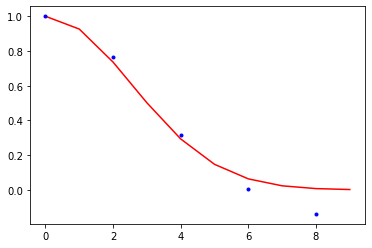

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 445
Number of inner iterations in outer iteration number 2: 193
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [39.1356212  38.95987305 38.96209054 38.96157608 38.96129849]
Observation contribution to cost function [78.82301162 78.50273336 78.49485453 78.49517526 78.49342707]
Model contribution to cost function  [83.74021398 84.23121822 84.23675718 84.23695223 84.23899008]
The values of the cost function total [201.69884679 201.69382463 201.69370225 201.69370357 201.69371564]
RMS between background/truth and analysis/truth [0.38121821 0.19747053]
New estimate for variance coming from assimilation window 5: 0.04600099002715051
New estimate for correlation length coming from assimilation window 5: 2.463016106233027


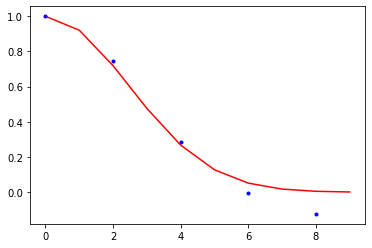

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 425
Number of inner iterations in outer iteration number 2: 157
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [39.61902293 39.54259567 39.54524176 39.54478883 39.54451672]
Observation contribution to cost function [72.55073111 72.62271306 72.61345661 72.61419743 72.61451082]
Model contribution to cost function  [84.38228205 83.19656033 83.20304656 83.20275637 83.20272299]
The values of the cost function total [196.55203608 195.36186906 195.36174493 195.36174264 195.36175052]
RMS between background/truth and analysis/truth [0.38407545 0.22639878]
New estimate for variance coming from assimilation window 6: 0.049367250886544284
New estimate for correlation length coming from assimilation window 6: 2.801979443546049


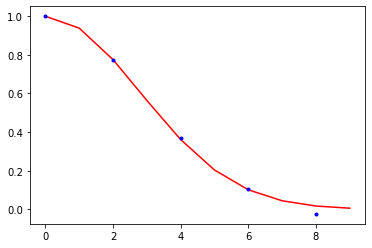

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 430
Number of inner iterations in outer iteration number 2: 217
Number of inner iterations in outer iteration number 3: 18
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [54.12825584 53.41327562 53.4129878  53.41275965 53.41235994]
Observation contribution to cost function [81.42275132 80.47197301 80.44966567 80.44814443 80.45022581]
Model contribution to cost function  [91.79153601 91.55960855 91.58137132 91.58312201 91.58144067]
The values of the cost function total [227.34254317 225.44485719 225.4440248  225.44402609 225.44402642]
RMS between background/truth and analysis/truth [0.3996954  0.24001983]
New estimate for variance coming from assimilation window 7: 0.05054165230994695
New estimate for correlation length coming from assimilation window 7: 2.4832433215515723


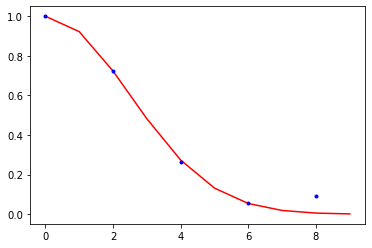

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 429
Number of inner iterations in outer iteration number 2: 181
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [69.42881804 69.04214562 69.05171633 69.05075181 69.05039394]
Observation contribution to cost function [85.1326107  83.97130158 83.94580914 83.9465878  83.94787786]
Model contribution to cost function  [82.61244764 83.89614578 83.91173466 83.9119331  83.91101215]
The values of the cost function total [237.17387638 236.90959298 236.90926012 236.90927272 236.90928395]
RMS between background/truth and analysis/truth [0.40280956 0.26381095]
New estimate for variance coming from assimilation window 8: 0.048176871671243106
New estimate for correlation length coming from assimilation window 8: 2.7799893229996337


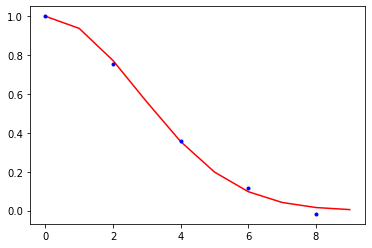

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 427
Number of inner iterations in outer iteration number 2: 161
Number of inner iterations in outer iteration number 3: 14
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [56.45283473 56.57395944 56.58045205 56.57967573 56.57951476]
Observation contribution to cost function [80.58984299 80.92073764 80.9108722  80.91412749 80.91215743]
Model contribution to cost function  [87.04508684 86.86240559 86.86573513 86.86326292 86.86538376]
The values of the cost function total [224.08776456 224.35710268 224.35705937 224.35706614 224.35705594]
RMS between background/truth and analysis/truth [0.45135841 0.2734395 ]
New estimate for variance coming from assimilation window 9: 0.0519429253419665
New estimate for correlation length coming from assimilation window 9: 2.8495691090710302


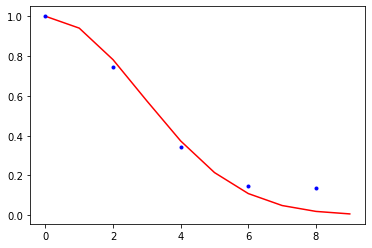

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 442
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [63.64541694 63.64200062 63.6501204  63.64948009 63.64892338]
Observation contribution to cost function [86.85629771 86.58454273 86.57178398 86.57304306 86.57410517]
Model contribution to cost function  [84.69618631 85.24435929 85.24891112 85.24829116 85.24778558]
The values of the cost function total [235.19790096 235.47090264 235.4708155  235.47081431 235.47081414]
RMS between background/truth and analysis/truth [0.44169473 0.28333386]
New estimate for variance coming from assimilation window 10: 0.050382784797667814
New estimate for correlation length coming from assimilation window 10: 3.483338029007644


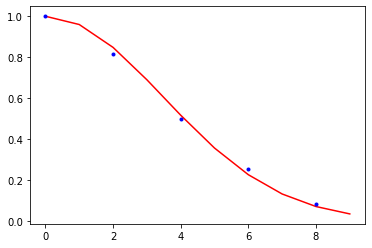

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.32104405 65.20854118 65.21417714 65.21350545 65.21296879]
Observation contribution to cost function [92.85761825 92.42260163 92.41230097 92.41338573 92.41426641]
Model contribution to cost function  [91.17440491 91.26771198 91.27230081 91.27189436 91.27156019]
The values of the cost function total [249.35306722 248.89885479 248.89877892 248.89878554 248.89879539]
RMS between background/truth and analysis/truth [0.47394195 0.30040001]
New estimate for variance coming from assimilation window 11: 0.04950958038930157
New estimate for correlation length coming from assimilation window 11: 3.256365388828598


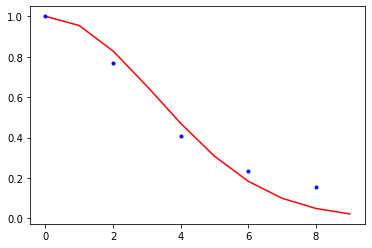

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 449
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 16
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [70.82936638 71.02780468 71.03767927 71.03665693 71.03631529]
Observation contribution to cost function [88.95857295 89.04471388 89.02617893 89.02733366 89.02781589]
Model contribution to cost function  [76.04480572 76.01749824 76.02590763 76.0257901  76.02564672]
The values of the cost function total [235.83274505 236.0900168  236.08976583 236.08978068 236.0897779 ]
RMS between background/truth and analysis/truth [0.5012437 0.3159062]
New estimate for variance coming from assimilation window 12: 0.05317440272089698
New estimate for correlation length coming from assimilation window 12: 3.062973264589838


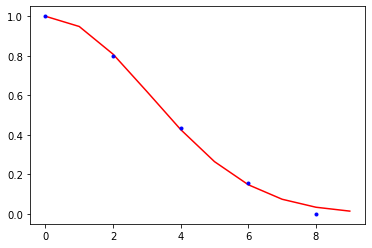

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 472
Number of inner iterations in outer iteration number 2: 187
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [101.14190107 100.91488005 100.93815483 100.93630967 100.93517266]
Observation contribution to cost function [115.80868441 114.97634911 114.94252437 114.94225212 114.9458456 ]
Model contribution to cost function  [77.77716432 77.99148825 78.00081234 78.00294471 78.00050341]
The values of the cost function total [294.7277498  293.88271741 293.88149154 293.8815065  293.88152167]
RMS between background/truth and analysis/truth [0.49871735 0.33967731]
New estimate for variance coming from assimilation window 13: 0.04425019613465077
New estimate for correlation length coming from assimilation window 13: 2.9063437082844823


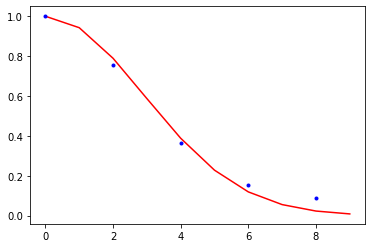

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 458
Number of inner iterations in outer iteration number 2: 207
Number of inner iterations in outer iteration number 3: 33
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [164.50904952 163.9869157  164.02647248 164.02408051 164.02253673]
Observation contribution to cost function [135.36443822 133.26439369 133.19630606 133.19531713 133.1968196 ]
Model contribution to cost function  [100.39732104 100.61974986 100.64165488 100.64499779 100.64504038]
The values of the cost function total [400.27080879 397.87105926 397.86443342 397.86439543 397.86439671]
RMS between background/truth and analysis/truth [0.53969169 0.36785956]
New estimate for variance coming from assimilation window 14: 0.05913024923120897
New estimate for correlation length coming from assimilation window 14: 3.9310016504665994


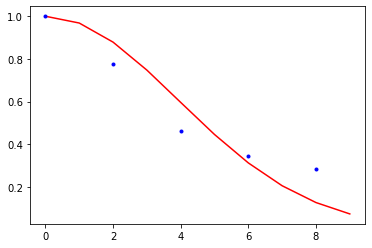

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 414
Number of inner iterations in outer iteration number 2: 215
Number of inner iterations in outer iteration number 3: 27
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [206.80010425 206.40354832 206.45520434 206.44744405 206.44645914]
Observation contribution to cost function [171.9189537  169.6275279  169.55649806 169.56505522 169.56614072]
Model contribution to cost function  [95.93401765 96.66004414 96.67501375 96.67435875 96.67426584]
The values of the cost function total [474.65307559 472.69112037 472.68671615 472.68685802 472.6868657 ]
RMS between background/truth and analysis/truth [0.52667633 0.4018746 ]
New estimate for variance coming from assimilation window 15: 0.038528772779071796
New estimate for correlation length coming from assimilation window 15: 2.2462223265910515


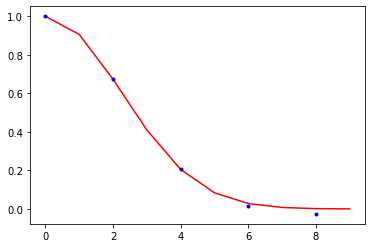

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 448
Number of inner iterations in outer iteration number 2: 219
Number of inner iterations in outer iteration number 3: 25
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [209.40663647 209.03013871 209.06051486 209.05800916 209.05720591]
Observation contribution to cost function [183.49993931 181.91719978 181.87594276 181.87749366 181.87954819]
Model contribution to cost function  [145.12696727 146.40773721 146.4190127  146.42001301 146.41877756]
The values of the cost function total [538.03354305 537.3550757  537.35547032 537.35551583 537.35553166]
RMS between background/truth and analysis/truth [0.60520707 0.45071328]
New estimate for variance coming from assimilation window 16: 0.06463655235359853
New estimate for correlation length coming from assimilation window 16: 2.231225377277861


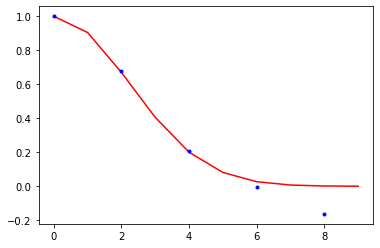

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 476
Number of inner iterations in outer iteration number 2: 233
Number of inner iterations in outer iteration number 3: 49
Number of inner iterations in outer iteration number 4: 7
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [220.79937581 222.5238649  222.52201201 222.51684825 222.51901498]
Observation contribution to cost function [211.60463363 211.2422972  211.17029515 211.18791344 211.18182644]
Model contribution to cost function  [171.27079744 171.72114119 171.79394775 171.78167934 171.78556369]
The values of the cost function total [603.67480688 605.4873033  605.48625491 605.48644103 605.48640511]
RMS between background/truth and analysis/truth [0.69651603 0.4890356 ]
New estimate for variance coming from assimilation window 17: 0.08086649777992144
New estimate for correlation length coming from assimilation window 17: 2.494149217555762


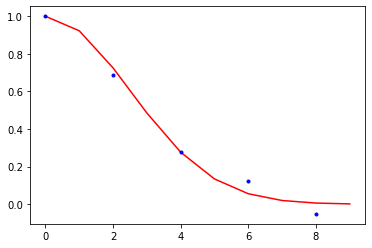

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 265
Number of inner iterations in outer iteration number 3: 60
Number of inner iterations in outer iteration number 4: 18
Number of inner iterations in outer iteration number 5: 5

Background contribution to cost function [375.37361908 377.1777448  377.30711225 377.31376604 377.33358611]
Observation contribution to cost function [307.88168218 302.15898618 301.8637046  301.8745917  301.84439854]
Model contribution to cost function  [228.43347361 227.5298005  227.70810583 227.6914432  227.70164447]
The values of the cost function total [911.68877487 906.86653148 906.87892267 906.87980094 906.87962912]
RMS between background/truth and analysis/truth [0.73008586 0.52745721]
New estimate for variance coming from assimilation window 18: 0.08107870130709019
New estimate for correlation length coming from assimilation window 18: 2.4306136679862966


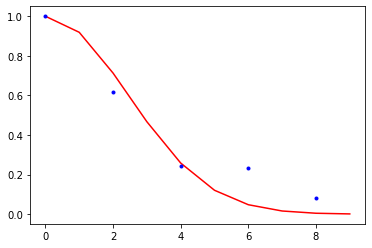

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 444
Number of inner iterations in outer iteration number 2: 297
Number of inner iterations in outer iteration number 3: 114
Number of inner iterations in outer iteration number 4: 53
Number of inner iterations in outer iteration number 5: 15

Background contribution to cost function [595.56633269 599.0601016  599.21211435 599.39707663 599.44186256]
Observation contribution to cost function [478.97084159 465.94341984 465.08424095 464.95236443 464.89626425]
Model contribution to cost function  [355.68569373 341.0191033  341.79401518 341.74316291 341.7535308 ]
The values of the cost function total [1430.22286801 1406.02262474 1406.09037048 1406.09260397 1406.09165761]
RMS between background/truth and analysis/truth [0.76996875 0.60491412]
New estimate for variance coming from assimilation window 19: 0.11691771327681777
New estimate for correlation length coming from assimilation window 19: 1.9149861147399982


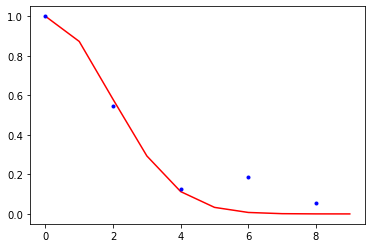

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [44.16326119 44.16981994 44.17085394 44.1723026  44.17134266]
Observation contribution to cost function [154.95754741 154.88364574 154.8829449  154.8753654  154.87831409]
Model contribution to cost function  [230.62139891 230.6549528  230.65459856 230.66072759 230.65873395]
The values of the cost function total [429.74220752 429.70841848 429.7083974  429.70839559 429.70839069]
RMS between background/truth and analysis/truth [0.30927842 0.21259762]
New estimate for variance coming from assimilation window 0: 0.0309414230698436
New estimate for correlation length coming from assimilation window 0: 2.1790707604817308


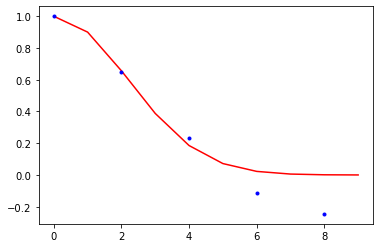

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 207
Number of inner iterations in outer iteration number 2: 73
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [21.00072386 21.0326262  21.03365569 21.03353322 21.03372547]
Observation contribution to cost function [59.58184863 59.76668816 59.76160491 59.76191588 59.75909429]
Model contribution to cost function  [111.23021629 110.10980689 110.113791   110.11359834 110.11623725]
The values of the cost function total [191.81278878 190.90912125 190.9090516  190.90904744 190.909057  ]
RMS between background/truth and analysis/truth [0.38859858 0.22034557]
New estimate for variance coming from assimilation window 1: 0.04553810721098725
New estimate for correlation length coming from assimilation window 1: 3.4724255972062417


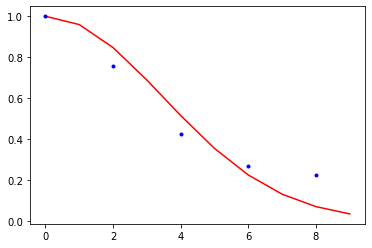

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 341
Number of inner iterations in outer iteration number 2: 133
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [28.32631129 28.29905136 28.30023703 28.2999925  28.29982143]
Observation contribution to cost function [59.51169941 59.2690907  59.266237   59.26682149 59.26719138]
Model contribution to cost function  [89.90496199 90.25035661 90.25201459 90.25166883 90.25146662]
The values of the cost function total [177.74297269 177.81849867 177.81848862 177.81848281 177.81847944]
RMS between background/truth and analysis/truth [0.39497171 0.20277242]
New estimate for variance coming from assimilation window 2: 0.04957729263373216
New estimate for correlation length coming from assimilation window 2: 2.6547444096723014


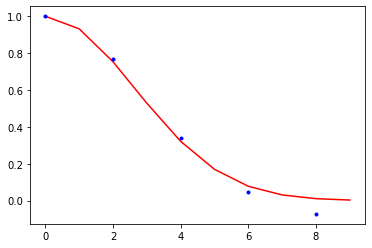

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 365
Number of inner iterations in outer iteration number 2: 135
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.64258061 24.67582145 24.67611243 24.67603127 24.67604462]
Observation contribution to cost function [52.8263311  52.62739337 52.62545952 52.62616457 52.62349712]
Model contribution to cost function  [83.81295683 84.19717385 84.19880506 84.19817519 84.20084098]
The values of the cost function total [161.28186853 161.50038867 161.50037701 161.50037102 161.50038272]
RMS between background/truth and analysis/truth [0.37100815 0.18020766]
New estimate for variance coming from assimilation window 3: 0.04982407615042626
New estimate for correlation length coming from assimilation window 3: 3.4379197506908152


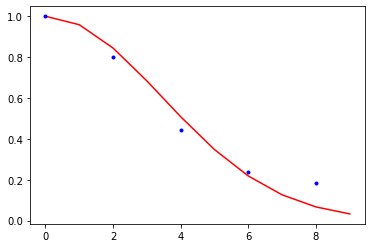

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 405
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [27.41920288 27.39766517 27.39835869 27.3981273  27.39795157]
Observation contribution to cost function [52.45870174 52.46884052 52.46755465 52.46809052 52.46833446]
Model contribution to cost function  [85.82872286 85.12850275 85.1290965  85.12878578 85.12871475]
The values of the cost function total [165.70662748 164.99500844 164.99500984 164.9950036  164.99500078]
RMS between background/truth and analysis/truth [0.39865596 0.1898192 ]
New estimate for variance coming from assimilation window 4: 0.06029375579604891
New estimate for correlation length coming from assimilation window 4: 3.521465034767856


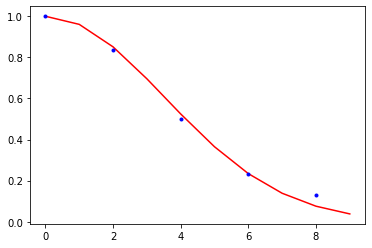

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 473
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [42.33964749 42.33407963 42.33541142 42.33512758 42.33487415]
Observation contribution to cost function [79.47071957 79.34759826 79.34174505 79.34244048 79.34303723]
Model contribution to cost function  [83.98458145 83.24548155 83.24997977 83.24957162 83.24923084]
The values of the cost function total [205.79494851 204.92715945 204.92713624 204.92713968 204.92714222]
RMS between background/truth and analysis/truth [0.37678732 0.19626246]
New estimate for variance coming from assimilation window 5: 0.050293914555453546
New estimate for correlation length coming from assimilation window 5: 2.945509286231696


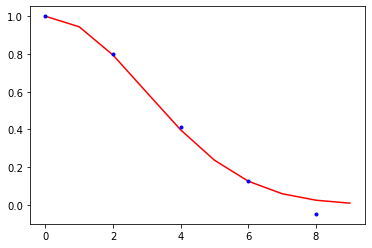

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 463
Number of inner iterations in outer iteration number 2: 215
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [29.84796605 29.79689593 29.79946986 29.79916918 29.79888612]
Observation contribution to cost function [67.50127914 67.02246214 67.01680281 67.01742274 67.01804064]
Model contribution to cost function  [81.87484431 82.61243663 82.61546728 82.61514571 82.61481075]
The values of the cost function total [179.2240895  179.43179469 179.43173995 179.43173763 179.43173751]
RMS between background/truth and analysis/truth [0.4483562  0.20130406]
New estimate for variance coming from assimilation window 6: 0.06484085768209447
New estimate for correlation length coming from assimilation window 6: 3.2015792266584553


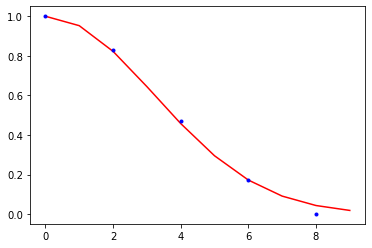

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 503
Number of inner iterations in outer iteration number 2: 209
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [43.1249844  43.46815713 43.46564528 43.46562993 43.46550816]
Observation contribution to cost function [64.94589117 64.75621871 64.75292646 64.75328781 64.75385175]
Model contribution to cost function  [70.90761617 70.49854106 70.50438539 70.50404077 70.50360344]
The values of the cost function total [178.97849174 178.7229169  178.72295713 178.72295851 178.72296335]
RMS between background/truth and analysis/truth [0.37561461 0.21045393]
New estimate for variance coming from assimilation window 7: 0.0455872134200927
New estimate for correlation length coming from assimilation window 7: 2.893428746293205


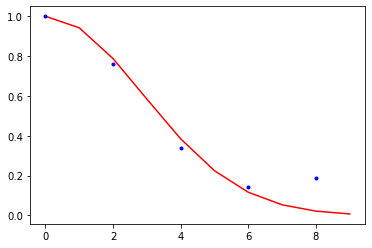

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 497
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [53.26787512 53.28658487 53.29348988 53.29324882 53.29288243]
Observation contribution to cost function [79.27066936 79.14374933 79.13430526 79.13193798 79.13507856]
Model contribution to cost function  [72.52363296 72.44584326 72.44825085 72.45087221 72.44809345]
The values of the cost function total [205.06217744 204.87617746 204.876046   204.87605901 204.87605444]
RMS between background/truth and analysis/truth [0.38852162 0.23939918]
New estimate for variance coming from assimilation window 8: 0.04691328735507966
New estimate for correlation length coming from assimilation window 8: 3.6531823194830126


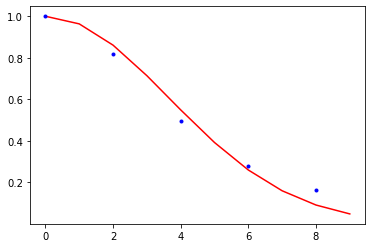

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 494
Number of inner iterations in outer iteration number 2: 203
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [60.19681582 60.09065804 60.09860192 60.09860056 60.09812719]
Observation contribution to cost function [83.51961146 83.35684836 83.34421625 83.34251286 83.34338285]
Model contribution to cost function  [91.03015143 89.42963213 89.43427169 89.43597472 89.43558413]
The values of the cost function total [234.74657871 232.87713852 232.87708986 232.87708814 232.87709418]
RMS between background/truth and analysis/truth [0.41267172 0.23700515]
New estimate for variance coming from assimilation window 9: 0.04763880643064592
New estimate for correlation length coming from assimilation window 9: 2.366838161820082


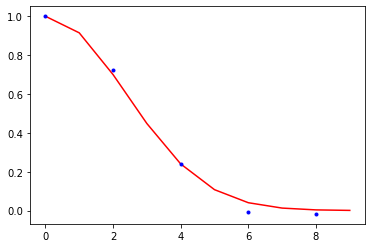

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 480
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 16
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.21881694 64.48921497 64.49422529 64.49401974 64.49348091]
Observation contribution to cost function [85.9548358  85.76459488 85.75005785 85.7506246  85.75142136]
Model contribution to cost function  [89.1147166  86.88965313 86.89907477 86.89871372 86.89845919]
The values of the cost function total [239.28836934 237.14346299 237.14335791 237.14335805 237.14336147]
RMS between background/truth and analysis/truth [0.42229384 0.24621867]
New estimate for variance coming from assimilation window 10: 0.05066695163965301
New estimate for correlation length coming from assimilation window 10: 2.5682941229158414


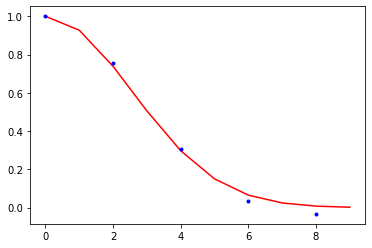

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 472
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [62.91482817 63.21365979 63.21537516 63.21550148 63.21524301]
Observation contribution to cost function [73.4056242  73.66578212 73.66007309 73.65887284 73.6610492 ]
Model contribution to cost function  [78.59181742 77.22635573 77.23034662 77.23140982 77.22949063]
The values of the cost function total [214.91226979 214.10579764 214.10579486 214.10578414 214.10578284]
RMS between background/truth and analysis/truth [0.42645759 0.25509671]
New estimate for variance coming from assimilation window 11: 0.04523659614161103
New estimate for correlation length coming from assimilation window 11: 2.8814551606152614


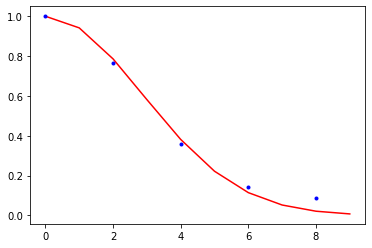

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 477
Number of inner iterations in outer iteration number 2: 191
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [64.10014605 64.04094199 64.04571036 64.0451381  64.0444381 ]
Observation contribution to cost function [79.41859216 79.14923377 79.13982724 79.14055425 79.14158702]
Model contribution to cost function  [80.398355   80.73289769 80.73737138 80.73721477 80.73687999]
The values of the cost function total [223.91709321 223.92307345 223.92290898 223.92290713 223.92290511]
RMS between background/truth and analysis/truth [0.42467028 0.26441522]
New estimate for variance coming from assimilation window 12: 0.05136097524588832
New estimate for correlation length coming from assimilation window 12: 2.983076597850961


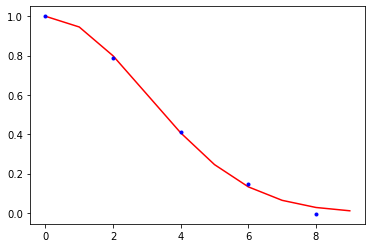

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 484
Number of inner iterations in outer iteration number 2: 177
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [66.87865459 66.99097792 66.99991638 66.99909316 66.99852729]
Observation contribution to cost function [89.50833107 89.48610545 89.46801304 89.468985   89.47011055]
Model contribution to cost function  [79.68034328 80.08388841 80.09294105 80.09279559 80.09223512]
The values of the cost function total [236.06732894 236.56097177 236.56087046 236.56087375 236.56087296]
RMS between background/truth and analysis/truth [0.42168178 0.26800446]
New estimate for variance coming from assimilation window 13: 0.04183906405212458
New estimate for correlation length coming from assimilation window 13: 3.5367437014249856


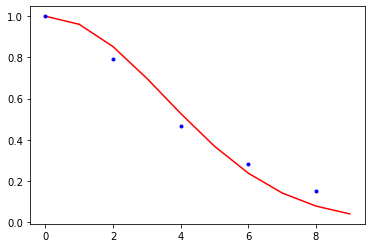

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 502
Number of inner iterations in outer iteration number 2: 225
Number of inner iterations in outer iteration number 3: 23
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [76.53945864 76.71981864 76.72545818 76.7241375  76.72384388]
Observation contribution to cost function [98.32990351 98.45452314 98.43667013 98.43848758 98.4391371 ]
Model contribution to cost function  [93.12413655 93.41907102 93.43162471 93.43114282 93.43078986]
The values of the cost function total [267.9934987  268.59341279 268.59375302 268.59376791 268.59377084]
RMS between background/truth and analysis/truth [0.45891466 0.29201484]
New estimate for variance coming from assimilation window 14: 0.048838109599353696
New estimate for correlation length coming from assimilation window 14: 2.2975557723463593


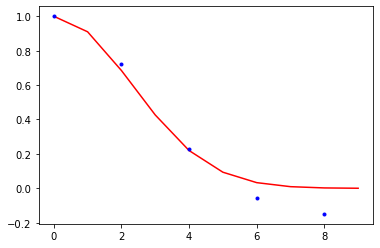

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 476
Number of inner iterations in outer iteration number 2: 223
Number of inner iterations in outer iteration number 3: 49
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [130.31455309 131.84067015 131.79603934 131.79167785 131.79364104]
Observation contribution to cost function [142.37480515 141.26417157 141.25082624 141.26511136 141.2603087 ]
Model contribution to cost function  [131.62527547 132.09580873 132.15340726 132.14387052 132.14664744]
The values of the cost function total [404.31463372 405.20065045 405.20027284 405.20065973 405.20059718]
RMS between background/truth and analysis/truth [0.48980985 0.29439559]
New estimate for variance coming from assimilation window 15: 0.055797185911814484
New estimate for correlation length coming from assimilation window 15: 2.034070238212928


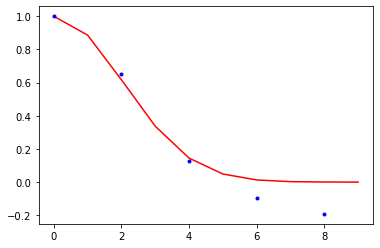

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 442
Number of inner iterations in outer iteration number 2: 211
Number of inner iterations in outer iteration number 3: 47
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [174.36940533 175.95700512 175.91538677 175.90844979 175.91090142]
Observation contribution to cost function [163.18107869 162.13971781 162.13189712 162.14419165 162.14013491]
Model contribution to cost function  [116.035051   115.63216871 115.68458646 115.67957168 115.68111516]
The values of the cost function total [453.58553503 453.72889164 453.73187034 453.73221311 453.7321515 ]
RMS between background/truth and analysis/truth [0.47814752 0.31238296]
New estimate for variance coming from assimilation window 16: 0.046157466116127005
New estimate for correlation length coming from assimilation window 16: 2.176879999914837


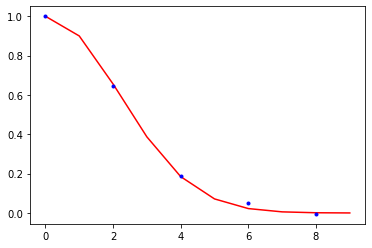

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 424
Number of inner iterations in outer iteration number 2: 207
Number of inner iterations in outer iteration number 3: 42
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [252.07771419 253.20125662 253.25670612 253.24613017 253.24933584]
Observation contribution to cost function [197.21916759 195.25912823 195.15519136 195.16351051 195.16054395]
Model contribution to cost function  [118.60043726 116.83403166 116.88338964 116.88598076 116.88569354]
The values of the cost function total [567.89731904 565.2944165  565.29528712 565.29562144 565.29557334]
RMS between background/truth and analysis/truth [0.47524218 0.31147151]
New estimate for variance coming from assimilation window 17: 0.04960955968981276
New estimate for correlation length coming from assimilation window 17: 2.228914583115601


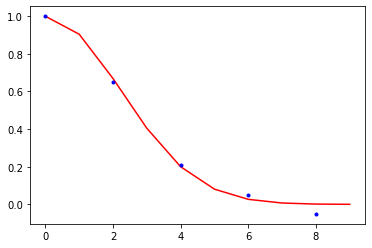

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 418
Number of inner iterations in outer iteration number 2: 169
Number of inner iterations in outer iteration number 3: 31
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [169.67028811 170.5751836  170.59866266 170.59063834 170.59088796]
Observation contribution to cost function [131.36798975 131.24924941 131.18523039 131.19549433 131.19590636]
Model contribution to cost function  [113.23127247 113.1858235  113.22756676 113.22547559 113.22480663]
The values of the cost function total [414.26955033 415.01025651 415.01145981 415.01160827 415.01160095]
RMS between background/truth and analysis/truth [0.48092771 0.32656541]
New estimate for variance coming from assimilation window 18: 0.0502524539403298
New estimate for correlation length coming from assimilation window 18: 2.576538099503718


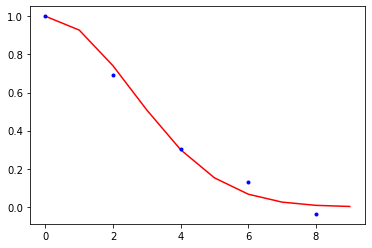

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 462
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 33
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [166.64574036 167.74694969 167.76546545 167.76139715 167.76067764]
Observation contribution to cost function [148.55565847 151.08587302 151.02497974 151.03197788 151.03413936]
Model contribution to cost function  [114.67067434 112.14430485 112.18690675 112.18399721 112.18256102]
The values of the cost function total [429.87207317 430.97712756 430.97735194 430.97737224 430.97737802]
RMS between background/truth and analysis/truth [0.50798508 0.35129389]
New estimate for variance coming from assimilation window 19: 0.055726337439690056
New estimate for correlation length coming from assimilation window 19: 2.8929283952268587


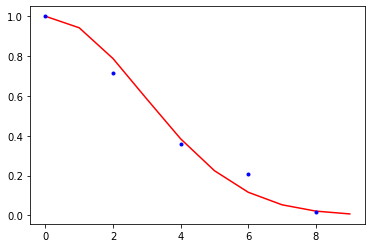

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 29
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [57.21382163 57.17783833 57.17950847 57.18045981 57.17913893]
Observation contribution to cost function [120.96259083 120.9525668  120.95565583 120.94482591 120.95048329]
Model contribution to cost function  [224.32398563 224.14224049 224.13756072 224.14743816 224.14309431]
The values of the cost function total [402.50039808 402.27264561 402.27272501 402.27272389 402.27271652]
RMS between background/truth and analysis/truth [0.29909906 0.20157795]
New estimate for variance coming from assimilation window 0: 0.03212720008548857
New estimate for correlation length coming from assimilation window 0: 2.045384901065307


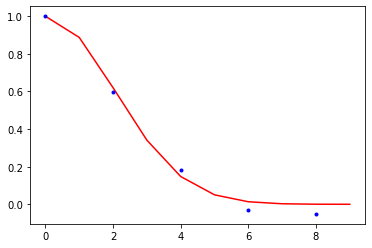

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 179
Number of inner iterations in outer iteration number 2: 67
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [17.83752936 17.85719017 17.85769005 17.85742924 17.85734093]
Observation contribution to cost function [46.86415348 46.89947137 46.89530851 46.89582062 46.89528076]
Model contribution to cost function  [119.48361473 119.12824001 119.1318922  119.13163321 119.13227332]
The values of the cost function total [184.18529757 183.88490155 183.88489076 183.88488306 183.88489501]
RMS between background/truth and analysis/truth [0.36339892 0.20328579]
New estimate for variance coming from assimilation window 1: 0.048298249351996066
New estimate for correlation length coming from assimilation window 1: 2.968026309495119


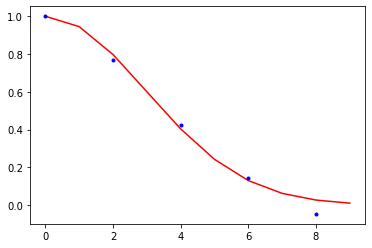

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 317
Number of inner iterations in outer iteration number 2: 129
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [32.34408628 32.41026689 32.41213766 32.41199756 32.41175987]
Observation contribution to cost function [63.61792655 63.9070707  63.90229335 63.89872811 63.90321366]
Model contribution to cost function  [93.49631366 92.41455003 92.41745441 92.42116092 92.41691064]
The values of the cost function total [189.45832649 188.73188761 188.73188542 188.73188659 188.73188417]
RMS between background/truth and analysis/truth [0.37347757 0.18179953]
New estimate for variance coming from assimilation window 2: 0.0474550376977739
New estimate for correlation length coming from assimilation window 2: 2.9968219305160804


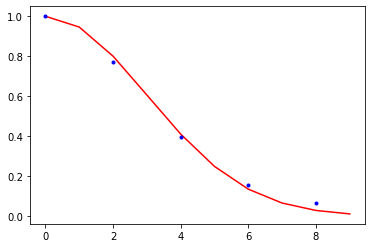

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 359
Number of inner iterations in outer iteration number 2: 133
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [26.11843002 26.14535894 26.14600609 26.14599327 26.14588322]
Observation contribution to cost function [54.15062093 54.15527853 54.15301309 54.15198336 54.15343548]
Model contribution to cost function  [82.6615443  82.0868034  82.08844999 82.08949117 82.08814678]
The values of the cost function total [162.93059524 162.38744088 162.38746917 162.38746779 162.38746548]
RMS between background/truth and analysis/truth [0.35687855 0.18103765]
New estimate for variance coming from assimilation window 3: 0.0474172042783769
New estimate for correlation length coming from assimilation window 3: 2.8058755071478383


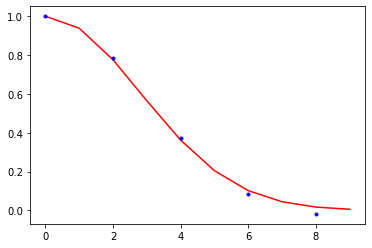

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 389
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [25.68855728 25.66914725 25.6701812  25.67006013 25.6699705 ]
Observation contribution to cost function [62.31197939 62.18210245 62.1809983  62.1813167  62.18150533]
Model contribution to cost function  [76.45007122 76.37864228 76.37870919 76.37851178 76.37841349]
The values of the cost function total [164.45060789 164.22989198 164.22988869 164.2298886  164.22988932]
RMS between background/truth and analysis/truth [0.31697792 0.18448427]
New estimate for variance coming from assimilation window 4: 0.04451661666402305
New estimate for correlation length coming from assimilation window 4: 2.8798946205242393


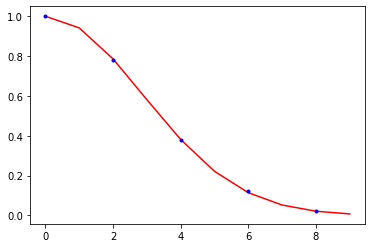

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 387
Number of inner iterations in outer iteration number 2: 135
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [22.12521149 22.16433777 22.16493761 22.16469577 22.16455149]
Observation contribution to cost function [60.78960666 60.83482543 60.83249799 60.83298822 60.83319671]
Model contribution to cost function  [71.8426284  71.69305012 71.69477264 71.69451748 71.69444865]
The values of the cost function total [154.75744655 154.69221333 154.69220824 154.69220147 154.69219685]
RMS between background/truth and analysis/truth [0.34273327 0.19886025]
New estimate for variance coming from assimilation window 5: 0.04436490853953327
New estimate for correlation length coming from assimilation window 5: 2.811042395398981


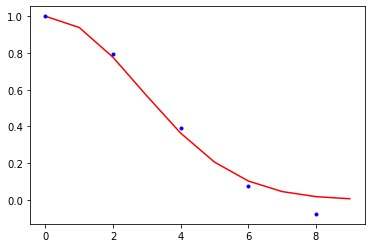

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 387
Number of inner iterations in outer iteration number 2: 163
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [25.58938036 25.54414985 25.54552957 25.5454231  25.54536209]
Observation contribution to cost function [60.97749907 60.46622537 60.4622079  60.45978994 60.46218257]
Model contribution to cost function  [85.48842176 85.26035938 85.26275672 85.26528724 85.26295094]
The values of the cost function total [172.05530118 171.27073461 171.27049419 171.27050027 171.2704956 ]
RMS between background/truth and analysis/truth [0.401019   0.21603573]
New estimate for variance coming from assimilation window 6: 0.054892843886091516
New estimate for correlation length coming from assimilation window 6: 2.9880796155176967


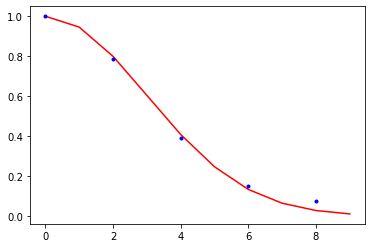

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 403
Number of inner iterations in outer iteration number 2: 155
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [32.38794082 32.30544434 32.30599457 32.30573759 32.30564521]
Observation contribution to cost function [67.68213431 67.78310942 67.780975   67.78126482 67.77846542]
Model contribution to cost function  [86.19247201 85.28348292 85.28506335 85.28502715 85.28792692]
The values of the cost function total [186.26254714 185.37203668 185.37203292 185.37202957 185.37203754]
RMS between background/truth and analysis/truth [0.43540998 0.22328766]
New estimate for variance coming from assimilation window 7: 0.06426780817892971
New estimate for correlation length coming from assimilation window 7: 2.8992200573773093


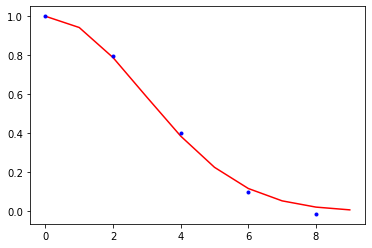

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 429
Number of inner iterations in outer iteration number 2: 175
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [41.88253624 41.60300249 41.60812532 41.60764767 41.60737521]
Observation contribution to cost function [65.03674364 64.89180142 64.88388612 64.88428335 64.88303807]
Model contribution to cost function  [84.04460797 83.85840865 83.861002   83.86108022 83.86260239]
The values of the cost function total [190.96388786 190.35321255 190.35301345 190.35301124 190.35301567]
RMS between background/truth and analysis/truth [0.37876296 0.23553376]
New estimate for variance coming from assimilation window 8: 0.04691903163351772
New estimate for correlation length coming from assimilation window 8: 2.48949260701276


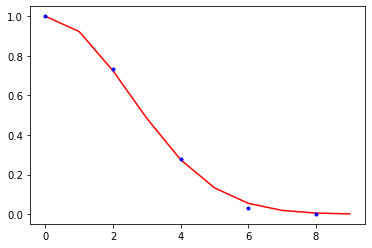

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 417
Number of inner iterations in outer iteration number 2: 217
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [50.5134082  49.80538944 49.80823287 49.80799179 49.80736711]
Observation contribution to cost function [71.21564679 70.28509168 70.26448967 70.2630921  70.26453427]
Model contribution to cost function  [89.15534026 88.1323753  88.14969968 88.15133718 88.15052687]
The values of the cost function total [210.88439525 208.22285642 208.22242222 208.22242106 208.22242826]
RMS between background/truth and analysis/truth [0.44301652 0.25556825]
New estimate for variance coming from assimilation window 9: 0.061615389523573094
New estimate for correlation length coming from assimilation window 9: 2.5786066942732697


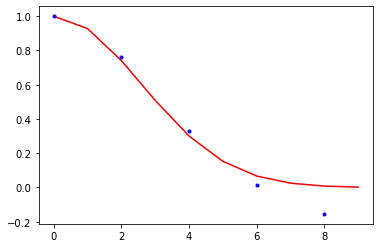

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 429
Number of inner iterations in outer iteration number 2: 225
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [61.21383203 60.81573192 60.82195568 60.82153217 60.82124433]
Observation contribution to cost function [71.34553313 70.02567665 70.00282237 70.00220213 70.00100261]
Model contribution to cost function  [83.97443807 83.86656189 83.88281242 83.88386716 83.88535796]
The values of the cost function total [216.53380323 214.70797046 214.70759047 214.70760145 214.7076049 ]
RMS between background/truth and analysis/truth [0.45612322 0.28820896]
New estimate for variance coming from assimilation window 10: 0.05189989396479625
New estimate for correlation length coming from assimilation window 10: 2.760231307697521


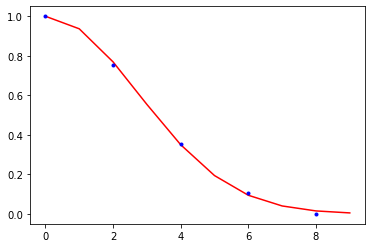

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 443
Number of inner iterations in outer iteration number 2: 159
Number of inner iterations in outer iteration number 3: 14
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [61.55403382 61.59227504 61.60417295 61.60335221 61.60297041]
Observation contribution to cost function [85.31133734 85.65872095 85.634447   85.63754826 85.63653178]
Model contribution to cost function  [91.924572   90.77171581 90.78409376 90.78181746 90.78320562]
The values of the cost function total [238.78994317 238.0227118  238.02271371 238.02271793 238.0227078 ]
RMS between background/truth and analysis/truth [0.49820618 0.30207125]
New estimate for variance coming from assimilation window 11: 0.0493044554453776
New estimate for correlation length coming from assimilation window 11: 3.2555351464847364


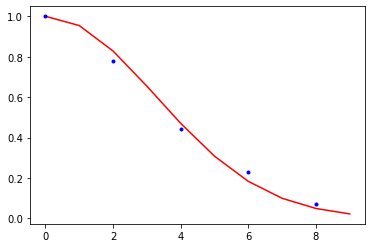

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 456
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [65.46308944 65.61731267 65.62341289 65.62237901 65.62191521]
Observation contribution to cost function [94.31654328 93.80821826 93.78727822 93.78900628 93.78883449]
Model contribution to cost function  [97.04294477 96.4204906  96.43551742 96.43482565 96.43547145]
The values of the cost function total [256.82257749 255.84602153 255.84620853 255.84621093 255.84622115]
RMS between background/truth and analysis/truth [0.47341271 0.32339112]
New estimate for variance coming from assimilation window 12: 0.048117814794116184
New estimate for correlation length coming from assimilation window 12: 2.3520293830580683


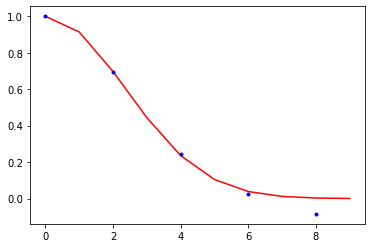

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 215
Number of inner iterations in outer iteration number 3: 25
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [77.6144926  77.61475805 77.60636741 77.60560464 77.60550147]
Observation contribution to cost function [105.15252845 105.12569832 105.11565379 105.11773101 105.11743532]
Model contribution to cost function  [124.07446899 123.13387949 123.15176164 123.15045316 123.15084593]
The values of the cost function total [306.84149004 305.87433586 305.87378284 305.87378881 305.87378273]
RMS between background/truth and analysis/truth [0.57280594 0.3774414 ]
New estimate for variance coming from assimilation window 13: 0.07265516912465422
New estimate for correlation length coming from assimilation window 13: 2.853898144497669


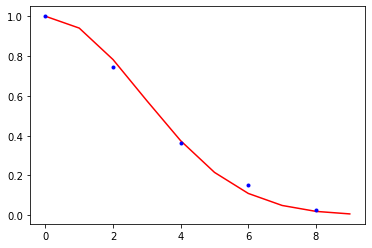

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 470
Number of inner iterations in outer iteration number 2: 219
Number of inner iterations in outer iteration number 3: 71
Number of inner iterations in outer iteration number 4: 9
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [129.53112301 131.73470899 131.63364069 131.63381479 131.63551201]
Observation contribution to cost function [152.5996538  153.95500224 153.97176999 153.98151889 153.97499836]
Model contribution to cost function  [175.6058447  171.61862537 171.70268833 171.6930331  171.69781121]
The values of the cost function total [457.73662151 457.30833661 457.30809901 457.30836678 457.30832158]
RMS between background/truth and analysis/truth [0.6031299  0.43152338]
New estimate for variance coming from assimilation window 14: 0.08027974794665788
New estimate for correlation length coming from assimilation window 14: 2.236163055511676


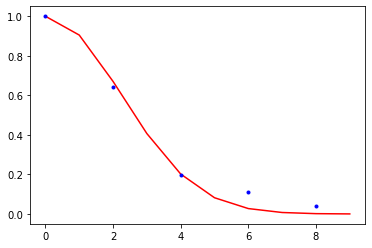

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 279
Number of inner iterations in outer iteration number 3: 170
Number of inner iterations in outer iteration number 4: 47
Number of inner iterations in outer iteration number 5: 9

Background contribution to cost function [273.12687845 285.25350499 284.31829277 284.4986306  284.49798552]
Observation contribution to cost function [258.41990076 264.0775102  264.39969951 264.3433619  264.31778561]
Model contribution to cost function  [258.41998525 249.32947828 249.93633414 249.8165667  249.84230463]
The values of the cost function total [789.96676446 798.66049347 798.65432642 798.6585592  798.65807576]
RMS between background/truth and analysis/truth [0.68136377 0.49340495]
New estimate for variance coming from assimilation window 15: 0.09787774981391913
New estimate for correlation length coming from assimilation window 15: 1.822478236685664


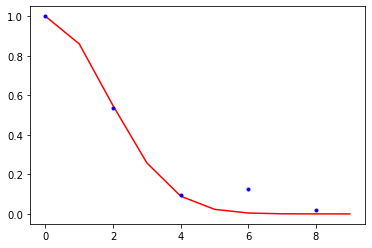

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 458
Number of inner iterations in outer iteration number 2: 303
Number of inner iterations in outer iteration number 3: 211
Number of inner iterations in outer iteration number 4: 111
Number of inner iterations in outer iteration number 5: 32

Background contribution to cost function [541.56390406 567.18773212 564.6659611  565.40521371 565.27992551]
Observation contribution to cost function [443.30009239 445.19970031 446.28609749 445.98086667 446.0345029 ]
Model contribution to cost function  [376.32698707 372.83064668 374.18399664 373.77206184 373.8407745 ]
The values of the cost function total [1361.19098351 1385.2180791  1385.13605523 1385.15814222 1385.15520291]
RMS between background/truth and analysis/truth [0.77981863 0.57207269]
New estimate for variance coming from assimilation window 16: 0.14155111300604767
New estimate for correlation length coming from assimilation window 16: 1.529999636044768


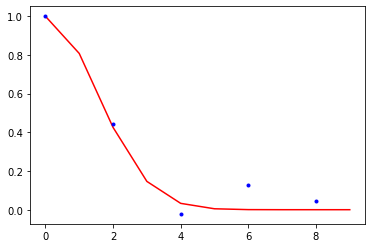

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 337
Number of inner iterations in outer iteration number 3: 247
Number of inner iterations in outer iteration number 4: 166
Number of inner iterations in outer iteration number 5: 93

Background contribution to cost function [1057.03316041 1081.30141556 1077.5024023  1079.48898017 1079.06518751]
Observation contribution to cost function [840.29229295 810.00053835 809.20164628 808.09606899 808.32494667]
Model contribution to cost function  [586.0580537  550.22115887 554.90464194 554.04396122 554.22105539]
The values of the cost function total [2483.38350705 2441.52311279 2441.60869053 2441.62901039 2441.61118958]
RMS between background/truth and analysis/truth [0.8832999  0.64635546]
New estimate for variance coming from assimilation window 17: 0.18663715944452375
New estimate for correlation length coming from assimilation window 17: 1.343588255198231


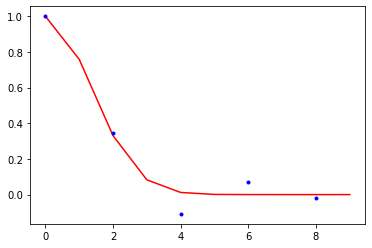

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 550
Number of inner iterations in outer iteration number 2: 417
Number of inner iterations in outer iteration number 3: 209
Number of inner iterations in outer iteration number 4: 122
Number of inner iterations in outer iteration number 5: 60

Background contribution to cost function [1451.31876757 1414.81103038 1411.78192499 1411.90856485 1411.8551472 ]
Observation contribution to cost function [1029.8934041   956.81109436  945.32306314  944.36426349  944.03171743]
Model contribution to cost function  [870.05748085 742.70626336 756.65194318 757.20695552 757.57397906]
The values of the cost function total [3351.26965252 3114.3283881  3113.7569313  3113.47978386 3113.46084369]
RMS between background/truth and analysis/truth [0.9120064  0.69031756]
New estimate for variance coming from assimilation window 18: 0.21201242644225005
New estimate for correlation length coming from assimilation window 18: 1.2054856293610343


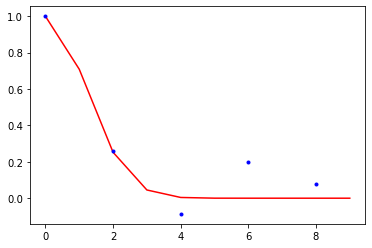

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 582
Number of inner iterations in outer iteration number 2: 471
Number of inner iterations in outer iteration number 3: 233
Number of inner iterations in outer iteration number 4: 100
Number of inner iterations in outer iteration number 5: 48

Background contribution to cost function [1273.41656566 1230.73689639 1229.38930057 1229.16235655 1229.15210901]
Observation contribution to cost function [757.06806869 703.58154305 695.94643558 695.7444152  695.56909154]
Model contribution to cost function  [921.73205465 706.83858188 716.43194514 716.79301745 716.98070846]
The values of the cost function total [2952.216689   2641.15702131 2641.76768128 2641.69978921 2641.70190901]
RMS between background/truth and analysis/truth [0.9652116  0.72087334]
New estimate for variance coming from assimilation window 19: 0.17468748549029356
New estimate for correlation length coming from assimilation window 19: 1.0068372223216508


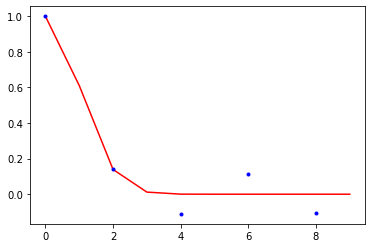

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 5
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [40.1486814  40.14485015 40.14235391 40.14528125 40.14350807]
Observation contribution to cost function [153.28395637 153.25320019 153.26015723 153.24759874 153.2516165 ]
Model contribution to cost function  [204.30090932 204.22019955 204.2157036  204.2253209  204.2230735 ]
The values of the cost function total [397.7335471  397.61824989 397.61821474 397.61820089 397.61819807]
RMS between background/truth and analysis/truth [0.2903268  0.20337834]
New estimate for variance coming from assimilation window 0: 0.026702472823091798
New estimate for correlation length coming from assimilation window 0: 2.4027733552348076


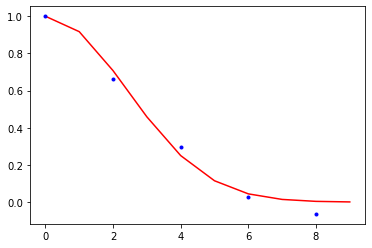

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 199
Number of inner iterations in outer iteration number 2: 85
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.40920736 24.44416071 24.44400792 24.44391658 24.44367904]
Observation contribution to cost function [64.139497   64.64073239 64.63705665 64.63528092 64.6382754 ]
Model contribution to cost function  [126.11939148 124.35230301 124.35611615 124.35798133 124.35521513]
The values of the cost function total [214.66809584 213.43719611 213.43718071 213.43717883 213.43716956]
RMS between background/truth and analysis/truth [0.42982957 0.21040225]
New estimate for variance coming from assimilation window 1: 0.05175868057955791
New estimate for correlation length coming from assimilation window 1: 2.670006238901031


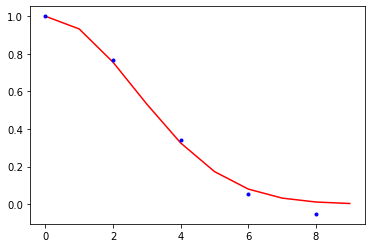

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 299
Number of inner iterations in outer iteration number 2: 103
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [12.85318637 12.83980191 12.84009979 12.84006496 12.84003087]
Observation contribution to cost function [48.03404735 48.07368407 48.07433052 48.07430045 48.07418676]
Model contribution to cost function  [81.49064157 81.23704728 81.23609407 81.23615225 81.23629811]
The values of the cost function total [142.37787529 142.15053326 142.15052438 142.15051765 142.15051574]
RMS between background/truth and analysis/truth [0.35503698 0.18286402]
New estimate for variance coming from assimilation window 2: 0.04851112986417999
New estimate for correlation length coming from assimilation window 2: 2.829186263953212


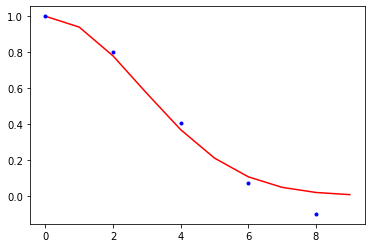

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 351
Number of inner iterations in outer iteration number 2: 137
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [20.96514789 20.98160224 20.98190809 20.98186328 20.98172904]
Observation contribution to cost function [49.69695342 49.76908857 49.76507557 49.76421196 49.7653945 ]
Model contribution to cost function  [93.73519314 93.18459788 93.18829794 93.18920274 93.18814933]
The values of the cost function total [164.39729445 163.93528869 163.9352816  163.93527798 163.93527288]
RMS between background/truth and analysis/truth [0.37509961 0.17549653]
New estimate for variance coming from assimilation window 3: 0.0583557441312202
New estimate for correlation length coming from assimilation window 3: 2.519072789108621


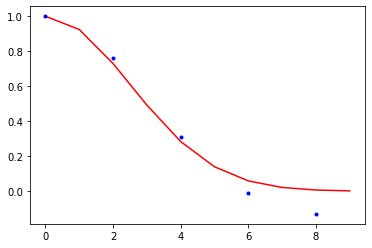

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 373
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [20.45968456 20.40749554 20.40798192 20.40766608 20.40743592]
Observation contribution to cost function [54.49364404 54.3311658  54.32904467 54.32938861 54.32970034]
Model contribution to cost function  [73.97412312 73.70878735 73.710375   73.71034701 73.71026802]
The values of the cost function total [148.92745172 148.4474487  148.44740159 148.4474017  148.44740428]
RMS between background/truth and analysis/truth [0.3275276  0.17400081]
New estimate for variance coming from assimilation window 4: 0.046481182440461996
New estimate for correlation length coming from assimilation window 4: 2.7171263472030054


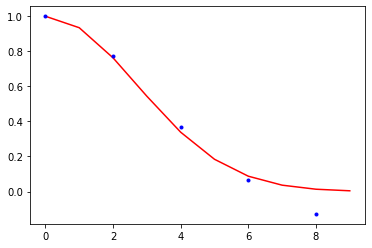

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 387
Number of inner iterations in outer iteration number 2: 147
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [17.28987079 17.2685697  17.26876174 17.26867372 17.26853707]
Observation contribution to cost function [58.8194249  58.85244136 58.85006517 58.84763214 58.85054328]
Model contribution to cost function  [70.93619338 70.09802136 70.100183   70.10270852 70.09993195]
The values of the cost function total [147.04548908 146.21903242 146.21900991 146.21901437 146.21901231]
RMS between background/truth and analysis/truth [0.35206273 0.18378251]
New estimate for variance coming from assimilation window 5: 0.042350080068734475
New estimate for correlation length coming from assimilation window 5: 2.803035423342095


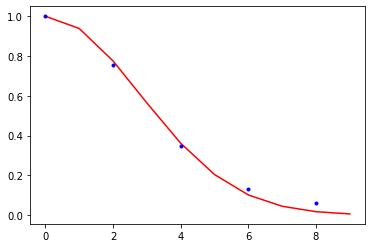

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 393
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 6
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [33.35882409 33.29852649 33.30099935 33.30085993 33.30072435]
Observation contribution to cost function [60.52663913 60.5136889  60.50751059 60.50898141 60.50830363]
Model contribution to cost function  [86.16968446 86.10631532 86.10997267 86.10863673 86.10944945]
The values of the cost function total [180.05514768 179.91853071 179.91848261 179.91847807 179.91847743]
RMS between background/truth and analysis/truth [0.35498901 0.20594925]
New estimate for variance coming from assimilation window 6: 0.047187248325266995
New estimate for correlation length coming from assimilation window 6: 2.5207185306101807


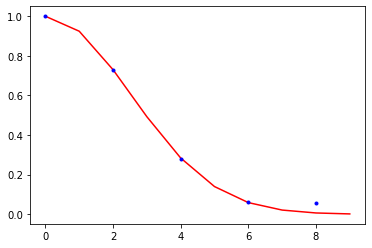

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 393
Number of inner iterations in outer iteration number 2: 159
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [32.67272367 32.47907658 32.47999588 32.47980927 32.47956994]
Observation contribution to cost function [59.21938671 58.60722255 58.60177537 58.59944243 58.60246784]
Model contribution to cost function  [88.08482064 87.97996741 87.98433757 87.98686299 87.98407474]
The values of the cost function total [179.97693103 179.06626654 179.06610883 179.06611469 179.06611253]
RMS between background/truth and analysis/truth [0.40656298 0.23374486]
New estimate for variance coming from assimilation window 7: 0.05025408701659402
New estimate for correlation length coming from assimilation window 7: 2.3550222333477295


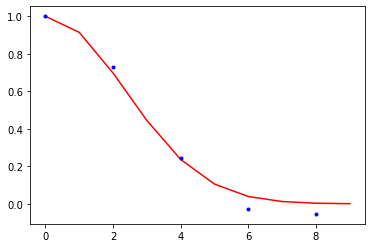

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 380
Number of inner iterations in outer iteration number 2: 147
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [30.4816704  30.44106509 30.44278915 30.44253248 30.44242263]
Observation contribution to cost function [58.42693273 58.39986174 58.39586592 58.39648455 58.39521193]
Model contribution to cost function  [74.32826967 73.85371646 73.85595106 73.85559088 73.85698601]
The values of the cost function total [163.23687281 162.6946433  162.69460614 162.69460791 162.69462057]
RMS between background/truth and analysis/truth [0.38140807 0.26068872]
New estimate for variance coming from assimilation window 8: 0.038026249694738334
New estimate for correlation length coming from assimilation window 8: 2.1569983330857996


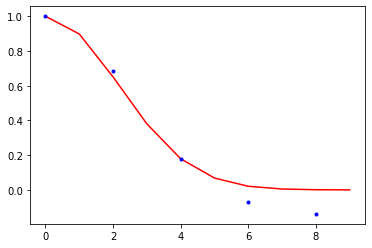

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 363
Number of inner iterations in outer iteration number 2: 147
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [38.0678717  38.07303532 38.07647372 38.07633246 38.07607787]
Observation contribution to cost function [65.81183489 66.04867231 66.04222001 66.03908148 66.04282527]
Model contribution to cost function  [106.92673941 106.83912684 106.84211906 106.84539461 106.84190854]
The values of the cost function total [210.80644599 210.96083446 210.96081279 210.96080854 210.96081168]
RMS between background/truth and analysis/truth [0.46014356 0.29707915]
New estimate for variance coming from assimilation window 9: 0.056098193786804675
New estimate for correlation length coming from assimilation window 9: 2.690526609773057


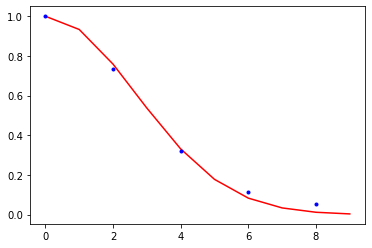

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 382
Number of inner iterations in outer iteration number 2: 167
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [44.9973542  45.72752372 45.7103995  45.70988624 45.70951858]
Observation contribution to cost function [79.06365348 79.78741326 79.78184112 79.78419434 79.78491928]
Model contribution to cost function  [123.70215534 120.27596208 120.2982316  120.29639395 120.29604126]
The values of the cost function total [247.76316303 245.79089906 245.79047222 245.79047453 245.79047913]
RMS between background/truth and analysis/truth [0.49456694 0.33172386]
New estimate for variance coming from assimilation window 10: 0.0573039519899703
New estimate for correlation length coming from assimilation window 10: 2.1632858860477047


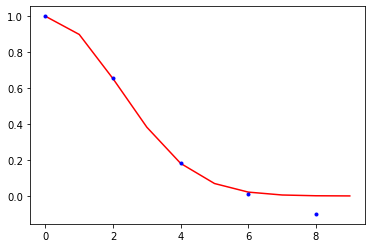

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 380
Number of inner iterations in outer iteration number 2: 153
Number of inner iterations in outer iteration number 3: 27
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [86.96717472 88.38559795 88.34925525 88.34778205 88.34758536]
Observation contribution to cost function [89.59092467 90.19029919 90.17936048 90.18591359 90.18250799]
Model contribution to cost function  [147.21702645 146.09352067 146.14082969 146.13575886 146.1393492 ]
The values of the cost function total [323.77512584 324.66941781 324.66944541 324.66945451 324.66944255]
RMS between background/truth and analysis/truth [0.53166533 0.37383498]
New estimate for variance coming from assimilation window 11: 0.0632338565282866
New estimate for correlation length coming from assimilation window 11: 2.6615558097364733


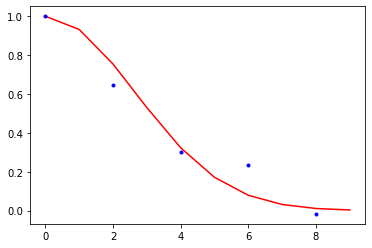

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 390
Number of inner iterations in outer iteration number 2: 169
Number of inner iterations in outer iteration number 3: 27
Number of inner iterations in outer iteration number 4: 4
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [165.84558848 166.82083802 166.77462266 166.77244623 166.77169542]
Observation contribution to cost function [156.87444574 155.73972594 155.68094354 155.68723719 155.68582586]
Model contribution to cost function  [193.31292808 194.29825941 194.40436077 194.40032481 194.40247972]
The values of the cost function total [516.0329623  516.85882337 516.85992696 516.86000823 516.860001  ]
RMS between background/truth and analysis/truth [0.60118327 0.42702227]
New estimate for variance coming from assimilation window 12: 0.07897788050034356
New estimate for correlation length coming from assimilation window 12: 2.0294235169757346


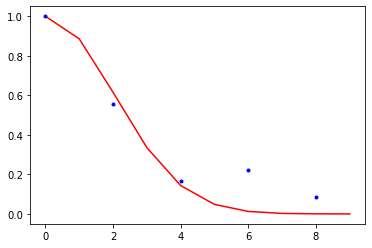

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 394
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 31
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [226.00609989 225.76266242 225.6880832  225.67997131 225.67726649]
Observation contribution to cost function [192.11654248 190.98157393 190.82877368 190.8323012  190.83444155]
Model contribution to cost function  [257.0460664  256.72164086 256.95124265 256.95586472 256.95643286]
The values of the cost function total [675.16870877 673.46587721 673.46809953 673.46813722 673.4681409 ]
RMS between background/truth and analysis/truth [0.68621848 0.49104528]
New estimate for variance coming from assimilation window 13: 0.10762047428304894
New estimate for correlation length coming from assimilation window 13: 3.1448385036934154


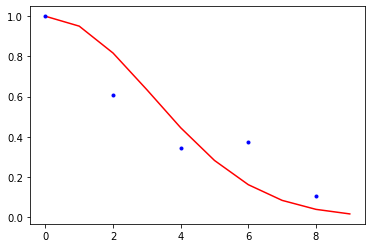

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 358
Number of inner iterations in outer iteration number 2: 219
Number of inner iterations in outer iteration number 3: 49
Number of inner iterations in outer iteration number 4: 9
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [290.67200441 289.04885017 288.88487477 288.8818405  288.88186614]
Observation contribution to cost function [233.75363948 230.01533697 229.81694408 229.80748397 229.80245136]
Model contribution to cost function  [271.42902957 268.49733332 268.8618103  268.87446144 268.87943515]
The values of the cost function total [795.85467346 787.56152045 787.56362914 787.5637859  787.56375265]
RMS between background/truth and analysis/truth [0.6766355  0.57108619]
New estimate for variance coming from assimilation window 14: 0.07441984545137138
New estimate for correlation length coming from assimilation window 14: 1.5430064749863137


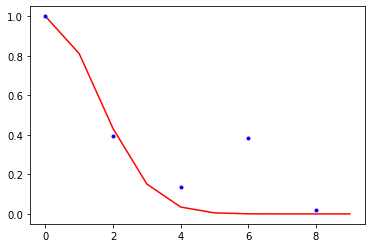

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 360
Number of inner iterations in outer iteration number 2: 293
Number of inner iterations in outer iteration number 3: 51
Number of inner iterations in outer iteration number 4: 13
Number of inner iterations in outer iteration number 5: 4

Background contribution to cost function [335.12167079 333.81909529 333.68741894 333.67340152 333.6729673 ]
Observation contribution to cost function [250.20439433 248.69621524 248.3571207  248.35022728 248.34514463]
Model contribution to cost function  [364.86976941 347.23403976 347.72249989 347.74357509 347.7490819 ]
The values of the cost function total [950.19583453 929.7493503  929.76703953 929.76720389 929.76719382]
RMS between background/truth and analysis/truth [0.83099226 0.68150331]
New estimate for variance coming from assimilation window 15: 0.08698620177421149
New estimate for correlation length coming from assimilation window 15: 1.2159117996338038


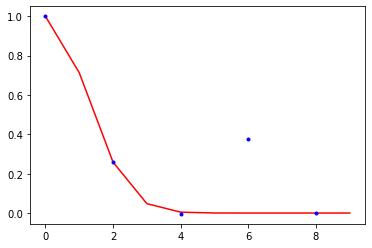

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 400
Number of inner iterations in outer iteration number 2: 323
Number of inner iterations in outer iteration number 3: 141
Number of inner iterations in outer iteration number 4: 29
Number of inner iterations in outer iteration number 5: 4

Background contribution to cost function [369.68708054 375.99139523 374.89043329 375.01599943 375.02050762]
Observation contribution to cost function [262.37487914 261.80595738 261.67005739 261.64407788 261.6050408 ]
Model contribution to cost function  [469.47178051 423.9203132  425.13587904 425.03586539 425.07038638]
The values of the cost function total [1101.5337402  1061.7176658  1061.69636972 1061.6959427  1061.69593479]
RMS between background/truth and analysis/truth [0.94997956 0.8229593 ]
New estimate for variance coming from assimilation window 16: 0.12256754452427968
New estimate for correlation length coming from assimilation window 16: 1.1482275297174371


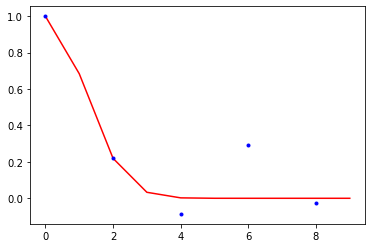

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 398
Number of inner iterations in outer iteration number 2: 279
Number of inner iterations in outer iteration number 3: 119
Number of inner iterations in outer iteration number 4: 33
Number of inner iterations in outer iteration number 5: 5

Background contribution to cost function [395.01156564 404.09799983 403.21452712 403.35757037 403.36636283]
Observation contribution to cost function [278.18448001 277.03645868 276.75307833 276.7389678  276.69097753]
Model contribution to cost function  [425.15365017 422.29568242 423.42942183 423.3023866  423.34108703]
The values of the cost function total [1098.34969582 1103.43014093 1103.39702727 1103.39892478 1103.39842739]
RMS between background/truth and analysis/truth [1.09481916 0.95173372]
New estimate for variance coming from assimilation window 17: 0.11957406159218267
New estimate for correlation length coming from assimilation window 17: 1.052647854000813


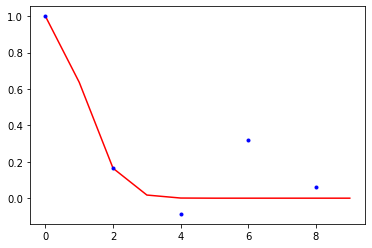

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 414
Number of inner iterations in outer iteration number 2: 289
Number of inner iterations in outer iteration number 3: 96
Number of inner iterations in outer iteration number 4: 31
Number of inner iterations in outer iteration number 5: 7

Background contribution to cost function [496.95390589 501.0281942  500.67356742 500.82569625 500.8467644 ]
Observation contribution to cost function [346.16234264 335.27477392 334.5838535  334.56819618 334.50227774]
Model contribution to cost function  [560.59063871 541.45005107 542.48495949 542.34920883 542.39319989]
The values of the cost function total [1403.70688724 1377.7530192  1377.74238041 1377.74310126 1377.74224203]
RMS between background/truth and analysis/truth [1.23666968 1.08556419]
New estimate for variance coming from assimilation window 18: 0.13533754442925638
New estimate for correlation length coming from assimilation window 18: 0.7389779416753883


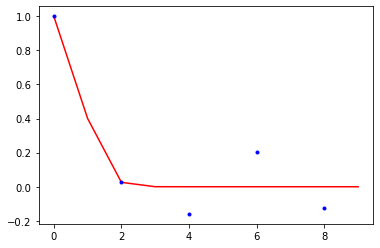

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 404
Number of inner iterations in outer iteration number 2: 283
Number of inner iterations in outer iteration number 3: 115
Number of inner iterations in outer iteration number 4: 33
Number of inner iterations in outer iteration number 5: 8

Background contribution to cost function [506.03711463 512.23808569 512.21085958 512.41096177 512.43801966]
Observation contribution to cost function [342.92726804 327.90871375 327.05769333 327.03431713 326.96896814]
Model contribution to cost function  [807.95363164 756.98569945 757.84321626 757.665419   757.70311139]
The values of the cost function total [1656.91801431 1597.13249889 1597.11176917 1597.1106979  1597.11009918]
RMS between background/truth and analysis/truth [1.38954304 1.20039297]
New estimate for variance coming from assimilation window 19: 0.2402197854428795
New estimate for correlation length coming from assimilation window 19: 1.0232947880165932


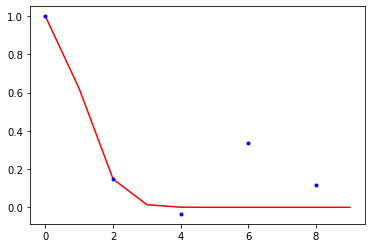

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [45.27901204 45.28168981 45.28367739 45.2856681  45.28458115]
Observation contribution to cost function [135.51434808 135.52099842 135.51940204 135.50947743 135.51382267]
Model contribution to cost function  [233.83295521 233.68594982 233.68546066 233.69339406 233.69012905]
The values of the cost function total [414.62631533 414.48863805 414.48854009 414.48853959 414.48853288]
RMS between background/truth and analysis/truth [0.30325501 0.2026301 ]
New estimate for variance coming from assimilation window 0: 0.031796744810127314
New estimate for correlation length coming from assimilation window 0: 2.744990391893973


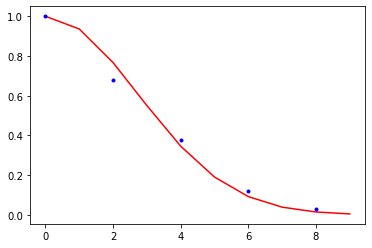

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 283
Number of inner iterations in outer iteration number 2: 101
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [27.10284977 27.12208767 27.1226585  27.12221718 27.12203502]
Observation contribution to cost function [64.55334698 64.40786671 64.40508316 64.40575766 64.40441753]
Model contribution to cost function  [94.89822195 94.90795747 94.91015311 94.90991491 94.91144641]
The values of the cost function total [186.5544187  186.43791185 186.43789477 186.43788975 186.43789896]
RMS between background/truth and analysis/truth [0.38518995 0.21666041]
New estimate for variance coming from assimilation window 1: 0.05034891455508719
New estimate for correlation length coming from assimilation window 1: 2.693179376923491


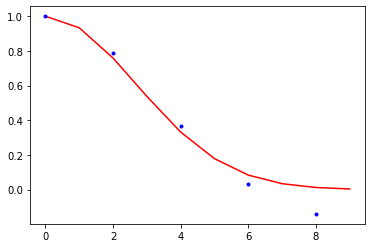

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 343
Number of inner iterations in outer iteration number 2: 129
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [21.65154283 21.60909844 21.60948913 21.6093938  21.60931424]
Observation contribution to cost function [48.94735734 48.84615038 48.8452902  48.84527659 48.84519405]
Model contribution to cost function  [83.06384424 82.53461146 82.53508072 82.53518929 82.53535234]
The values of the cost function total [153.66274441 152.98986027 152.98986005 152.98985969 152.98986064]
RMS between background/truth and analysis/truth [0.39358856 0.20518424]
New estimate for variance coming from assimilation window 2: 0.04877793505002605
New estimate for correlation length coming from assimilation window 2: 2.5593561773571496


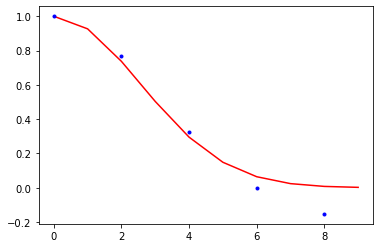

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 365
Number of inner iterations in outer iteration number 2: 145
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.02482854 24.04285521 24.04364534 24.04364134 24.0435235 ]
Observation contribution to cost function [50.34415284 50.20709163 50.20404118 50.20372967 50.20427669]
Model contribution to cost function  [80.3119944  80.01825619 80.02053372 80.0208548  80.02041937]
The values of the cost function total [154.68097578 154.26820303 154.26822024 154.26822581 154.26821956]
RMS between background/truth and analysis/truth [0.35533589 0.19332257]
New estimate for variance coming from assimilation window 3: 0.040046621881648314
New estimate for correlation length coming from assimilation window 3: 2.4795281454663427


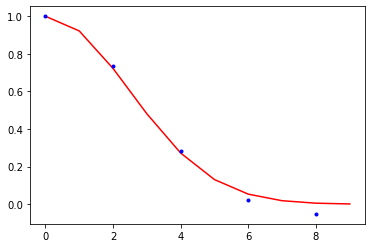

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 335
Number of inner iterations in outer iteration number 2: 149
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [21.81434838 21.71114908 21.71246855 21.71230698 21.71217754]
Observation contribution to cost function [52.76054766 52.36345719 52.35911653 52.35925609 52.35944293]
Model contribution to cost function  [78.56952115 78.89024518 78.89329536 78.89330927 78.89324651]
The values of the cost function total [153.14441719 152.96485146 152.96488044 152.96487234 152.96486698]
RMS between background/truth and analysis/truth [0.39579726 0.18338743]
New estimate for variance coming from assimilation window 4: 0.049020179496628
New estimate for correlation length coming from assimilation window 4: 3.602825227773724


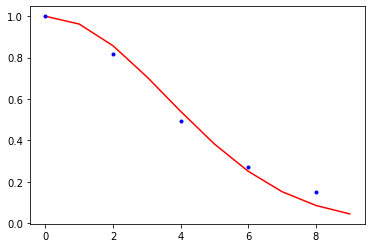

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 393
Number of inner iterations in outer iteration number 2: 143
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.07030736 24.12370386 24.12450443 24.12425797 24.12417358]
Observation contribution to cost function [61.55490364 61.55822867 61.55571973 61.55623679 61.55446657]
Model contribution to cost function  [92.62743465 92.37811098 92.37981026 92.37953203 92.38139131]
The values of the cost function total [178.25264565 178.06004352 178.06003442 178.06002679 178.06003146]
RMS between background/truth and analysis/truth [0.38682737 0.18298416]
New estimate for variance coming from assimilation window 5: 0.0575967613720376
New estimate for correlation length coming from assimilation window 5: 2.8338756267131315


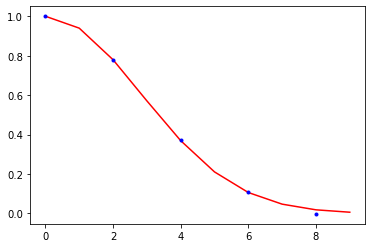

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 413
Number of inner iterations in outer iteration number 2: 151
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [23.91031688 23.93667192 23.93756477 23.93733119 23.93720044]
Observation contribution to cost function [63.80995982 63.74392647 63.74182653 63.74241914 63.74076988]
Model contribution to cost function  [77.57863465 77.57811297 77.57929161 77.57892971 77.58071979]
The values of the cost function total [165.29891135 165.25871137 165.25868291 165.25868003 165.25869011]
RMS between background/truth and analysis/truth [0.33640694 0.18820508]
New estimate for variance coming from assimilation window 6: 0.040033083718197686
New estimate for correlation length coming from assimilation window 6: 2.241608698301036


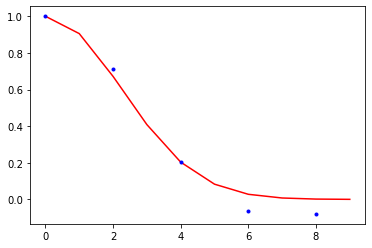

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 393
Number of inner iterations in outer iteration number 2: 147
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [32.74336006 32.72711362 32.72822897 32.72811294 32.72793418]
Observation contribution to cost function [58.42312736 58.19664975 58.19151152 58.18905189 58.19216593]
Model contribution to cost function  [72.7839672  72.33899493 72.34290074 72.34548407 72.34254049]
The values of the cost function total [163.95045462 163.26275829 163.26264123 163.2626489  163.26264059]
RMS between background/truth and analysis/truth [0.34952879 0.19248398]
New estimate for variance coming from assimilation window 7: 0.045181363795458174
New estimate for correlation length coming from assimilation window 7: 3.1406315986871642


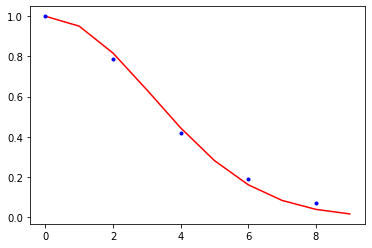

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 404
Number of inner iterations in outer iteration number 2: 145
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [41.31886409 41.19449801 41.19619502 41.195619   41.19525633]
Observation contribution to cost function [74.22818567 74.03436499 74.02626549 74.02729712 74.0270563 ]
Model contribution to cost function  [88.59536689 89.00060289 89.00693726 89.0064791  89.00709177]
The values of the cost function total [204.14241665 204.22946588 204.22939777 204.22939521 204.22940439]
RMS between background/truth and analysis/truth [0.35778893 0.2127921 ]
New estimate for variance coming from assimilation window 8: 0.044387133625615444
New estimate for correlation length coming from assimilation window 8: 2.574200613039562


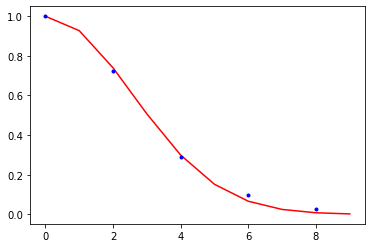

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 406
Number of inner iterations in outer iteration number 2: 157
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [34.23047723 34.34690565 34.35020019 34.3500224  34.34985631]
Observation contribution to cost function [65.80717886 66.32385066 66.31776625 66.31661375 66.31843146]
Model contribution to cost function  [71.36377887 70.76811204 70.77089484 70.77222446 70.77057108]
The values of the cost function total [171.40143496 171.43886835 171.43886128 171.43886061 171.43885885]
RMS between background/truth and analysis/truth [0.37048738 0.20914636]
New estimate for variance coming from assimilation window 9: 0.03966930399402589
New estimate for correlation length coming from assimilation window 9: 2.791052253853685


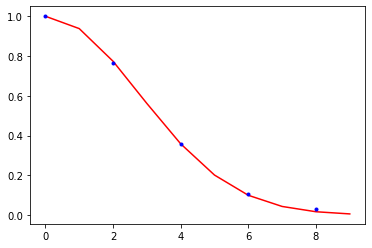

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 405
Number of inner iterations in outer iteration number 2: 168
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [42.78001869 42.83472534 42.83830937 42.83742371 42.83669932]
Observation contribution to cost function [67.95465321 68.12194573 68.10841887 68.11051205 68.11206262]
Model contribution to cost function  [78.58513108 78.35995348 78.36972438 78.36850952 78.36768504]
The values of the cost function total [189.31980298 189.31662454 189.31645262 189.31644529 189.31644699]
RMS between background/truth and analysis/truth [0.38948853 0.22642075]
New estimate for variance coming from assimilation window 10: 0.050331716183764474
New estimate for correlation length coming from assimilation window 10: 2.8636436604585715


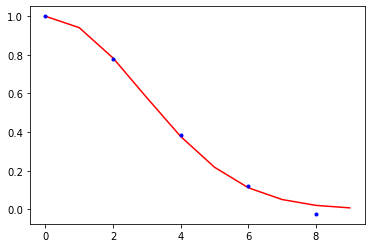

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 402
Number of inner iterations in outer iteration number 2: 145
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [47.8365972  47.66345224 47.66483495 47.66425733 47.66381136]
Observation contribution to cost function [73.25296328 73.03893858 73.02886043 73.02918895 73.02960541]
Model contribution to cost function  [84.58994928 84.2540583  84.26234756 84.26258947 84.26262611]
The values of the cost function total [205.67950976 204.95644912 204.95604294 204.95603575 204.95604288]
RMS between background/truth and analysis/truth [0.37090932 0.23631228]
New estimate for variance coming from assimilation window 11: 0.045618408864828576
New estimate for correlation length coming from assimilation window 11: 2.813963180431906


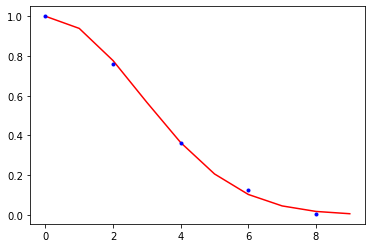

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 419
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 4
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [62.17186191 61.9771501  61.97395951 61.97250286 61.97218791]
Observation contribution to cost function [88.22999889 88.50003046 88.49268132 88.49345625 88.49398274]
Model contribution to cost function  [90.3445892  89.85899992 89.86789117 89.86854141 89.86832423]
The values of the cost function total [240.74645    240.33618048 240.33453199 240.33450052 240.33449488]
RMS between background/truth and analysis/truth [0.39909457 0.24958282]
New estimate for variance coming from assimilation window 12: 0.048728034264907384
New estimate for correlation length coming from assimilation window 12: 2.448508573716686


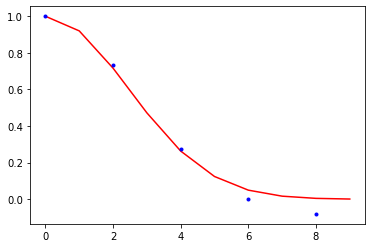

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 409
Number of inner iterations in outer iteration number 2: 175
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [79.47719074 79.66358794 79.67640415 79.67560401 79.67488376]
Observation contribution to cost function [92.18908696 93.25791162 93.23442508 93.23442816 93.23659204]
Model contribution to cost function  [88.78679762 87.45028549 87.46080113 87.46159354 87.46015306]
The values of the cost function total [260.45307532 260.37178505 260.37163035 260.3716257  260.37162886]
RMS between background/truth and analysis/truth [0.43356889 0.283457  ]
New estimate for variance coming from assimilation window 13: 0.04630852105925631
New estimate for correlation length coming from assimilation window 13: 3.221407545972666


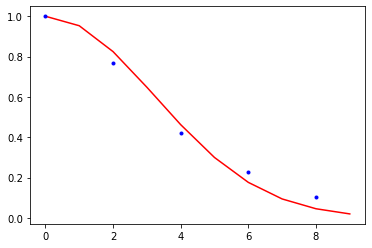

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 420
Number of inner iterations in outer iteration number 2: 186
Number of inner iterations in outer iteration number 3: 19
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [87.52592314 87.81962486 87.81575398 87.81486991 87.81325304]
Observation contribution to cost function [107.34537537 106.64712311 106.6333438  106.63381947 106.63561015]
Model contribution to cost function  [121.7913424  120.82329535 120.84039505 120.84079932 120.8406223 ]
The values of the cost function total [316.66264091 315.29004332 315.28949283 315.2894887  315.28948549]
RMS between background/truth and analysis/truth [0.5051185  0.30700662]
New estimate for variance coming from assimilation window 14: 0.06992059322869341
New estimate for correlation length coming from assimilation window 14: 2.261527225950263


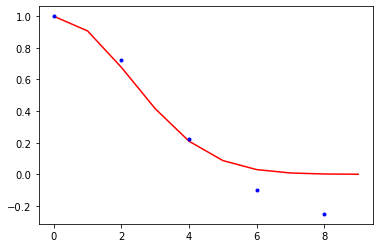

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 416
Number of inner iterations in outer iteration number 2: 173
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 4
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [117.7941905  117.14093595 117.15969781 117.1569025  117.15569414]
Observation contribution to cost function [118.80518093 119.2992878  119.24083017 119.24332097 119.24495195]
Model contribution to cost function  [109.02992455 107.01201089 107.05006479 107.05036562 107.04994843]
The values of the cost function total [345.62929598 343.45223464 343.45059277 343.45058909 343.45059451]
RMS between background/truth and analysis/truth [0.49724619 0.3308582 ]
New estimate for variance coming from assimilation window 15: 0.04586565551581976
New estimate for correlation length coming from assimilation window 15: 2.4857205468977757


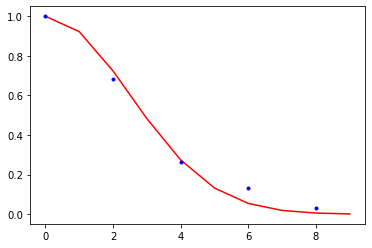

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 423
Number of inner iterations in outer iteration number 2: 192
Number of inner iterations in outer iteration number 3: 28
Number of inner iterations in outer iteration number 4: 6
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [101.04250839 100.07378906 100.04913476 100.04511299 100.04455556]
Observation contribution to cost function [103.36860068 102.1257986  102.08485769 102.08416046 102.08430588]
Model contribution to cost function  [118.91269654 118.31795935 118.37758324 118.38224433 118.3826602 ]
The values of the cost function total [323.32380561 320.51754702 320.51157569 320.51151778 320.51152164]
RMS between background/truth and analysis/truth [0.53639033 0.36365455]
New estimate for variance coming from assimilation window 16: 0.06722389352092509
New estimate for correlation length coming from assimilation window 16: 3.163607696600452


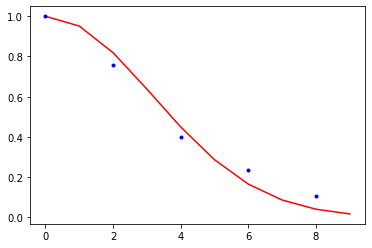

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 440
Number of inner iterations in outer iteration number 2: 211
Number of inner iterations in outer iteration number 3: 44
Number of inner iterations in outer iteration number 4: 14
Number of inner iterations in outer iteration number 5: 4

Background contribution to cost function [141.82576298 139.02386625 138.89954282 138.88716233 138.88473164]
Observation contribution to cost function [142.95790824 139.71754729 139.61886974 139.61078551 139.61053355]
Model contribution to cost function  [162.30973083 162.5238219  162.73480022 162.75489661 162.75755223]
The values of the cost function total [447.09340205 441.26523545 441.25321277 441.25284445 441.25281743]
RMS between background/truth and analysis/truth [0.57263909 0.40076095]
New estimate for variance coming from assimilation window 17: 0.08004733326297159
New estimate for correlation length coming from assimilation window 17: 2.3329110090696785


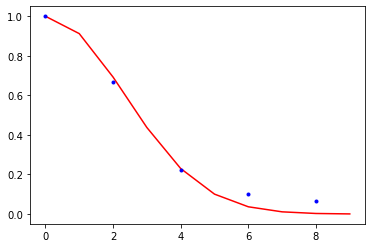

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 442
Number of inner iterations in outer iteration number 2: 225
Number of inner iterations in outer iteration number 3: 85
Number of inner iterations in outer iteration number 4: 33
Number of inner iterations in outer iteration number 5: 14

Background contribution to cost function [258.30114967 251.39428051 250.95257123 250.89166579 250.88457542]
Observation contribution to cost function [227.7886173  223.412695   222.99863275 222.97309644 222.95998447]
Model contribution to cost function  [201.03388893 197.49963648 198.30971259 198.39264834 198.41247093]
The values of the cost function total [687.1236559  672.30661199 672.26091657 672.25741057 672.25703082]
RMS between background/truth and analysis/truth [0.59620831 0.45201304]
New estimate for variance coming from assimilation window 18: 0.06834423280654564
New estimate for correlation length coming from assimilation window 18: 1.9075584786305781


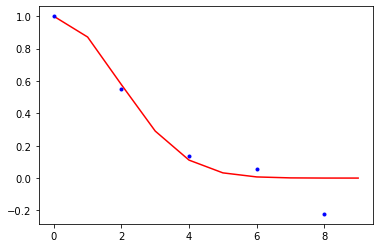

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 420
Number of inner iterations in outer iteration number 2: 229
Number of inner iterations in outer iteration number 3: 87
Number of inner iterations in outer iteration number 4: 45
Number of inner iterations in outer iteration number 5: 22

Background contribution to cost function [383.61068844 373.61655346 373.31472717 373.23548775 373.23460303]
Observation contribution to cost function [312.1152845  305.68083776 303.89857441 303.69715099 303.63147011]
Model contribution to cost function  [278.96336881 272.74939564 274.68722819 274.95234006 275.01760094]
The values of the cost function total [974.68934175 952.04678686 951.90052978 951.8849788  951.88367408]
RMS between background/truth and analysis/truth [0.68041126 0.49620995]
New estimate for variance coming from assimilation window 19: 0.08558546006476159
New estimate for correlation length coming from assimilation window 19: 2.0300577912341566


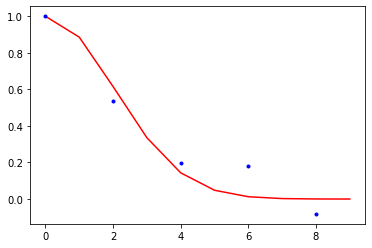

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [41.58680447 41.65965325 41.66078695 41.66343687 41.6622054 ]
Observation contribution to cost function [160.96840264 160.80255185 160.80574407 160.79439104 160.79963272]
Model contribution to cost function  [268.56959712 268.73845381 268.73415866 268.74285684 268.73883929]
The values of the cost function total [471.12480423 471.2006589  471.20068968 471.20068475 471.20067741]
RMS between background/truth and analysis/truth [0.30412378 0.20701526]
New estimate for variance coming from assimilation window 0: 0.03498748373254876
New estimate for correlation length coming from assimilation window 0: 2.505018608274996


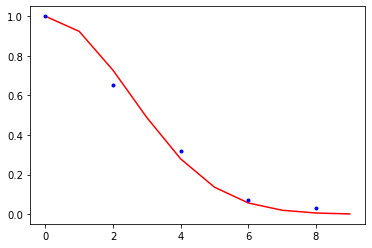

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 285
Number of inner iterations in outer iteration number 2: 125
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.46819374 24.42572491 24.42634401 24.42630655 24.42599343]
Observation contribution to cost function [69.76130695 69.67742311 69.67425611 69.67142776 69.67516909]
Model contribution to cost function  [100.36036296  99.51297272  99.51553204  99.51840078  99.51496726]
The values of the cost function total [194.58986365 193.61612074 193.61613217 193.61613509 193.61612979]
RMS between background/truth and analysis/truth [0.42000419 0.21521795]
New estimate for variance coming from assimilation window 1: 0.045418381212793235
New estimate for correlation length coming from assimilation window 1: 2.9621424468318103


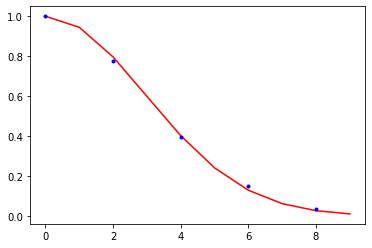

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 355
Number of inner iterations in outer iteration number 2: 133
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [25.52002492 25.46647258 25.46746254 25.46721531 25.46703615]
Observation contribution to cost function [53.91384883 54.05486761 54.05270141 54.05320312 54.05353981]
Model contribution to cost function  [83.70823767 83.4463517  83.44752681 83.44726914 83.44710907]
The values of the cost function total [163.14211142 162.96769189 162.96769076 162.96768756 162.96768504]
RMS between background/truth and analysis/truth [0.36996823 0.19382119]
New estimate for variance coming from assimilation window 2: 0.04595627807491271
New estimate for correlation length coming from assimilation window 2: 2.5409318197844506


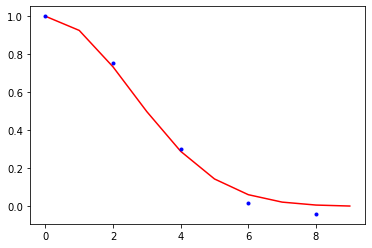

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 363
Number of inner iterations in outer iteration number 2: 151
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [21.39056167 21.37179749 21.3721669  21.37213223 21.37204209]
Observation contribution to cost function [58.56478895 58.34913682 58.34593849 58.34500464 58.3461458 ]
Model contribution to cost function  [88.26006693 88.03278596 88.03556163 88.03653595 88.03547926]
The values of the cost function total [168.21541755 167.75372026 167.75366702 167.75367282 167.75366715]
RMS between background/truth and analysis/truth [0.3770879  0.18518005]
New estimate for variance coming from assimilation window 3: 0.05216452008781389
New estimate for correlation length coming from assimilation window 3: 2.755143476674433


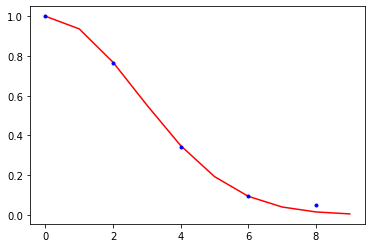

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 363
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 5
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [29.92178268 29.82393294 29.82547923 29.82520401 29.82511489]
Observation contribution to cost function [58.45629936 58.51324647 58.51080399 58.51114795 58.50855575]
Model contribution to cost function  [81.64301467 81.21073592 81.21159933 81.21153163 81.21422474]
The values of the cost function total [170.0210967  169.54791533 169.54788256 169.54788359 169.54789539]
RMS between background/truth and analysis/truth [0.39698035 0.17324143]
New estimate for variance coming from assimilation window 4: 0.06200937869269905
New estimate for correlation length coming from assimilation window 4: 3.8538576504242226


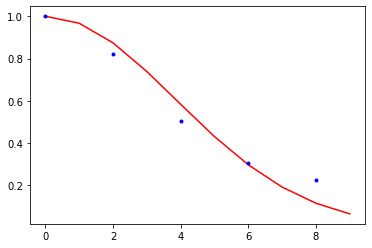

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 463
Number of inner iterations in outer iteration number 2: 197
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [29.30841825 29.27582574 29.27734762 29.27711573 29.27689695]
Observation contribution to cost function [71.81786448 71.70606189 71.7028729  71.7031717  71.70349804]
Model contribution to cost function  [78.42154806 77.75825567 77.75992696 77.75986246 77.75975868]
The values of the cost function total [179.54783079 178.7401433  178.74014748 178.74014989 178.74015367]
RMS between background/truth and analysis/truth [0.34535739 0.17449793]
New estimate for variance coming from assimilation window 5: 0.05002105342223953
New estimate for correlation length coming from assimilation window 5: 3.1361849263605426


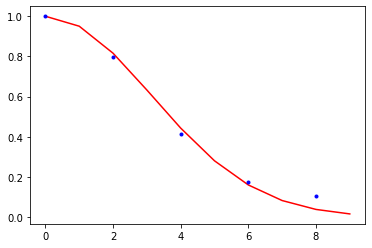

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 479
Number of inner iterations in outer iteration number 2: 181
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [31.57415734 31.68703322 31.69142058 31.69118205 31.69113371]
Observation contribution to cost function [81.69679851 81.7427078  81.73456649 81.73501317 81.73330498]
Model contribution to cost function  [68.4985354  68.44223545 68.44594776 68.44573951 68.44750995]
The values of the cost function total [181.76949125 181.87197647 181.87193484 181.87193474 181.87194864]
RMS between background/truth and analysis/truth [0.34793322 0.18591324]
New estimate for variance coming from assimilation window 6: 0.04371652693269724
New estimate for correlation length coming from assimilation window 6: 2.985345334982296


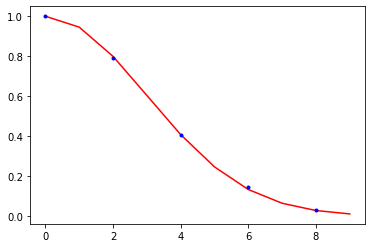

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 468
Number of inner iterations in outer iteration number 2: 183
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [37.52334827 37.44737547 37.45094332 37.4507745  37.45033586]
Observation contribution to cost function [65.44330118 65.36478295 65.35672399 65.35629395 65.35757924]
Model contribution to cost function  [62.37846171 62.10017376 62.10450217 62.10510003 62.10425285]
The values of the cost function total [165.34511115 164.91233219 164.91216948 164.91216848 164.91216795]
RMS between background/truth and analysis/truth [0.33674298 0.19589755]
New estimate for variance coming from assimilation window 7: 0.03922297242683896
New estimate for correlation length coming from assimilation window 7: 3.177415012414367


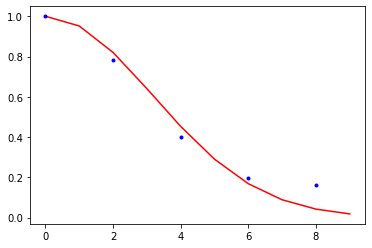

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 458
Number of inner iterations in outer iteration number 2: 165
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [60.65518187 60.72369587 60.73476253 60.73358276 60.73315707]
Observation contribution to cost function [85.53832324 85.76896301 85.75435203 85.7549738  85.75622745]
Model contribution to cost function  [80.54244166 80.25388383 80.25729161 80.25785669 80.25702956]
The values of the cost function total [226.73594678 226.74654271 226.74640617 226.74641325 226.74641407]
RMS between background/truth and analysis/truth [0.36151414 0.20727943]
New estimate for variance coming from assimilation window 8: 0.04769498325598755
New estimate for correlation length coming from assimilation window 8: 2.5616636809549544


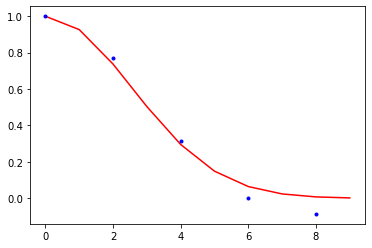

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 441
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [66.27430443 66.25101494 66.2662786  66.26555031 66.26512576]
Observation contribution to cost function [81.3891366  81.08060688 81.06064639 81.06100481 81.06250207]
Model contribution to cost function  [81.82348519 82.41359386 82.41797217 82.41835623 82.41728477]
The values of the cost function total [229.48692622 229.74521567 229.74489716 229.74491135 229.7449126 ]
RMS between background/truth and analysis/truth [0.40189903 0.2260332 ]
New estimate for variance coming from assimilation window 9: 0.05256001378366283
New estimate for correlation length coming from assimilation window 9: 3.3075963025091095


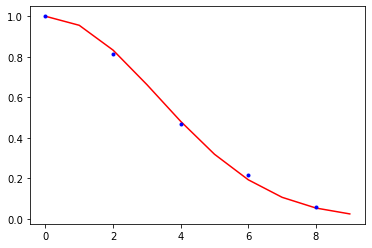

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 451
Number of inner iterations in outer iteration number 2: 181
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [62.72838096 62.72345143 62.72573178 62.72462632 62.72402402]
Observation contribution to cost function [85.90518739 85.63810265 85.63149757 85.63332276 85.63420261]
Model contribution to cost function  [106.05846113 106.80042891 106.8046579  106.80394841 106.80366884]
The values of the cost function total [254.69202948 255.16198299 255.16188725 255.16189748 255.16189547]
RMS between background/truth and analysis/truth [0.43521781 0.22500886]
New estimate for variance coming from assimilation window 10: 0.07110401858541776
New estimate for correlation length coming from assimilation window 10: 2.541949309377786


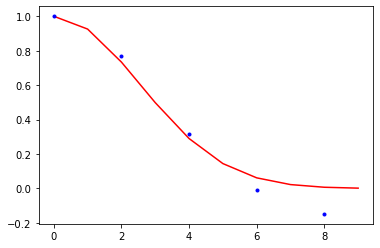

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 480
Number of inner iterations in outer iteration number 2: 185
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [47.5276368  47.76913329 47.77110019 47.77069961 47.77035488]
Observation contribution to cost function [81.30487953 81.56865212 81.55949531 81.55989393 81.56107705]
Model contribution to cost function  [82.15994023 81.98989579 81.99694048 81.99694802 81.99610561]
The values of the cost function total [210.99245657 211.3276812  211.32753598 211.32754156 211.32753754]
RMS between background/truth and analysis/truth [0.39802688 0.22995069]
New estimate for variance coming from assimilation window 11: 0.04782227732267794
New estimate for correlation length coming from assimilation window 11: 3.1541138855073725


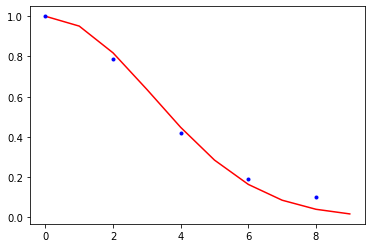

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 460
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [62.68626268 62.90316025 62.90777254 62.90713417 62.90705311]
Observation contribution to cost function [86.1374625  86.42676295 86.4130813  86.41404077 86.41486975]
Model contribution to cost function  [92.47999102 92.19885406 92.20791463 92.20760615 92.20684884]
The values of the cost function total [241.30371619 241.52877726 241.52876848 241.52878108 241.5287717 ]
RMS between background/truth and analysis/truth [0.39023886 0.21799171]
New estimate for variance coming from assimilation window 12: 0.04453218779698705
New estimate for correlation length coming from assimilation window 12: 1.9661585867607898


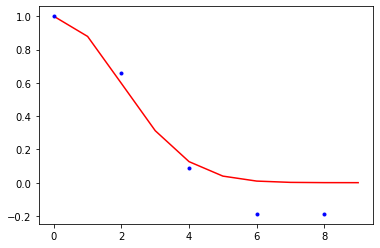

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 433
Number of inner iterations in outer iteration number 2: 179
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [54.98415904 54.97432712 54.97655114 54.9764375  54.97640456]
Observation contribution to cost function [60.43217356 60.49556196 60.49198113 60.49226294 60.4889318 ]
Model contribution to cost function  [76.80713858 76.00101269 76.0024091  76.00223927 76.00561042]
The values of the cost function total [192.22347118 191.47090177 191.47094136 191.47093972 191.47094678]
RMS between background/truth and analysis/truth [0.41745801 0.21950106]
New estimate for variance coming from assimilation window 13: 0.05027718277992713
New estimate for correlation length coming from assimilation window 13: 3.3437965480974214


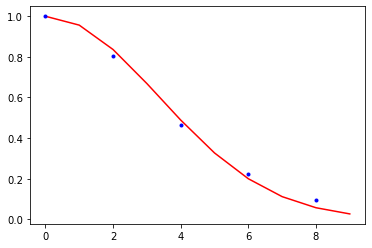

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 464
Number of inner iterations in outer iteration number 2: 201
Number of inner iterations in outer iteration number 3: 14
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [64.96931784 64.99851363 64.99664199 64.99648818 64.99637181]
Observation contribution to cost function [94.27588477 94.02234528 94.01671474 94.01852878 94.0174115 ]
Model contribution to cost function  [102.62111995 102.81716887 102.82464948 102.82298623 102.82421719]
The values of the cost function total [261.86632256 261.83802778 261.83800621 261.83800319 261.83800049]
RMS between background/truth and analysis/truth [0.40930254 0.22308361]
New estimate for variance coming from assimilation window 14: 0.055283281553319547
New estimate for correlation length coming from assimilation window 14: 2.456489167392963


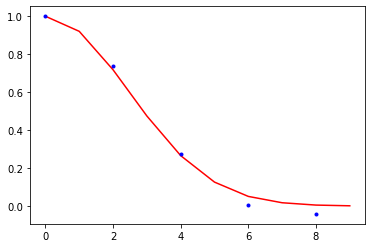

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 447
Number of inner iterations in outer iteration number 2: 167
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [53.34318187 53.38378818 53.39024901 53.38973138 53.38936269]
Observation contribution to cost function [64.37411774 64.18344321 64.17352353 64.17160232 64.17456758]
Model contribution to cost function  [76.61215802 76.5404125  76.54394143 76.54639262 76.5437948 ]
The values of the cost function total [194.32945763 194.10764389 194.10771397 194.10772632 194.10772507]
RMS between background/truth and analysis/truth [0.43083569 0.22173577]
New estimate for variance coming from assimilation window 15: 0.05488854294060004
New estimate for correlation length coming from assimilation window 15: 3.187280299936021


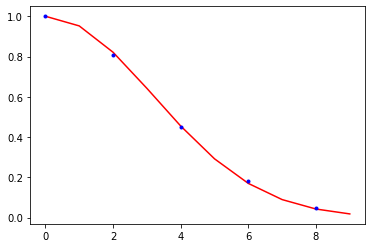

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 447
Number of inner iterations in outer iteration number 2: 185
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [41.54993898 41.58863353 41.59203876 41.59146981 41.5912967 ]
Observation contribution to cost function [68.38039853 68.49864143 68.49090794 68.49203644 68.48970698]
Model contribution to cost function  [89.29901315 89.13650504 89.14080968 89.14024884 89.14275785]
The values of the cost function total [199.22935066 199.22377999 199.22375638 199.22375509 199.22376152]
RMS between background/truth and analysis/truth [0.39503685 0.23043855]
New estimate for variance coming from assimilation window 16: 0.05750911543175981
New estimate for correlation length coming from assimilation window 16: 3.069430985669934


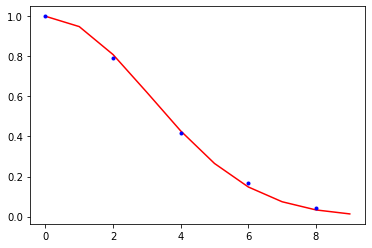

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 463
Number of inner iterations in outer iteration number 2: 171
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [33.19602508 33.27403527 33.27569404 33.27555383 33.27545766]
Observation contribution to cost function [71.7885545  71.63994933 71.63532237 71.63557318 71.63457443]
Model contribution to cost function  [77.42394859 77.00483068 77.00780732 77.00769218 77.00879064]
The values of the cost function total [182.40852817 181.91881528 181.91882374 181.91881919 181.91882274]
RMS between background/truth and analysis/truth [0.39767931 0.23399894]
New estimate for variance coming from assimilation window 17: 0.04976921028143984
New estimate for correlation length coming from assimilation window 17: 3.612192149918569


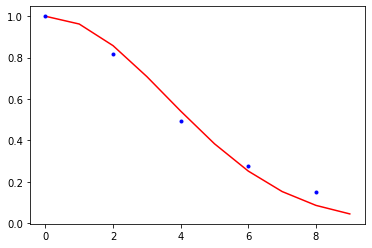

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 459
Number of inner iterations in outer iteration number 2: 195
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 3
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [49.23360928 49.35138716 49.35461114 49.3538126  49.35348183]
Observation contribution to cost function [67.71976176 67.7628611  67.75463391 67.75426865 67.75676148]
Model contribution to cost function  [80.11659034 79.25703012 79.26201843 79.26318498 79.26102667]
The values of the cost function total [197.06996138 196.37127837 196.37126348 196.37126623 196.37126997]
RMS between background/truth and analysis/truth [0.42073612 0.24712004]
New estimate for variance coming from assimilation window 18: 0.05559629596785201
New estimate for correlation length coming from assimilation window 18: 4.527610406405931


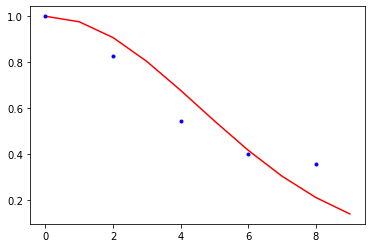

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 486
Number of inner iterations in outer iteration number 2: 169
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [53.14832004 53.11330267 53.11896772 53.11888154 53.11844185]
Observation contribution to cost function [86.49169369 86.68139627 86.6705206  86.66889264 86.67135097]
Model contribution to cost function  [73.99954439 73.2756607  73.28063143 73.28234216 73.28032453]
The values of the cost function total [213.63955812 213.07035964 213.07011976 213.07011634 213.07011736]
RMS between background/truth and analysis/truth [0.38954775 0.24609814]
New estimate for variance coming from assimilation window 19: 0.038357803603916885
New estimate for correlation length coming from assimilation window 19: 2.7487883944275864


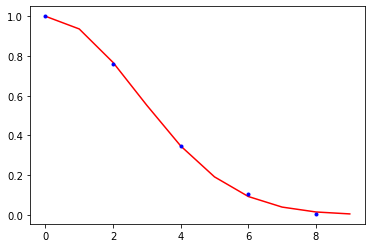

ASSIMILATION WINDOW NUMBER 0


Number of inner iterations in outer iteration number 1: 31
Number of inner iterations in outer iteration number 2: 7
Number of inner iterations in outer iteration number 3: 1
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [61.35338824 61.27230715 61.2716252  61.27641089 61.27241929]
Observation contribution to cost function [166.01135937 166.05339926 166.06463516 166.04110949 166.05507493]
Model contribution to cost function  [277.57888546 277.0251033  277.01449093 277.03322824 277.02324557]
The values of the cost function total [504.94363307 504.3508097  504.35075129 504.35074862 504.35073979]
RMS between background/truth and analysis/truth [0.33412466 0.22645276]
New estimate for variance coming from assimilation window 0: 0.03866928007333774
New estimate for correlation length coming from assimilation window 0: 2.6226744472862413


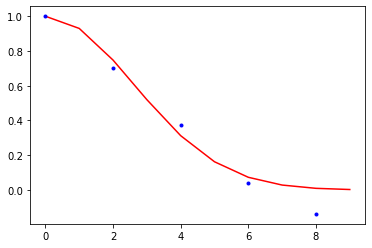

ASSIMILATION WINDOW NUMBER 1


Number of inner iterations in outer iteration number 1: 323
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [29.23802204 28.96099782 28.96130748 28.96137517 28.96142222]
Observation contribution to cost function [53.37996298 52.62106992 52.61893939 52.61628263 52.61906655]
Model contribution to cost function  [88.80172363 89.12221713 89.12411633 89.12671334 89.12387715]
The values of the cost function total [171.41970864 170.70428487 170.7043632  170.70437115 170.70436593]
RMS between background/truth and analysis/truth [0.40635537 0.22524978]
New estimate for variance coming from assimilation window 1: 0.04478827005040046
New estimate for correlation length coming from assimilation window 1: 2.498343187671443


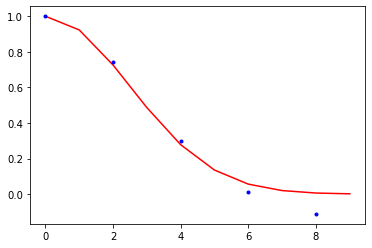

ASSIMILATION WINDOW NUMBER 2


Number of inner iterations in outer iteration number 1: 336
Number of inner iterations in outer iteration number 2: 131
Number of inner iterations in outer iteration number 3: 3
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [28.85774782 28.89754358 28.89891453 28.89853404 28.89843174]
Observation contribution to cost function [53.70900223 53.66303638 53.65887696 53.65975    53.65917887]
Model contribution to cost function  [92.78491603 92.2944006  92.29718206 92.29668681 92.29736582]
The values of the cost function total [175.35166608 174.85498056 174.85497355 174.85497085 174.85497644]
RMS between background/truth and analysis/truth [0.37848012 0.20771827]
New estimate for variance coming from assimilation window 2: 0.045441911467096155
New estimate for correlation length coming from assimilation window 2: 2.5422574257442467


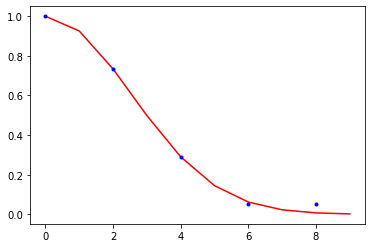

ASSIMILATION WINDOW NUMBER 3


Number of inner iterations in outer iteration number 1: 343
Number of inner iterations in outer iteration number 2: 151
Number of inner iterations in outer iteration number 3: 6
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [26.4734065  26.32483753 26.32656951 26.32620473 26.3259839 ]
Observation contribution to cost function [55.37804192 55.09939787 55.09101851 55.09254934 55.09803989]
Model contribution to cost function  [98.40971791 98.41205785 98.41869241 98.41752084 98.41225362]
The values of the cost function total [180.26116632 179.83629325 179.83628043 179.83627491 179.83627741]
RMS between background/truth and analysis/truth [0.41519712 0.20807596]
New estimate for variance coming from assimilation window 3: 0.058528796144174756
New estimate for correlation length coming from assimilation window 3: 4.19667549556304


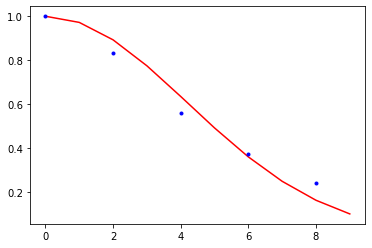

ASSIMILATION WINDOW NUMBER 4


Number of inner iterations in outer iteration number 1: 465
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 7
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [24.33763393 24.38717913 24.3876247  24.38748327 24.38723391]
Observation contribution to cost function [79.92128274 80.08458577 80.08277842 80.08098585 80.08306299]
Model contribution to cost function  [91.44547303 90.73596579 90.73736525 90.73929253 90.7374699 ]
The values of the cost function total [195.7043897  195.20773069 195.20776837 195.20776164 195.2077668 ]
RMS between background/truth and analysis/truth [0.41021265 0.20639841]
New estimate for variance coming from assimilation window 4: 0.06574871636431615
New estimate for correlation length coming from assimilation window 4: 2.884472013908628


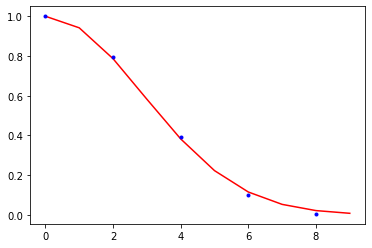

ASSIMILATION WINDOW NUMBER 5


Number of inner iterations in outer iteration number 1: 479
Number of inner iterations in outer iteration number 2: 171
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [33.74500168 33.79180741 33.79342221 33.79323834 33.79324644]
Observation contribution to cost function [71.45557569 71.70263883 71.69781149 71.69832644 71.69653422]
Model contribution to cost function  [77.56028955 77.13640311 77.13968421 77.13934902 77.14113574]
The values of the cost function total [182.76086692 182.63084936 182.63091791 182.6309138  182.63091641]
RMS between background/truth and analysis/truth [0.3818142  0.21728011]
New estimate for variance coming from assimilation window 5: 0.04832782868064911
New estimate for correlation length coming from assimilation window 5: 2.753375703835929


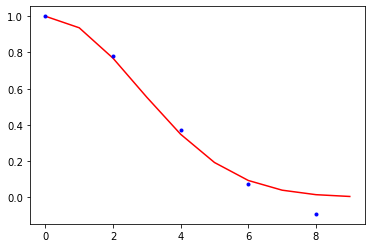

ASSIMILATION WINDOW NUMBER 6


Number of inner iterations in outer iteration number 1: 461
Number of inner iterations in outer iteration number 2: 203
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [43.73578683 43.89825009 43.90191426 43.90180594 43.90150633]
Observation contribution to cost function [77.71332805 77.55539887 77.54982274 77.54712534 77.55055903]
Model contribution to cost function  [90.14627041 90.07222891 90.07407065 90.07687049 90.07373806]
The values of the cost function total [211.59538529 211.52587787 211.52580765 211.52580177 211.52580341]
RMS between background/truth and analysis/truth [0.44142611 0.21206069]
New estimate for variance coming from assimilation window 6: 0.06809736184875587
New estimate for correlation length coming from assimilation window 6: 2.920347531421759


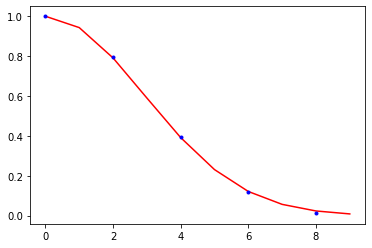

ASSIMILATION WINDOW NUMBER 7


Number of inner iterations in outer iteration number 1: 498
Number of inner iterations in outer iteration number 2: 163
Number of inner iterations in outer iteration number 3: 12
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [61.91256156 61.79303325 61.79702902 61.79687368 61.796658  ]
Observation contribution to cost function [89.60110257 89.43378808 89.4224245  89.42294332 89.42359191]
Model contribution to cost function  [81.14421719 81.33744939 81.3446111  81.34423818 81.34380439]
The values of the cost function total [232.65788132 232.56427072 232.56406461 232.56405518 232.56405431]
RMS between background/truth and analysis/truth [0.39057273 0.2265893 ]
New estimate for variance coming from assimilation window 7: 0.04950290882484239
New estimate for correlation length coming from assimilation window 7: 2.8074075674242733


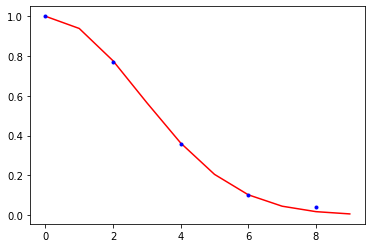

ASSIMILATION WINDOW NUMBER 8


Number of inner iterations in outer iteration number 1: 487
Number of inner iterations in outer iteration number 2: 189
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [78.80166456 78.47636946 78.49369393 78.49292708 78.49252861]
Observation contribution to cost function [87.37282399 86.76134814 86.73432613 86.73540594 86.73386658]
Model contribution to cost function  [69.71869259 69.75806664 69.76752531 69.76723451 69.76918138]
The values of the cost function total [235.89318113 234.99578423 234.99554537 234.99556754 234.99557656]
RMS between background/truth and analysis/truth [0.40495878 0.22246481]
New estimate for variance coming from assimilation window 8: 0.04252905516518862
New estimate for correlation length coming from assimilation window 8: 2.914953590114994


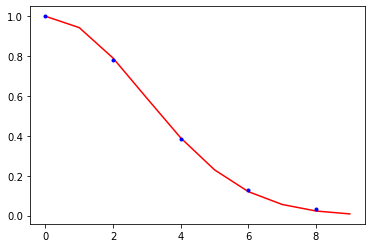

ASSIMILATION WINDOW NUMBER 9


Number of inner iterations in outer iteration number 1: 485
Number of inner iterations in outer iteration number 2: 213
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [60.30954184 60.60339198 60.61536193 60.61521529 60.61467819]
Observation contribution to cost function [83.44163545 83.77448231 83.75286924 83.75333611 83.75383477]
Model contribution to cost function  [81.17179498 79.77412111 79.78360856 79.78329541 79.78334707]
The values of the cost function total [224.92297228 224.1519954  224.15183973 224.15184681 224.15186003]
RMS between background/truth and analysis/truth [0.42579732 0.24050788]
New estimate for variance coming from assimilation window 9: 0.05318490452050687
New estimate for correlation length coming from assimilation window 9: 3.00494946649036


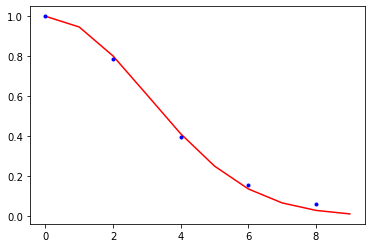

ASSIMILATION WINDOW NUMBER 10


Number of inner iterations in outer iteration number 1: 494
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [66.95526339 66.92615267 66.93741529 66.93713428 66.93657402]
Observation contribution to cost function [86.22090119 86.34964546 86.33173753 86.33106935 86.33267946]
Model contribution to cost function  [85.63350314 85.52336866 85.53003036 85.53097558 85.52994192]
The values of the cost function total [238.80966772 238.7991668  238.79918317 238.79917921 238.7991954 ]
RMS between background/truth and analysis/truth [0.40248527 0.23807443]
New estimate for variance coming from assimilation window 10: 0.05015321058044501
New estimate for correlation length coming from assimilation window 10: 2.261322347803929


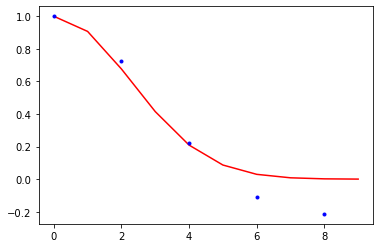

ASSIMILATION WINDOW NUMBER 11


Number of inner iterations in outer iteration number 1: 488
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [54.10230613 54.10166094 54.11190341 54.11107729 54.11076145]
Observation contribution to cost function [83.78784257 83.56512851 83.55043742 83.55139803 83.54904605]
Model contribution to cost function  [95.36574832 95.25307265 95.25729986 95.25718654 95.25987519]
The values of the cost function total [233.25589702 232.91986209 232.91964069 232.91966186 232.91968268]
RMS between background/truth and analysis/truth [0.4867749 0.2543583]
New estimate for variance coming from assimilation window 11: 0.06486985009306198
New estimate for correlation length coming from assimilation window 11: 2.813023943036349


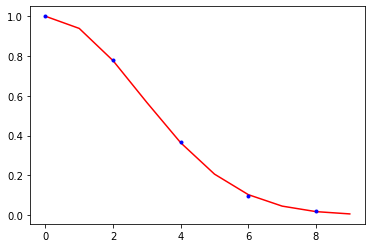

ASSIMILATION WINDOW NUMBER 12


Number of inner iterations in outer iteration number 1: 487
Number of inner iterations in outer iteration number 2: 213
Number of inner iterations in outer iteration number 3: 9
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [57.88845233 57.95997612 57.96390781 57.96323928 57.96297034]
Observation contribution to cost function [80.50172324 80.23704394 80.22770468 80.22879893 80.22709527]
Model contribution to cost function  [75.49931761 76.1018092  76.10706113 76.10664096 76.1086241 ]
The values of the cost function total [213.88949318 214.29882926 214.29867362 214.29867917 214.29868972]
RMS between background/truth and analysis/truth [0.45550456 0.26707688]
New estimate for variance coming from assimilation window 12: 0.04891066401859077
New estimate for correlation length coming from assimilation window 12: 3.367733339375406


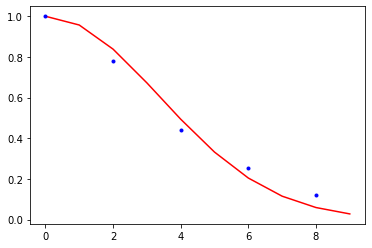

ASSIMILATION WINDOW NUMBER 13


Number of inner iterations in outer iteration number 1: 498
Number of inner iterations in outer iteration number 2: 203
Number of inner iterations in outer iteration number 3: 11
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [68.12336056 68.11641365 68.12731808 68.1269867  68.12643117]
Observation contribution to cost function [84.1070981  83.99366962 83.97614229 83.976648   83.97727954]
Model contribution to cost function  [81.39732492 80.12902981 80.13551851 80.13534749 80.13527445]
The values of the cost function total [233.62778359 232.23911308 232.23897888 232.23898218 232.23898516]
RMS between background/truth and analysis/truth [0.44734247 0.28180673]
New estimate for variance coming from assimilation window 13: 0.046947508904570154
New estimate for correlation length coming from assimilation window 13: 2.614808358352613


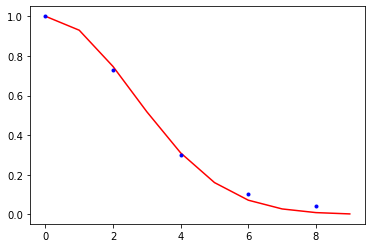

ASSIMILATION WINDOW NUMBER 14


Number of inner iterations in outer iteration number 1: 479
Number of inner iterations in outer iteration number 2: 223
Number of inner iterations in outer iteration number 3: 21
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [65.26944396 65.47737204 65.4943202  65.49469757 65.49376438]
Observation contribution to cost function [94.50341328 93.88007864 93.85006921 93.84815241 93.84961836]
Model contribution to cost function  [81.50742421 81.02009815 81.03283276 81.03437026 81.03383054]
The values of the cost function total [241.28028145 240.37754884 240.37722217 240.37722024 240.37721327]
RMS between background/truth and analysis/truth [0.46933387 0.29971778]
New estimate for variance coming from assimilation window 14: 0.04634361515485439
New estimate for correlation length coming from assimilation window 14: 2.9107120513399085


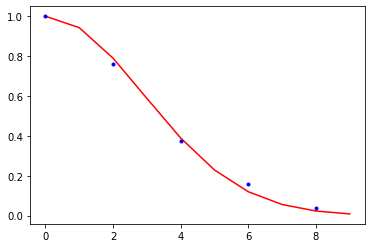

ASSIMILATION WINDOW NUMBER 15


Number of inner iterations in outer iteration number 1: 489
Number of inner iterations in outer iteration number 2: 250
Number of inner iterations in outer iteration number 3: 17
Number of inner iterations in outer iteration number 4: 1
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [101.68132135 101.46721282 101.48042979 101.47988631 101.47891057]
Observation contribution to cost function [110.87406709 110.59198258 110.57114084 110.56820691 110.56986329]
Model contribution to cost function  [118.91840509 117.34689278 117.35458074 117.35805914 117.35737035]
The values of the cost function total [331.47379352 329.40608818 329.40615137 329.40615236 329.4061442 ]
RMS between background/truth and analysis/truth [0.50718831 0.28774397]
New estimate for variance coming from assimilation window 15: 0.07280808567932731
New estimate for correlation length coming from assimilation window 15: 2.909051193702397


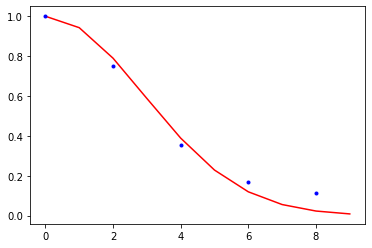

ASSIMILATION WINDOW NUMBER 16


Number of inner iterations in outer iteration number 1: 494
Number of inner iterations in outer iteration number 2: 237
Number of inner iterations in outer iteration number 3: 15
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [81.73508544 81.44856969 81.4608089  81.45969217 81.45867985]
Observation contribution to cost function [86.35463307 85.98769996 85.9636148  85.96470963 85.96625192]
Model contribution to cost function  [116.56302626 114.17129885 114.18303481 114.18306116 114.18253339]
The values of the cost function total [284.65274477 281.6075685  281.60745851 281.60746297 281.60746515]
RMS between background/truth and analysis/truth [0.50528838 0.30925546]
New estimate for variance coming from assimilation window 16: 0.06755115275967422
New estimate for correlation length coming from assimilation window 16: 2.7183388927483936


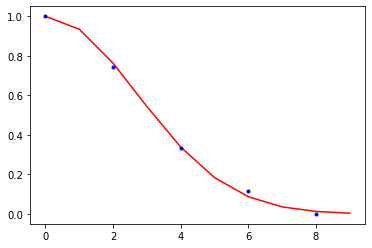

ASSIMILATION WINDOW NUMBER 17


Number of inner iterations in outer iteration number 1: 504
Number of inner iterations in outer iteration number 2: 205
Number of inner iterations in outer iteration number 3: 13
Number of inner iterations in outer iteration number 4: 2
Number of inner iterations in outer iteration number 5: 1

Background contribution to cost function [71.02484248 70.93647256 70.94375981 70.94299071 70.94259213]
Observation contribution to cost function [84.197621   84.23258576 84.21851978 84.21944024 84.21906386]
Model contribution to cost function  [85.69948625 84.42656798 84.43317697 84.4330259  84.43380238]
The values of the cost function total [240.92194973 239.5956263  239.59545656 239.59545685 239.59545837]
RMS between background/truth and analysis/truth [0.48254632 0.33173536]
New estimate for variance coming from assimilation window 17: 0.04534658402355347
New estimate for correlation length coming from assimilation window 17: 2.514571818482247


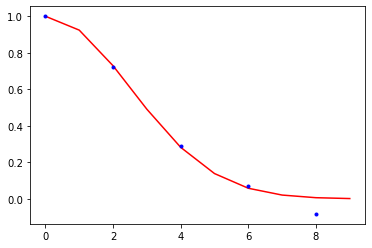

ASSIMILATION WINDOW NUMBER 18


Number of inner iterations in outer iteration number 1: 515
Number of inner iterations in outer iteration number 2: 245
Number of inner iterations in outer iteration number 3: 29
Number of inner iterations in outer iteration number 4: 5
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [107.35011312 106.16830198 106.15573958 106.15284745 106.1512691 ]
Observation contribution to cost function [135.84440841 134.45650346 134.42809273 134.42819562 134.42973845]
Model contribution to cost function  [122.53684006 119.18463861 119.22221089 119.22494926 119.22498414]
The values of the cost function total [365.7313616  359.80944404 359.8060432  359.80599233 359.8059917 ]
RMS between background/truth and analysis/truth [0.55060781 0.37643891]
New estimate for variance coming from assimilation window 18: 0.0781095131340914
New estimate for correlation length coming from assimilation window 18: 3.054898280386001


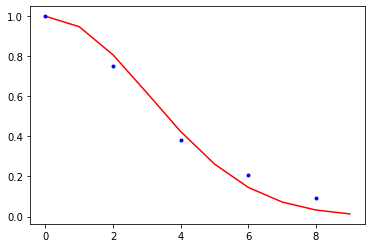

ASSIMILATION WINDOW NUMBER 19


Number of inner iterations in outer iteration number 1: 486
Number of inner iterations in outer iteration number 2: 251
Number of inner iterations in outer iteration number 3: 49
Number of inner iterations in outer iteration number 4: 13
Number of inner iterations in outer iteration number 5: 2

Background contribution to cost function [159.41144839 157.14849925 157.09477458 157.0888892  157.08827324]
Observation contribution to cost function [156.79016995 153.91930595 153.84519321 153.84114256 153.83969066]
Model contribution to cost function  [137.25577273 136.36981533 136.48248097 136.49207111 136.49411565]
The values of the cost function total [453.45739107 447.43762052 447.42244876 447.42210288 447.42207955]
RMS between background/truth and analysis/truth [0.52753086 0.41297488]
New estimate for variance coming from assimilation window 19: 0.056515913858249535
New estimate for correlation length coming from assimilation window 19: 2.081193720716655


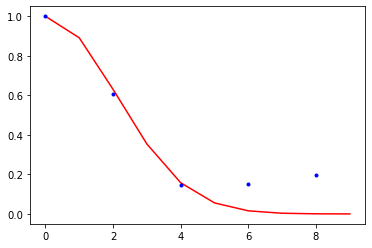

In [6]:
rd.seed(11)

win     = 20     # number of assimilation windows 
nt      = 5      # size of assimilation window
nr      = 200    # size spatial grid
dt      = 0.01   # temporal step size
mt      = 3      # number of observations in time
mr      = 100    # number of observations in space
dmt     = 2      # number of temporal gridpoints between observations
dmr     = 2      # number of spatial gridpoints between  observations
p       = 10 



b_var       = 0.01
b_len       = 0
d_var       = 0.01
q_var_truth = 0.05
l_truth     = 3



# Lorenz96 model set up
F         = 8.0
my_Lorenz = Lorenz96(nr,F,dt)

    
# initial condition 
u0     = F*np.ones(nr)
u0[0] += 0.01
for n in range(10000):
    u0 = my_Lorenz.step_rk4(u0) 
    
rep     = 10
var     = np.zeros((rep,win))
length  = np.zeros((rep,win))
meanvar = np.zeros((rep,win))
meanlen = np.zeros((rep,win))

for i in range(rep): 
    u_analysis, u_back, u_truth, var[i], length[i],  meanvar[i], meanlen[i], H, d = q_estimate( win,my_Lorenz,u0,p, nt, mr, mt, dmr, dmt,b_var,b_len,d_var,q_var_truth,l_truth)



estimated variances [0.04251768 0.05213429 0.04750836 0.05231597 0.04303216 0.05178237
 0.04353263 0.04965219 0.05968851 0.03821203 0.06121362 0.04972766
 0.05344648 0.05612054 0.0536675  0.08042751 0.04616557 0.06385042
 0.05946231 0.0679727 ]
estimated correlation length [3.30809062 3.04689075 3.04478269 2.94623108 2.56736492 2.69831635
 2.83544802 3.11633491 3.30475079 2.41628939 3.18260026 2.68275119
 2.64441161 2.88991922 2.82908131 2.98926612 2.51751919 3.30825746
 2.49659397 2.83407594]


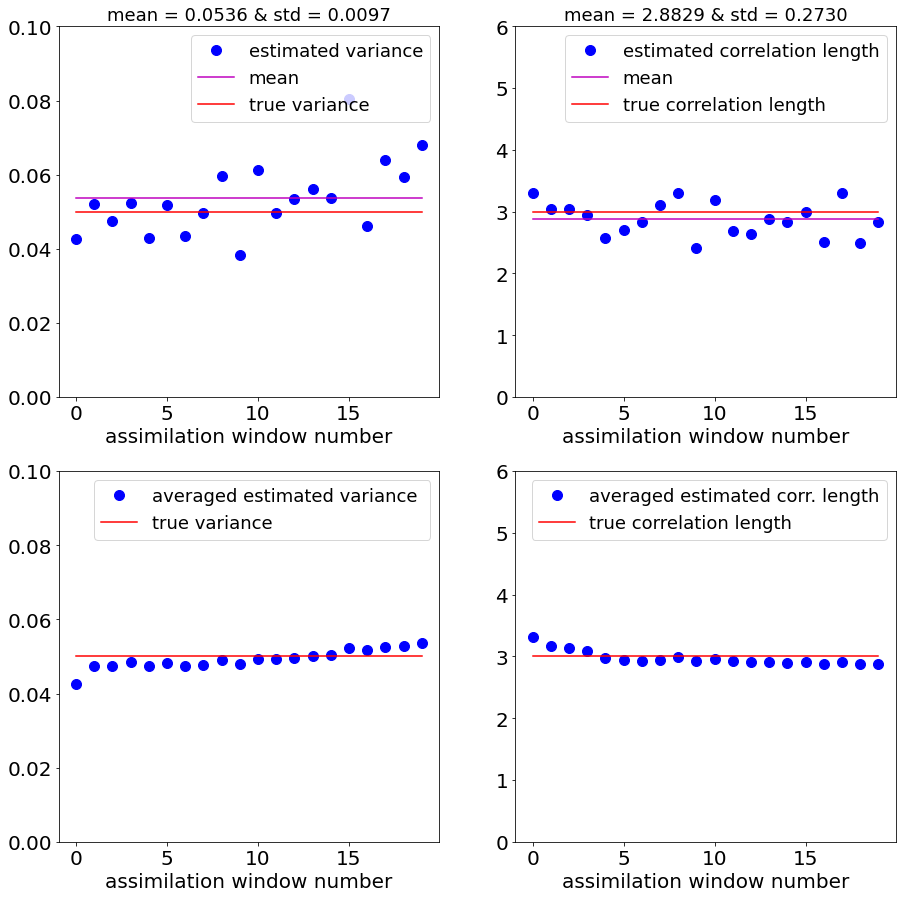

In [5]:
q_estimate_analysis(win,var[0],length[0],meanvar[0],meanlen[0],q_var_truth, l_truth)

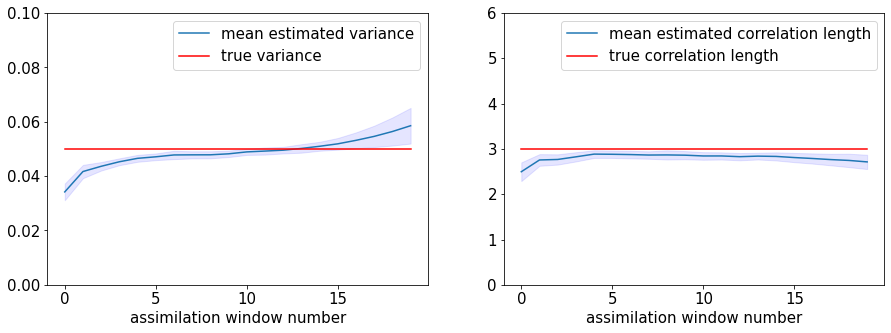

In [35]:
confidence_interval(win,rep,meanvar,meanlen,q_var_truth,l_truth)